# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
import numpy as np
from numpy.polynomial import Polynomial
import seaborn as sns
from pymoo.indicators.hv import HV
import os
import scikit_posthocs as sp
import traceback

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('seaborn')

/tmp/ipykernel_2642076/3527511527.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
max_expr_size = None
max_gen = None
max_size = 10
max_complexity = 1

dataset_filename_fronts = defaultdict(lambda: defaultdict(list))

translation_dict = {
"SO":"SO",
"MO": "MO",
"MO_equalclustersize": "5 x population size",
"MO_balanced": "Balanced k-leader",
"MO_k2": "Balanced k-2-Leader",
"MO_frac1": "Restricted Donor Population",
"MO_equalclustersize_balanced_frac1": "",
"MO_equalclustersize_k2_frac1": "Balanced k-2-Leader restricted donor population",
"MO_equalclustersize_k2_frac1_noadf":"",
"MO_equalclustersize_balanced_discount":"",
"MO_equalclustersize_balanced_frac1_discount":"",
"MO_equalclustersize_k2_noadf":"",
"MO_equalclustersize_k2":"",
"MO_equalclustersize_balanced":"",
"MO_equalclustersize_frac1":"",
"tree_7":"",
"tree_42":"",
"tree_44":"",
"MO_nocluster": "MO without clustering",
"MO_k2_frac1":"MO_k2_frac1"
}

In [5]:
def statistics_latex(hv_list, dataset, appendix):
    try:
        print("#"*20, dataset, appendix, "#"*20)
        print(sorted(list(hv_list.keys())))

        stri = ""
        for x in ["{0:.3f} $\\pm$ {1:.3f}".format(np.mean(hv_list[k]), np.std(hv_list[k])) for k in sorted(list(hv_list.keys()))]:
            stri += x + " & "
        print(stri)
        
        print([len(hv_list[k][0]) for k in sorted(list(hv_list.keys()))])
        x = sp.posthoc_wilcoxon([hv_list[k][0] for k in sorted(list(hv_list.keys()))], p_adjust="Holm")
        print(x)
        print("#"*20)
        return x
    except Exception as e:
        print("stats", e)
        pass

def statistics(hv_list, dataset, appendix):
    print("#"*20, dataset, appendix, "#"*20)

    for k in hv_list.keys():
        print(k, np.mean(hv_list[k]))

In [6]:
data_folder = "final"


experiments = [
    ["SO_7_1", "SO_6_1", "SO_5_1", "SO_4_1", "SO_3_1", 
     "SO_5_2", "SO_4_2", "SO_3_2", 
     "SO_5_3", "SO_4_3", "SO_3_3",
     "SO_5_4", "SO_4_4", "SO_3_4",
     "SO_5_5", "SO_4_5", "SO_3_5"
    ],
    ["SO_4_4_ARO", "SO_4_4_drift", "SO_4_4_nthg", "SO_7_1_drift", "SO_7_1_nthg"],
    
    ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"],
    ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"],
    ["GA_7_1_32768","GA_4_4_32768"],
    ["GP_7_1_32768","GP_4_4_32768"],
    ["SO_4_4_16384_drift", "SO_4_4_16384_nthg", "SO_7_1_16384_drift"]
]

big_list = []
for sublist in experiments:
    big_list.extend(sublist)
    
dict_per_dataset = {}
    
#"synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"
for dataset in ["air", "bike", "concrete","dowchemical","tower", 
                "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]:
    d = defaultdict(lambda: defaultdict(list))
    c = defaultdict(int)
    time = defaultdict(float)

    folder = data_folder
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):

        if(dataset in filename):
            nr = filename.split("/")[-1].split("_")[0]
            d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

            if d_key not in big_list:
                continue
            
            df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
            
            # Train R2
            d[d_key][0].append(1. - float(df.iloc[-1][1])/float(df.iloc[-1][7]))
            # Val R2
            d[d_key][1].append(1. - float(df.iloc[-1][2])/float(df.iloc[-1][8]))
            # Found
            d[d_key][2].append(1. if float(df.iloc[-1][1])<1e-6 else 0.)
            # Number of nodes
            d[d_key][3].append(float(df.iloc[-1][3]))
            # Non-improvements
            d[d_key][4].append(float(df.iloc[-1][15].split(",")[-1]))
            # Gen best is found
            d[d_key][5].append(["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.6f}".format(float(df.iloc[-1][1]))))
            # Time best is found
            d[d_key][6].append(float(df.iloc[-1][16].split(",")[["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.6f}".format(float(df.iloc[-1][1])))]))
            # Best size
            d[d_key][7].append(float(df.iloc[-1][4]))
            # Gens
            d[d_key][8].append(len(["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")]))
            # Time
            d[d_key][9].append(float(df.iloc[-1][16].split(",")[-1]))
            d[d_key][10].append(float(df.iloc[-1][4]))
            # closest to one hour 
            d[d_key][11].append(1. - float(df.iloc[-1][9].split(",")[max([i for i, v in enumerate([float(z) for z in df.iloc[-1][16].split(",")]) if v <= 3600], default=-1)])/float(df.iloc[-1][7]))
            # closest to 6 hours
            d[d_key][12].append(1. - float(df.iloc[-1][9].split(",")[max([i for i, v in enumerate([float(z) for z in df.iloc[-1][16].split(",")]) if v <= 3600*6], default=-1)])/float(df.iloc[-1][7]))
            # # evals
            d[d_key][13].append(float(df.iloc[-1][17].split(",")[-1]))
 
             
            
    
    dict_per_dataset[dataset] = d
    
    print("#"*5, dataset, "#"*5)
    for k in d.keys():
        print(k, "Train R2", "{:.3f}".format(np.mean(d[k][0])), "Val R2", "{:.3f}".format(np.mean(d[k][1])),
              "Size", "{:.3f}".format(np.mean(d[k][3])), 
              "Found", "{:.3f}".format(np.sum(d[k][2])), 
              "MSE per comp", "{:.3f}".format(np.mean(d[k][0])*100/np.mean(d[k][3])), "Non-improvements", np.mean(d[k][4]), "Gens", np.mean(d[k][5]), "Time to min", np.median(d[k][6]), "Time", np.median(d[k][9])/3600, "Evals", np.median(d[k][13]))
    
    for el in dict_per_dataset[dataset].keys():
        if len(dict_per_dataset[dataset][el][0])!=30:
            print(dataset, el, len(dict_per_dataset[dataset][el][0]))
    



##### air #####
SO_3_1 Train R2 0.623 Val R2 0.613 Size 12.800 Found 0.000 MSE per comp 4.867 Non-improvements 100.0 Gens 24.366666666666667 Time to min 102.5934985 Time 0.16191000194444446 Evals 36899088.0
SO_3_2 Train R2 0.732 Val R2 0.726 Size 23.300 Found 0.000 MSE per comp 3.143 Non-improvements 73.26666666666667 Gens 178.66666666666666 Time to min 798.5355225000001 Time 0.6333666654166668 Evals 101383000.0
SO_3_3 Train R2 0.803 Val R2 0.799 Size 38.567 Found 0.000 MSE per comp 2.083 Non-improvements 13.166666666666666 Gens 241.4 Time to min 3461.5484619999997 Time 1.0029645791666666 Evals 128725692.0
SO_3_4 Train R2 0.821 Val R2 0.816 Size 55.100 Found 0.000 MSE per comp 1.489 Non-improvements 1.4 Gens 233.5 Time to min 3604.435547 Time 1.0033793131944444 Evals 108652664.0
SO_3_5 Train R2 0.822 Val R2 0.817 Size 72.167 Found 0.000 MSE per comp 1.139 Non-improvements 0.4 Gens 193.4 Time to min 3605.2614745 Time 1.0027200316666667 Evals 95834224.0
SO_4_1 Train R2 0.699 Val R2 0.692

##### dowchemical #####
SO_3_1 Train R2 0.726 Val R2 0.727 Size 13.933 Found 0.000 MSE per comp 5.214 Non-improvements 100.0 Gens 12.166666666666666 Time to min 44.029499 Time 0.12153194430555556 Evals 32923588.0
SO_3_2 Train R2 0.783 Val R2 0.783 Size 24.233 Found 0.000 MSE per comp 3.230 Non-improvements 96.66666666666667 Gens 127.5 Time to min 479.29049699999996 Time 0.4208973523611111 Evals 81888000.0
SO_3_3 Train R2 0.809 Val R2 0.808 Size 35.867 Found 0.000 MSE per comp 2.255 Non-improvements 43.266666666666666 Gens 383.26666666666665 Time to min 2953.336548 Time 1.0009512669444445 Evals 142099072.0
SO_3_4 Train R2 0.829 Val R2 0.829 Size 45.233 Found 0.000 MSE per comp 1.832 Non-improvements 7.7 Gens 339.1333333333333 Time to min 3354.908447 Time 1.0012982177777778 Evals 122305172.0
SO_3_5 Train R2 0.837 Val R2 0.837 Size 63.500 Found 0.000 MSE per comp 1.318 Non-improvements 2.2333333333333334 Gens 289.23333333333335 Time to min 3530.3775635 Time 1.0014618258333334 Evals 101067

##### synthetic_2 #####
GA_4_4_32768 Train R2 0.939 Val R2 0.938 Size 25.467 Found 0.000 MSE per comp 3.686 Non-improvements 25.1 Gens 141.9 Time to min 16892.2685545 Time 6.012067871111111 Evals 4977450.5
GA_7_1_32768 Train R2 0.967 Val R2 0.967 Size 32.133 Found 0.000 MSE per comp 3.011 Non-improvements 5.833333333333333 Gens 167.03333333333333 Time to min 20681.2382815 Time 6.017651909722222 Evals 4570190.5
GP_4_4_32768 Train R2 0.976 Val R2 0.975 Size 55.767 Found 6.000 MSE per comp 1.750 Non-improvements 17.633333333333333 Gens 90.93333333333334 Time to min 19922.023437 Time 6.011536729583333 Evals 2228224.0
GP_7_1_32768 Train R2 0.933 Val R2 0.926 Size 37.167 Found 0.000 MSE per comp 2.509 Non-improvements 33.733333333333334 Gens 139.76666666666668 Time to min 20823.7958985 Time 6.0347843425 Evals 2228224.0
SO_3_1 Train R2 0.830 Val R2 0.827 Size 12.000 Found 0.000 MSE per comp 6.919 Non-improvements 100.0 Gens 3.933333333333333 Time to min 10.2995 Time 0.050294998888888894 Evals

##### synthetic_4 #####
GA_4_4_32768 Train R2 0.506 Val R2 0.487 Size 18.600 Found 0.000 MSE per comp 2.721 Non-improvements 28.8 Gens 153.36666666666667 Time to min 18140.012694999998 Time 6.016694607222222 Evals 4917024.0
GA_7_1_32768 Train R2 0.599 Val R2 0.579 Size 24.967 Found 0.000 MSE per comp 2.401 Non-improvements 12.666666666666666 Gens 152.36666666666667 Time to min 19735.2197265 Time 6.015579969583333 Evals 4518136.5
GP_4_4_32768 Train R2 0.839 Val R2 0.835 Size 33.667 Found 0.000 MSE per comp 2.492 Non-improvements 35.5 Gens 182.43333333333334 Time to min 18845.904297 Time 6.0206637912500005 Evals 2228224.0
GP_7_1_32768 Train R2 0.806 Val R2 0.801 Size 26.567 Found 0.000 MSE per comp 3.035 Non-improvements 37.5 Gens 128.5 Time to min 16990.232422 Time 6.010630967777778 Evals 2228224.0
SO_3_1 Train R2 0.148 Val R2 0.151 Size 9.100 Found 0.000 MSE per comp 1.626 Non-improvements 100.0 Gens 1.3 Time to min 4.383 Time 0.05946680708333334 Evals 19625682.0
SO_3_2 Train R2 0.730 

# How often do the configurations recover the expression?

/tmp/ipykernel_2642076/775655906.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow = cm.get_cmap('rainbow')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


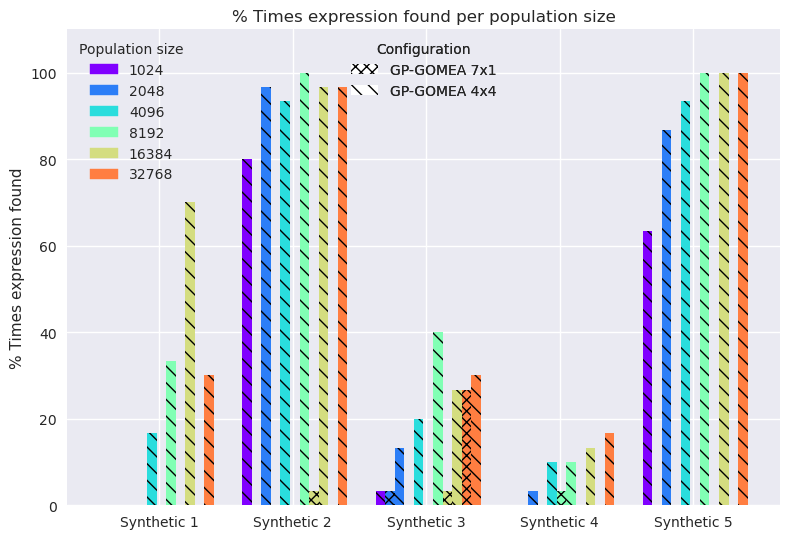

In [45]:
import matplotlib.cm as cm

plt.rcParams['text.usetex'] = False

rainbow = cm.get_cmap('rainbow')

c = [rainbow(i / (7 - 1)) for i in range(7)]

species = ("Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5")


penguin_means = {
    #'Popsize 4096 rmintron': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_intron"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_intron"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_intron"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_intron"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_intron"][2])),
    
    '1024': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_1024"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_1024"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_1024"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_1024"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_1024"][2])),
    '2048': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_2048"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_2048"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_2048"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_2048"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_2048"][2])),
    '4096': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_4096"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_4096"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_4096"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_4096"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_4096"][2])),
    '8192': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_8192"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_8192"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_8192"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_8192"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_8192"][2])),
    '16384': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_16384"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_16384"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_16384"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_16384"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_16384"][2])),
    '32768': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_32768"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_32768"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_32768"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_32768"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_32768"][2])),
}

penguin_means_7_1 = {
    #'Popsize 4096 rmintron': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_intron"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_intron"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_intron"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_intron"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_intron"][2])),
    
    '1024': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_1024"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_1024"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_1024"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_1024"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_1024"][2])),
    '2048': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_2048"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_2048"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_2048"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_2048"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_2048"][2])),
    '4096': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_4096"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_4096"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_4096"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_4096"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_4096"][2])),
    '8192': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_8192"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_8192"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_8192"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_8192"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_8192"][2])),
    '16384': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_16384"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_16384"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_16384"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_16384"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_16384"][2])),
    '32768': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_32768"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_32768"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_32768"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_32768"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_32768"][2])),
}

x = np.arange(len(species))  # the label locations
width = 1/len(penguin_means.keys())  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()


for (measurement), (measurement_7_1)  in zip(penguin_means.values(), penguin_means_7_1.values()):
    
    offset = width * multiplier
    
    for idx, (m, m7_1) in enumerate(zip(measurement, measurement_7_1)):
        rects = ax.bar(idx*(width*5 + width*2.) + offset, 100*np.array(m)/30., width/2., color = c[multiplier], hatch="\\\\")
        
  
        rects = ax.bar(idx*(width*5 + width*2.) + offset - width/2., 100*np.array(m7_1)/30., width/2., hatch="xxx", color = c[multiplier])
        
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'% Times expression found')
ax.set_title(r'% Times expression found per population size')
ax.set_xticks([.4 + idx*(width*5 + width*2.) for idx in x], species)
# Place legend outside the plot area
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Population size")
          
colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx, val in enumerate(penguin_means.keys())]
colour_legend = plt.legend(handles=colour_legend_elements, labels=list(penguin_means.keys()), title="Population size")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Rectangle((0,0),1,1, hatch="xxx", facecolor="white"), plt.Rectangle((0,0),1,1, hatch="\\\\", facecolor="white")]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 7x1", "GP-GOMEA 4x4"], title="Configuration", loc="upper center")
plt.gca().add_artist(marker_legend)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add some room at the top of the plot (adjust ylim)
max_value = max(max(measurement) for measurement in penguin_means.values())
ax.set_ylim(top=100*max_value/30 + 10)  # Add 10 units of extra space at the top

plt.savefig("./results/plots/final/timesexpressionfound.pdf", bbox_inches='tight', dpi=600)
plt.show()

# Have Algorithms converged? Use in combination with #gens 
MAy need to look at what the gap between the index of the last unique value and the length. If 100 then definitely converged

/tmp/ipykernel_2642076/2886567138.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


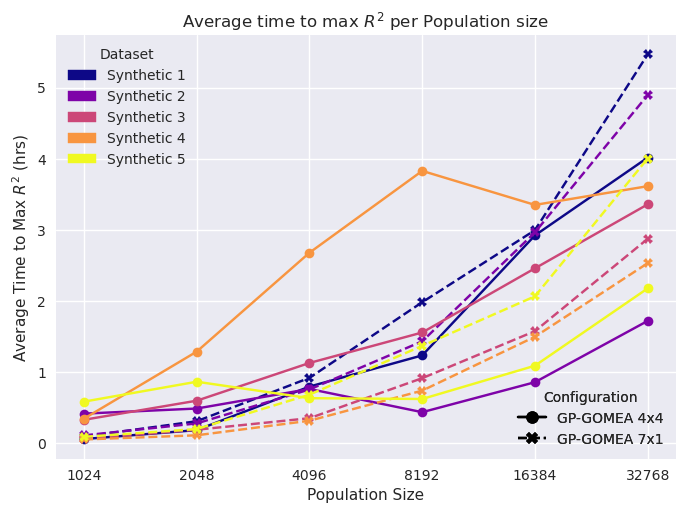

In [8]:
plt.figure()


plasma = cm.get_cmap('plasma')

c = [plasma(i / (5 - 1)) for i in range(5)]



plt.rcParams['text.usetex'] = False

for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][6])/(3600))

    plt.plot(locations, plt_list, label=dataset.capitalize().replace("_"," "), marker="o", color=c[idx])
    
    plt_list = []
    for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][6])/(3600))

    plt.plot(locations, plt_list, label=dataset.capitalize().replace("_"," "), marker="X", linestyle="--", color=c[idx])
    plt.xscale('log', base=2)
    plt.ylabel('Average Time to Max ' + r"$R^2$" + ' (hrs)')
    plt.xlabel("Population Size")
    plt.title(r"Average time to max $R^2$ per Population size")
    plt.xticks(locations, labels=locations)

colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset", loc="upper left")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="lower right")
plt.gca().add_artist(marker_legend)
plt.show()

# Highest average R2 within 1 hour

4x4 [0.90028833 0.93463331 0.96292013 0.96009309 0.94283618 0.90496717]
7x1 [0.800646   0.84466262 0.88197969 0.90424571 0.84076847 0.72336048]


/tmp/ipykernel_2642076/2668108727.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


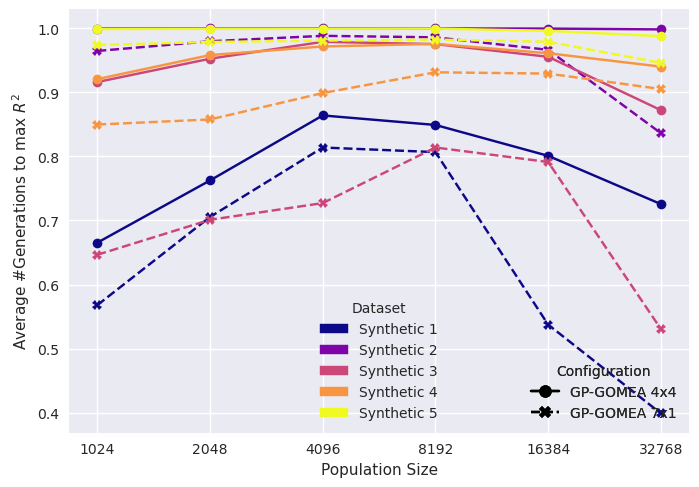

In [9]:
plt.figure()
plasma = cm.get_cmap('plasma')

c = [plasma(i / (5 - 1)) for i in range(5)]

plt.rcParams['text.usetex'] = False

list_of_lists_4x4 = []
list_of_lists_7x1 = []

for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][11]))
        
    list_of_lists_4x4.append(plt_list)
    plt.plot(locations, plt_list, label=dataset, marker="o", color=c[idx])
    
    
    plt_list = []
    for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][11]))
    list_of_lists_7x1.append(plt_list)
    plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[idx])
    
    plt.xscale('log', base=2)
    plt.ylabel('Average #Generations to max ' + r'$R^2$')
    plt.xlabel("Population Size")
    plt.xticks(locations, labels=locations)

list_of_lists_4x4 = np.array(list_of_lists_4x4 )
print("4x4", list_of_lists_4x4 .mean(0))

list_of_lists_7x1 = np.array(list_of_lists_7x1 )
print("7x1", list_of_lists_7x1.mean(0))

colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset", loc="lower center")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="lower right")
plt.gca().add_artist(marker_legend)
plt.show()

# Highest $R^2$ in 6 hrs

/tmp/ipykernel_2642076/1604476802.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


4x4 [0.90040845 0.93645505 0.96721269 0.97521222 0.98199345 0.96951429]
7x1 [0.800646   0.84467535 0.88412301 0.92213031 0.93803904 0.95661465]


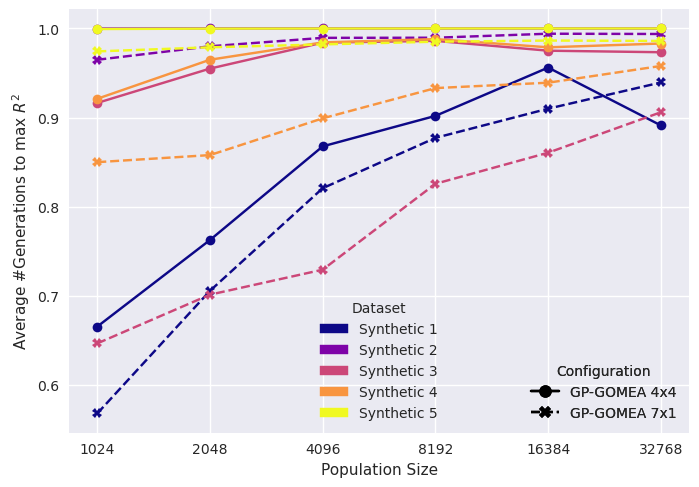

In [10]:
plt.figure()
plasma = cm.get_cmap('plasma')

c = [plasma(i / (5 - 1)) for i in range(5)]

plt.rcParams['text.usetex'] = False

list_of_lists_4x4 = []
list_of_lists_7x1 = []

for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][12]))
        
    list_of_lists_4x4.append(plt_list)
    plt.plot(locations, plt_list, label=dataset, marker="o", color=c[idx])
    
    
    plt_list = []
    for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][12]))
    list_of_lists_7x1.append(plt_list)
    plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[idx])
    
    plt.xscale('log', base=2)
    plt.ylabel('Average #Generations to max ' + r'$R^2$')
    plt.xlabel("Population Size")
    plt.xticks(locations, labels=locations)

list_of_lists_4x4 = np.array(list_of_lists_4x4 )
print("4x4", list_of_lists_4x4 .mean(0))

list_of_lists_7x1 = np.array(list_of_lists_7x1 )
print("7x1", list_of_lists_7x1.mean(0))

colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset", loc="lower center")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="lower right")
plt.gca().add_artist(marker_legend)
plt.show()

Improvements can still be made with 4x4 while 7x1 goes down due to it taking much longer

/tmp/ipykernel_2642076/138470600.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


4x4 [190.26       200.32666667 213.87333333 160.2        156.61333333
 116.84      ]
7x1 [17.81333333 24.36       31.7        32.30666667 24.92       20.35333333]


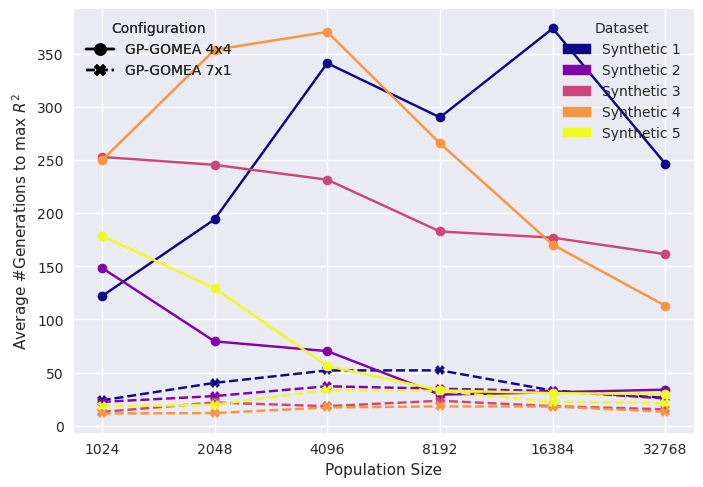

In [11]:
plt.figure()
plasma = cm.get_cmap('plasma')

c = [plasma(i / (5 - 1)) for i in range(5)]

plt.rcParams['text.usetex'] = False

list_of_lists_4x4 = []
list_of_lists_7x1 = []

for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][5]))
        
    list_of_lists_4x4.append(plt_list)
    plt.plot(locations, plt_list, label=dataset, marker="o", color=c[idx])
    
    
    plt_list = []
    for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][5]))
    list_of_lists_7x1.append(plt_list)
    plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[idx])
    
    plt.xscale('log', base=2)
    plt.ylabel('Average #Generations to max ' + r'$R^2$')
    plt.xlabel("Population Size")
    plt.xticks(locations, labels=locations)

list_of_lists_4x4 = np.array(list_of_lists_4x4 )
print("4x4", list_of_lists_4x4 .mean(0))

list_of_lists_7x1 = np.array(list_of_lists_7x1 )
print("7x1", list_of_lists_7x1.mean(0))

colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset", loc="upper right")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="upper left")
plt.gca().add_artist(marker_legend)
plt.show()

When normalising for population size we would expect the line to become straight. It increases with population size, likely due to the 7x1 getting less introns once the population is larger.

# Is there a time advantage?

/tmp/ipykernel_2642076/3105229537.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


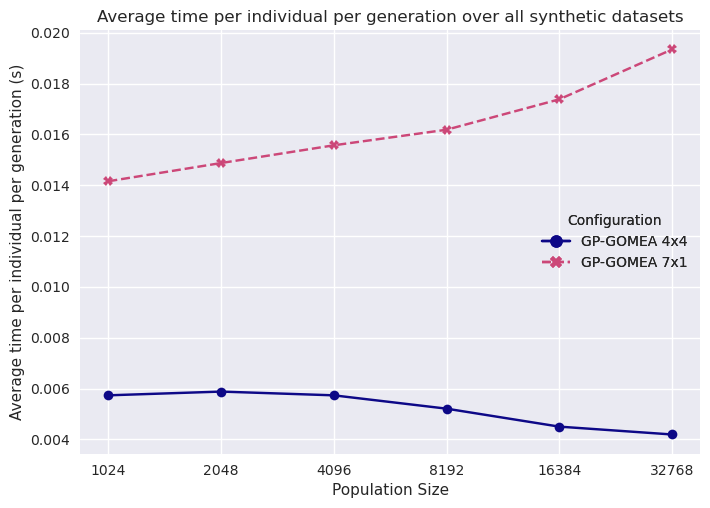

In [12]:
plt.figure()

plasma = cm.get_cmap('plasma')

c = [plasma(i / (3 - 1)) for i in range(3)]

plt.rcParams['text.usetex'] = False


   
locations = [1024, 2048, 4096, 8192, 16384, 32768]

plt_list = []
for run_idx, run in enumerate(["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]):
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.array(dict_per_dataset[dataset][run][9])/np.array(dict_per_dataset[dataset][run][8]))
    plt_list.append(total/(5.))

#plt.plot(locations, plt_list, label=dataset, marker="o", color=c[0])    
plt.plot(locations, np.divide(plt_list, locations), label=dataset, marker="o", color=c[0])

plt_list = []
for run_dix, run in enumerate(["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]):
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.array(dict_per_dataset[dataset][run][9])/np.array(dict_per_dataset[dataset][run][8]))
    plt_list.append(total/(5.))

#plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[1])    
plt.plot(locations, np.divide(plt_list, locations), label=dataset, marker="X", linestyle="--", color=c[1])


plt.xscale('log', base=2)
plt.ylabel('Average time per individual per generation (s)')
plt.xlabel("Population Size")
plt.xticks(locations, labels=locations)
plt.title("Average time per individual per generation over all synthetic datasets")

# colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
# colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset")
# plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color=c[0], markerfacecolor=c[0], markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color=c[1], markerfacecolor=c[1], markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="center right")
plt.gca().add_artist(marker_legend)
plt.savefig("./results/plots/final/timepergen.pdf", bbox_inches='tight', dpi=600)
plt.show()

[(0.050383, 0.029803, 0.527975, 1.0), (0.798216, 0.280197, 0.469538, 1.0), (0.940015, 0.975158, 0.131326, 1.0)]


/tmp/ipykernel_2642076/2185676603.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


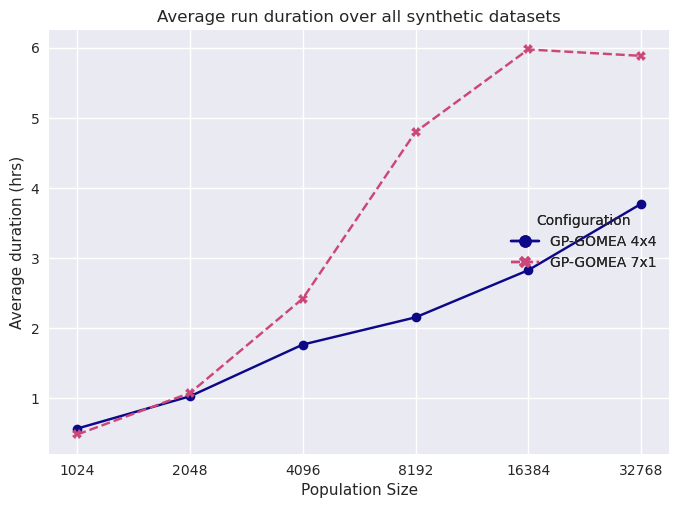

In [31]:
plt.figure()

plasma = cm.get_cmap('plasma')

c = [plasma(i / (3 - 1)) for i in range(3)]

print(c)

plt.rcParams['text.usetex'] = False


   
locations = [1024, 2048, 4096, 8192, 16384, 32768]

plt_list = []
for run_idx, run in enumerate(["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]):
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.array(dict_per_dataset[dataset][run][9]))
    plt_list.append(total/(5.*3600))

#plt.plot(locations, plt_list, label=dataset, marker="o", color=c[0])    
plt.plot(locations, plt_list, label=dataset, marker="o", color=c[0])

plt_list = []
for run_dix, run in enumerate(["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]):
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.array(dict_per_dataset[dataset][run][9]))
    plt_list.append(total/(5.*3600))

#plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[1])    
plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[1])


plt.xscale('log', base=2)
plt.ylabel('Average duration (hrs)')
plt.xlabel("Population Size")
plt.xticks(locations, labels=locations)
plt.title("Average run duration over all synthetic datasets")

# colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
# colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset")
# plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color=c[0], markerfacecolor=c[0], markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color=c[1], markerfacecolor=c[1], markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="center right")
plt.gca().add_artist(marker_legend)
plt.savefig("./results/plots/final/timeperrun.pdf", bbox_inches='tight', dpi=600)
plt.show()

# What is the slope?

In [14]:
low_4x4 = []
high_4x4 = []
low_7x1 = []
high_7x1 = []
for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
    low_4x4.append(np.mean(dict_per_dataset[dataset]["SO_4_4_1024"][9])/np.mean(dict_per_dataset[dataset]["SO_4_4_1024"][8]))
    high_4x4.append(np.mean(dict_per_dataset[dataset]["SO_4_4_32768"][9])/np.mean(dict_per_dataset[dataset]["SO_4_4_32768"][8]))
    low_7x1.append(np.mean(dict_per_dataset[dataset]["SO_7_1_1024"][9])/np.mean(dict_per_dataset[dataset]["SO_7_1_1024"][8]))
    high_7x1.append(np.mean(dict_per_dataset[dataset]["SO_7_1_32768"][9])/np.mean(dict_per_dataset[dataset]["SO_7_1_32768"][8]))
    
print("Slope 4x4:", (np.mean(high_4x4)-np.mean(low_4x4))/32768, "s per extra individual")
print("Slope 7x1:", (np.mean(high_7x1)-np.mean(low_7x1))/32768, "s per extra individual")

Slope 4x4: 0.004011288649143362 s per extra individual
Slope 7x1: 0.01872343053354345 s per extra individual


/tmp/ipykernel_2642076/3361886192.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


[(0.050383, 0.029803, 0.527975, 1.0), (0.798216, 0.280197, 0.469538, 1.0), (0.940015, 0.975158, 0.131326, 1.0)]


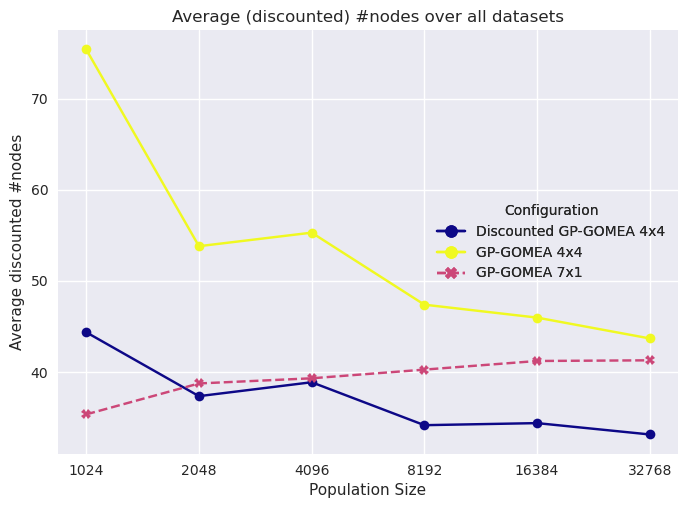

In [36]:
plt.figure()
plasma = cm.get_cmap('plasma')

c = [plasma(i / (3 - 1)) for i in range(3)]

print(c)

plt.rcParams['text.usetex'] = False


   
locations = [1024, 2048, 4096, 8192, 16384, 32768]

plt_list = []
for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.mean(dict_per_dataset[dataset][run][10]))
    plt_list.append(total/5.)

plt.plot(locations, plt_list, label=dataset, marker="o", color=c[0])    

plt_list = []
for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.mean(dict_per_dataset[dataset][run][3]))
    plt_list.append(total/5.)

plt.plot(locations, plt_list, label=dataset, marker="o", color=c[2])    


plt_list = []
for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.mean(dict_per_dataset[dataset][run][10]))
    plt_list.append(total/5.)

plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[1])   




plt.xscale('log', base=2)
plt.ylabel('Average discounted #nodes')
plt.xlabel("Population Size")
plt.xticks(locations, labels=locations)
plt.title("Average (discounted) #nodes over all datasets")

# colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
# colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset")
# plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color=c[0], markerfacecolor=c[0], markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], marker="o", color=c[2], markerfacecolor=c[2], markersize=9, markeredgewidth=0),
                          plt.Line2D([0], [0], linestyle="--", marker="X", color=c[1], markerfacecolor=c[1], markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["Discounted GP-GOMEA 4x4","GP-GOMEA 4x4", "GP-GOMEA 7x1"], title="Configuration", loc="center right")
plt.gca().add_artist(marker_legend)
plt.savefig("./results/plots/final/discountednodespergen.pdf", bbox_inches='tight', dpi=600)
plt.show()

probelm with figure below: it just takes the total of last. But 4x4 does more gens

/tmp/ipykernel_2642076/554641352.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


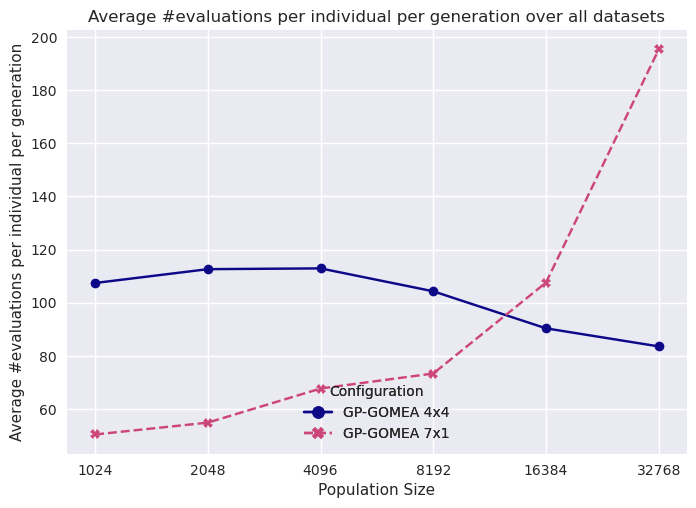

In [37]:
plt.figure()
plasma = cm.get_cmap('plasma')

c = [plasma(i / (3 - 1)) for i in range(3)]

plt.rcParams['text.usetex'] = False


   
locations = [1024, 2048, 4096, 8192, 16384, 32768]

plt_list = []
for run_idx, run in enumerate(["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]):
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(dict_per_dataset[dataset][run][13])/np.mean(dict_per_dataset[dataset][run][8])
    plt_list.append(total/(5.))

plt.plot(locations, np.divide(plt_list, locations), label=dataset, marker="o", color=c[0])    


plt_list = []
for run_idx, run in enumerate(["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]):
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(dict_per_dataset[dataset][run][13])/np.mean(dict_per_dataset[dataset][run][8])
    plt_list.append(total/(5.))

plt.plot(locations, np.divide(plt_list, locations), label=dataset, marker="X", linestyle="--", color=c[1])    


plt.xscale('log', base=2)
plt.ylabel('Average #evaluations per individual per generation')
plt.xlabel("Population Size")
plt.xticks(locations, labels=locations)
plt.title("Average #evaluations per individual per generation over all datasets")

# colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
# colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset")
# plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color=c[0], markerfacecolor=c[0], markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color=c[1], markerfacecolor=c[1], markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="lower center")
plt.gca().add_artist(marker_legend)
plt.savefig("./results/plots/final/evalspergen.pdf", bbox_inches='tight', dpi=600)
plt.show()

In [17]:
for dataset in ["air", "bike", "concrete","dowchemical","tower", 
                "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]:


    folder = data_folder
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):
        if(dataset in filename):
            nr = filename.split("/")[-1].split("_")[0]
            d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]
            if d_key not in big_list:
                continue

            df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
            print(df.iloc[-1][1], df.iloc[-1][6])

18.511183 (130.636780+(130.636780*(((112376.273437500/x_3)+(x_0-1345.831420898))*(sqrt(x_2)*sqrt(x_4)))))
10.165999 (109.335747+(109.335747*(sqrt(func[(((x_0*x_2)*(x_0+any[x_3]))*(x_4/(x_2+x_3)))])/(func[(((x_0*x_2)*(x_0+any[419.740966797]))*(x_4/(x_2+x_3)))]+(11.326464653+x_2)))))
9.193381 (146.712296+(146.712296*ln(((x_4*x_2)*func[((func[(((1435.840942383/x_4)+(24122.328125000/x_2))/((x_0-x_3)*(x_4*x_2)))]+(x_0*x_0))/(sqrt(x_0)+(x_3+-23.159221649)))]))))
8.270276 (165.348862+(165.348862*ln(((x_0*x_4)+func[((func[(((1089.781738281/x_2)-(x_0+7506.982421875))+((125956.226562500/x_4)/(962.834228516+x_0)))]/(x_0-any[78.225471497]))+func[(((477.636993408/x_3)*(x_0*any[sqrt(x_4)]))*(cos(any[(x_2+1432994.500000000)])*(x_2+0.001970221)))])]))))
8.215558 (594487.812500+(594487.812500*(((x_4*x_2)*(x_4+x_3))-(func[((sqrt(212.132110596)*func[(((x_4+4113.605957031)+(x_2/7.874522209))-(ln(any[x_3])/sqrt(1844.785522461)))])-sin(func[ln((func[((sqrt(x_4)-(x_2/15.012905121))*((79239.250000000*x_0)*sqr

7.357666 (100.243622+(100.243622*ln(abs((func[(((func[((((any[4476.335937500]*x_2)+(x_0/x_3))+((x_0+x_0)*func[((((x_2*656.918151855)+(x_2*x_0))*(x_4/ln(22.081480026)))+abs(((x_2*x_2)-sin(x_2))))]))+(cos((1877.180541992*x_1))*x_3))]-sqrt(2155584.750000000))+((88981.312500000*x_4)/(x_2/x_4)))+((sqrt(x_3)/func[((((any[x_1]*x_2)+(x_0/x_3))+((x_0+x_0)*func[((((x_2*656.918151855)+(x_2*x_0))*(x_4/ln(22.081480026)))+abs(((x_2*x_2)-sin(x_2))))]))+(cos((1877.180541992*x_1))*x_3))])*102087.523437500))]/(x_3*14599.308593750))))))
11.458179 (132.798645+(132.798645*abs(ln((((x_4*x_2)*(x_3+x_0))*(cos(45.458293915)*(x_0/x_3)))))))
6.998029 (104.450150+(104.450150*((ln((sqrt(x_2)*(x_3*x_0)))-((sqrt(x_2)/(x_4+x_4))/sqrt((x_0/x_2))))/(sqrt(cos((x_4-389910.750000000)))*(14542.505859375+abs(func[(((sqrt((x_2*x_4))*((x_0+87.619316101)*(245.881057739-x_3)))+-4353.015136719)+((sin(sqrt(x_3))*sqrt((27675.574218750-x_0)))*(((8449.152343750/x_0)/ln(x_1))-x_1)))]))))))
7.772621 (123.514565+(123.514565*((func[cos(

9.113411 (123.012566+(123.012566*(sin(ln(func[((((x_0+x_0)-x_1)/sqrt((19.076019287+x_3)))*sqrt(((x_2*x_4)+(x_2/5436.252929688))))]))-(((24825.392578125/x_4)/(x_0--1019.258544922))/((x_3/x_4)-(x_4*7871.500976562))))))
8.075367 (-909992.437500+(-909992.437500*((cos(func[(((sin(x_4)*cos(x_4))*((x_4*312.607574463)/(x_3/x_1)))-(ln((-2968.178710938--10306.828125000))-func[((cos(ln(2922.406494141))-((any[sqrt(1091.585083008)]/5120.334472656)/x_2))*sin(ln((any[(x_0*x_2)]*any[sqrt(1091.585083008)]))))]))])+((-18148.496093750-x_4)+func[((cos(ln(2922.406494141))-((any[x_4]/5120.334472656)/x_2))*sin(ln((any[x_0]*any[x_4]))))]))-func[((cos(ln(2922.406494141))-((any[(sqrt(x_2)+sin(-216.884384155))]/5120.334472656)/x_2))*sin(ln((any[((6242.388183594*x_0)+(5120760832.000000000/x_3))]*any[(sqrt(x_2)+sin(-216.884384155))]))))])))
8.761363 (102.749741+(102.749741*((func[ln((ln((x_3+31.842836380))+(func[ln((ln((x_3+any[5902.919921875]))/((x_0-x_1)*any[x_4])))]/ln(x_2))))]-sin(func[(func[ln((ln((x_3+any[(l

16.586683 (132.464935+(132.464935*((sqrt((x_2/x_3))+(sin(-5377.209960938)/(x_0*x_2)))*(sqrt((5686.479492188+x_0))*sqrt((x_0*x_4))))))
7.429735 (122.492386+(122.492386*(cos(ln(func[((sqrt((x_2*x_4))*((x_0+96.875892639)+(x_2*x_1)))/(((x_1/x_2)*(6673.271484375/x_0))+((x_3*x_3)+(9490.448242188-1286.151123047))))]))-(((x_4/x_3)*(x_2--469.167205811))+((x_2+x_2)/(x_0*x_4))))))
6.593056 (108.267548+(108.267548*((func[((((x_2*x_3)-(any[(x_2*x_2)]-x_0))+((x_3-x_2)-(x_2*x_0)))-(((x_4*x_3)/(any[sqrt(x_4)]/x_4))/any[(x_2*x_2)]))]*sqrt(func[((cos(sqrt(x_2))-(cos(-312.412231445)+sqrt(x_2)))/(((x_3/x_0)/(x_2*x_4))/(func[((((x_2*x_3)-(any[-189.796112061]-x_0))+((x_3-x_2)-(x_2*x_0)))-(((x_4*x_3)/(any[0.000000745]/x_4))/any[-189.796112061]))]/sqrt(2862.361328125))))]))/(((x_0-x_3)+(163.735687256+-59.166728973))*(sin(-2315.171630859)-func[((cos(sqrt(x_2))-(cos(-312.412231445)+sqrt(x_2)))/(((x_3/x_0)/(x_2*x_4))/(func[((((x_2*x_3)-(any[-189.796112061]-x_0))+((x_3-x_2)-(x_2*x_0)))-(((x_4*x_3)/(any[0.00000074

7.675576 (146.112976+(146.112976*ln((func[(((48583.652343750+x_0)/(x_4*x_0))+(func[((func[(((77820.820312500/x_2)/(x_2*x_0))+((x_0+x_0)-(any[1023.213195801]/x_2)))]-(8670.488281250+x_2))-((x_4*x_0)*(-1706.854248047-x_0)))]-(419.284973145+7386.123046875)))]*(x_2/x_3)))))
6.59129 (138.407303+(138.407303*(abs(func[(((x_2*x_1)+sqrt(0.171390250))+ln(func[(((x_2*25273.537109375)*func[(((x_4*x_0)*(x_2*x_0))/((any[x_0]-x_1)*(42072.187500000-any[135.704696655])))])+((x_0+-207.228607178)*func[(((x_4*x_0)*(x_2*x_0))/((any[x_3]-x_1)*(42072.187500000-any[x_0])))]))]))])+(sqrt(x_4)*func[(((x_2/x_4)+sqrt(1467.638549805))/sqrt((x_3/7.842884064)))]))))
14.234447 (120.141785+(120.141785*sin((((-1480.583496094*x_2)+ln(x_0))+ln(sqrt(x_4))))))
8.868398 (115.614235+(115.614235*(cos(func[ln((((x_0-6.123744965)*sqrt(x_2))*abs(sqrt(x_4))))])+(((x_4*x_1)-(x_4-x_2))-(sqrt(x_3)/sqrt(96.247116089))))))
7.403718 (91.360352+(91.360352*((sqrt(func[((sin((x_4*-473.435546875))+(abs(-13.977065086)+(x_3/17.906412125)))-(

8.098577 (109.736359+(109.736359*((x_4/func[(((x_0*any[x_4])/func[(sqrt((x_3-x_1))/sqrt((x_2/180.272415161)))])+func[(((any[func[(sqrt((x_3-x_1))/sqrt((x_2/180.272415161)))]]+any[func[(((x_0*any[x_2])+(x_1/any[x_2]))-((-6413.655761719+x_3)*abs(x_4)))]])+(8377.259765625/x_3))/((45356.007812500/1664.210815430)*(x_3+x_0)))])])/((x_2/x_3)-sqrt(x_4)))))
14.645734 (120.449348+(120.449348*(sin(ln((x_0*x_4)))-sin(ln((x_2*x_0))))))
8.834955 (1362666.375000+(1362666.375000*(cos(func[ln(((cos(any[(-27.196809769/x_3)])/(any[(x_0*x_4)]-x_2))/sqrt((x_2/x_4))))])+(((22473.617187500/x_3)/(x_0--861.167236328))+((x_4--22915.589843750)/sin(-7533.364746094))))))
9.540051 (135.734482+(135.734482*sqrt((abs((1855.086425781+x_0))*((x_4/x_3)+func[sqrt((func[(((cos(x_4)-(x_4+x_4))/((x_0+x_3)/(3079.098876953/-683.867980957)))+sqrt((any[(x_4/x_3)]*(1.724739432*x_2))))]*func[(((cos(x_4)-(x_4+x_4))/((x_0+x_3)/(3079.098876953/-683.867980957)))+sqrt((any[(x_4/x_3)]*(1.724739432*x_2))))]))])))))
7.748097 (144.087234+(

10.00693 (125.500450+(1.000000*cos(ln(func[func[((sqrt(x_4)*sqrt(x_2))*((any[((x_2*x_4)*(2232.929687500*x_3))]+any[((x_0-185.308197021)-(x_2/x_4))])/(x_3/1396.657470703)))]]))))
9.827477 (135.366135+(135.366135*sqrt((func[(func[abs((func[(((any[270.261169434]+x_0)*(x_4*940.740905762))/((x_0+-21078.800781250)/sin(x_2)))]+(39.047077179/any[(111.667236328+x_0)])))]/func[abs((func[(((any[270.261169434]+x_0)*(x_4*940.740905762))/((x_0+-21078.800781250)/sin(x_2)))]+(39.047077179/any[(x_3-138.508438110)])))])]/(x_3+132.699554443)))))
8.361403 (120.352562+(120.352562*(func[(((x_3-any[func[(((any[x_4]*127.674522400)-(x_2*any[x_3]))*sqrt((x_4/x_2)))]])*(15987.213867188-x_0))+(func[(((any[-10507.676757812]*127.674522400)-(x_2*any[3938869.750000000]))*sqrt((x_4/x_2)))]+func[(cos(func[ln((func[(((any[x_2]*127.674522400)-(x_2*any[x_3]))*sqrt((x_4/x_2)))]-func[(((any[x_4]*127.674522400)-(x_2*any[x_0]))*sqrt((x_4/x_2)))]))])*(-2432777.000000000*(0.788428068-x_2)))]))]+((x_2*-1356085.125000000)+func[((

13.509821 (120.322914+(120.322914*sin(ln(func[((sqrt(x_4)*(x_0/x_3))*(sqrt(x_2)*ln(39254.203125000)))]))))
8.249004 (148.368149+(148.368149*ln((func[((func[(((any[-1387.428344727]/x_3)*(x_0+1263.703735352))+((73667.773437500/x_2)/(any[x_4]*x_0)))]/(x_4*x_0))+(func[(((any[x_0]/x_3)*(x_0+1263.703735352))+((73667.773437500/x_2)/(any[x_2]*x_0)))]-(x_3*151.964447021)))]*(x_2*x_4)))))
7.575059 (110.043831+(110.043831*(func[(((x_3+x_3)-(-282.790618896-any[(x_3*x_2)]))+(sqrt(any[sqrt(230.228683472)])*(any[sqrt(230.228683472)]-x_1)))]/(func[(((x_3-x_0)+(any[-553.684753418]*any[x_2]))*sqrt((x_2*x_4)))]+func[(func[(((x_3+x_3)-(-282.790618896-any[(1663.640869141*x_2)]))+(sqrt(any[(x_4*2502.950439453)])*(any[(x_4*2502.950439453)]-x_1)))]/func[(((x_3-x_0)+(any[(x_2*x_1)]*any[(-41008.640625000/181.212600708)]))*sqrt((x_2*x_4)))])]))))
8.882829 (-703362.000000+(-703362.000000*(func[cos(ln(func[(sqrt((x_2*x_4))*((x_0-x_1)/cos(11215.841796875)))]))]+func[((x_4*(x_1-2.475988865))+((-73712.015625000+x_2)-

397607.34375 (-3018.477051+(-3018.477051*(((6.744274139+x_1)+func[((func[(((3.148655653-4.176389694)-(x_10*any[x_6]))/(cos(x_9)+(any[x_3]/-7.558543205)))]+func[(sin((-7.973789215*x_8))/((x_6*0.317414761)+cos(x_1)))])-sqrt((2.641361952/x_0)))])*sin(func[(((3.148655653-4.176389694)-(x_10*any[x_1]))/(cos(x_9)+(any[x_10]/-7.558543205)))]))))
408263.8125 (-32.506348+(-32.506348*func[(((any[(func[(cos(cos(x_6))+func[sin(((x_7/0.612184584)+(any[func[sin(((x_7/0.612184584)+(any[-1.074933171]*any[x_3])))]]*any[func[sin(((x_7/0.612184584)+(any[-0.520999789]*any[x_9])))]])))])]-(x_6*x_10))]+x_1)*func[((cos(-10.762888908)*(x_6*x_9))+((x_10*-0.213513047)+func[(cos(cos(x_6))+func[sin(((x_7/0.612184584)+(any[func[sin(((x_7/0.612184584)+(any[-1.074933171]*any[x_3])))]]*any[func[sin(((x_7/0.612184584)+(any[-0.520999789]*any[x_9])))]])))])]))])+sin(ln(x_0)))]))
475238.28125 (326.566895+(326.566895*((((x_1--1.826365829)*cos(x_9))*(sqrt(x_0)-(x_7/-0.203196794)))*((sin(x_6)-(x_10-0.981819689))*sin((x_7*2.9

415130.3125 (5948.118164+(5948.118164*((sin(x_1)*(x_8+x_1))-(func[(((x_7*-0.264421850)+(any[x_6]/10.408785820))/((1.295814633-x_9)-(any[x_1]*x_10)))]-func[((func[(((x_7*-0.264421850)+(any[-4.137013435]/10.408785820))/((1.295814633-x_9)-(any[x_7]*x_10)))]-func[cos(((any[x_7]*any[-5.872810364])-(any[x_7]+-1.130448580)))])+(ln(0.128571779)/(any[x_0]+x_9)))]))))
425237.59375 (12274.312500+(12274.312500*((func[sin((2.914350033*(x_7+-0.076492317)))]*func[((func[sin((2.914350033*(x_7+-0.076492317)))]+func[(func[(((x_9/-4.652840614)-(x_10*any[(x_9+x_9)]))+sin((x_9/0.358542591)))]-((-13.534630775/x_0)/(-14.079633713-x_4)))])+sin((x_1*x_6)))])-sqrt((14.664969444+x_6)))))
547626.125 (-943.500488+(-943.500488*(((x_7*(2.249402523-x_10))*((-8.445081711+x_6)+(1.912236571/x_0)))/(cos((0.178032219-x_1))/sqrt((0.953939974-x_7))))))
401065.5625 (1334.036621+(1334.036621*((((x_1-0.359939545)+(x_0*0.208984092))+(func[((((-0.250292152+any[x_7])/(x_9-1.357885122))/(ln(22.124040604)+ln(2.185823441)))-sin(((x_

414092.5625 (619.216553+(619.216553*(sin((-7.314362049*x_7))+(func[((func[(((x_0/1.438295007)+(x_7*x_3))-((x_9*x_6)*(x_10*3.786143303)))]-(x_3/x_6))+(sin(x_0)*(x_9-0.141406789)))]+func[(((6.918688297*x_7)*(1.177717328-x_7))*(x_1+cos(x_9)))]))))
401632.03125 (2300.654785+(2300.654785*((func[((func[(cos((x_7*-5.068835735))+(func[(func[(((x_0/any[(3.812059641+x_6)])+(x_1--0.115617722))*((x_6-2.838581562)/(-1.979271889/x_6)))]-((x_4/-27.341871262)-cos(x_9)))]*sin(-0.959145188)))]*func[(cos((x_7*-5.068835735))+(func[(func[(((x_0/any[(3.812059641+x_6)])+(x_1--0.115617722))*((x_6-2.838581562)/(-1.979271889/x_6)))]-((x_4/-27.341871262)-cos(x_9)))]*sin(-0.959145188)))])+(x_10*(x_5-6.071178913)))]+func[((func[(cos((x_7*-5.068835735))+(func[(func[(((x_0/any[(3.812059641+x_6)])+(x_1--0.115617722))*((x_6-2.838581562)/(-1.979271889/x_6)))]-((x_4/-27.341871262)-cos(x_9)))]*sin(-0.959145188)))]*func[(cos((x_7*-5.068835735))+(func[(func[(((x_0/any[(3.812059641+x_6)])+(x_1--0.115617722))*((x_6-2.8385815

415707.625 (1064.157227+(1064.157227*((func[(func[(((any[(x_7+-0.059748471)]/-0.037976455)*(x_7+-1.112551570))+(ln(x_0)-(x_9*any[(x_6+x_3)])))]/4.290103912)]+func[(abs((x_7+-0.399818450))+(sin(x_6)+-0.984986603))])*(func[(func[(((any[(x_7+-0.059748471)]/-0.037976455)*(x_7+-1.112551570))+(ln(x_0)-(x_9*any[(x_6+x_3)])))]/4.290103912)]+(x_1-x_10)))))
414912.96875 (4123.585938+(4123.585938*((func[(sin((x_6+x_10))*(cos(x_3)+func[(sin(func[(((x_1*x_0)*cos(x_3))/((x_6/x_7)-(any[x_7]-0.747973979)))])-cos((x_7*4.866891861)))]))]-(1.379564166/x_0))+((x_1-x_9)+func[((func[(sin(func[(((x_1*x_0)*cos(x_3))/((x_6/x_7)-(any[x_7]-0.747973979)))])-cos((x_7*4.866891861)))]*cos(x_10))-((x_9*x_9)-(-3.445739985*x_10)))]))))
428103.59375 (-4901.830078+(-4901.830078*((((7.834037304+x_7)+ln(x_0))/((0.299131513/x_6)+(x_6/5.971714497)))/(cos((x_7*5.113191605))-((x_1-5.107565880)-(x_10+x_9))))))
406043.6875 (-749.528320+(-749.528320*((((x_10-x_7)-cos(x_9))-ln(sqrt(x_0)))-((func[(sin(((x_7/1.033625722)*(3.60296583

431909.125 (4544.710449+(1.000000*(cos(func[sin(cos((x_7*any[2.509124517])))])*((x_9*x_9)-func[((ln(x_9)*(any[0.172808617]+x_3))+(func[(sin((x_1*x_6))-((x_10*any[x_6])-(2.110419512*2.387654305)))]+(-0.762429118/x_0)))]))))
419790.875 (-241.109375+(-241.109375*((cos(x_7)*func[(((-18.582843781/6.380926132)/cos(x_1))*sin((1.673170567*x_7)))])-(sqrt(x_0)+func[((sin(x_6)-func[(((x_9*x_9)*(any[x_6]*x_7))-((x_10*x_10)/sin(-84.538124084)))])-(func[(((x_8+x_7)*cos(x_9))*sin((x_7*7.730746269)))]+(x_10+x_9)))]))))
499050.625 (-89.803711+(-89.803711*((cos((-4.968107224*x_7))-(cos(x_9)+sin(x_6)))*(((x_1*0.810066044)+sqrt(x_0))/((x_6+x_0)+(x_6+9.311891556))))))
443815.09375 (-840.649414+(-840.649414*((((x_9*x_9)/func[((cos(ln(x_6))+(cos(any[-1.250771403])/(-3.551677942*x_6)))-(((x_1*57.299247742)-(x_10*x_10))*(sin(3.137228727)*(0.708185613+x_3))))])-(sqrt(5.127310276)+sqrt(x_0)))+(((x_10-x_1)*(1.079022765+x_7))-sin((-7.557791710*x_7))))))
369647.40625 (726336960.000000+(726336960.000000*((ln((0.5482

412373.0625 (936.142334+(936.142334*((func[func[((sin(any[(func[(((x_1-4.439864159)+cos(x_9))/((-9.729920387+x_3)+(x_9*x_6)))]-(0.013866913*x_0))])/(x_7+any[cos(cos(x_6))]))-sin(func[(cos((0.739412308/x_0))-((-3.600633144*any[x_7])*(any[x_7]-0.380594701)))]))]]/func[(((x_1-4.439864159)+cos(x_9))/((-9.729920387+x_3)+(x_9*x_6)))])+((x_10+x_10)-(x_10*x_10)))))
548300.875 (-21647.035156+(-21647.035156*((((7.882726669*3.523353815)-(x_6*x_9))/((x_10--7.528226852)/(x_1+13.521240234)))*(cos((x_7-0.689900815))*((x_0--77.772460938)+(x_4*0.261660486))))))
399424.1875 (5384.843750+(5384.843750*((((x_1*1.110450268)-(x_10*x_10))/((0.304355502/x_8)+sqrt(x_6)))-(cos((4.546714783*x_7))-(func[((cos((x_9*x_6))-((1.343985319/x_6)+(x_3*0.288048416)))-(((x_10*x_6)+(0.870540202/x_0))-cos((x_7-4.983328342))))]*sqrt(x_8))))))
367578.0625 (-1305.280273+(-1305.280273*(((func[((func[((((3.626342058-x_3)+(x_3/any[(x_4+-4.109673500)]))*sin(cos(x_9)))-(cos((x_6*2.189765930))-((0.019550541+x_0)-(any[(x_7*x_1)]+x_1)))

407838.75 (3648.990234+(3648.990234*((func[(((x_9+x_10)-(any[x_1]*0.981025696))+(func[cos((abs(x_7)*-5.010966301))]*cos(x_9)))]*(x_1--1.641652465))+(func[abs(((x_6+x_9)-1.954236031))]-func[((func[cos((abs(x_7)*-5.010966301))]*func[cos((abs(x_7)*-5.010966301))])+(ln(x_0)-(x_3+any[x_10])))]))))
491526.4375 (6960.986328+(6960.986328*((sin((-7.566316128*x_7))-((x_9*x_9)+(x_10*2.362078428)))+(((x_0+11.126488686)*(x_1/9.649655342))-(sqrt(x_6)+(0.950940788/x_0))))))
400787.96875 (6889.267578+(6889.267578*((abs((0.629807174-x_7))*((0.909856260*8.516742706)-func[(cos(((-3.054204702-x_10)-(any[x_5]/x_0)))-(((4.806129932*x_1)-(x_6+x_3))-((x_10+x_9)*(x_1+any[x_5]))))]))+(func[(cos(((-3.054204702-x_10)-(any[(x_1+2.358859062)]/x_0)))-(((4.806129932*x_1)-(x_6+x_3))-((x_10+x_9)*(x_1+any[(x_1+2.358859062)]))))]-sin((x_6*x_9))))))
353476.59375 (1969.571045+(1969.571045*(((func[((cos((x_7*5.330674171))*((x_7*any[x_7])+sin(x_6)))-(((x_1-x_10)*sqrt(2.198937416))*sin(sqrt(any[x_8]))))]+x_10)+func[((func[((c

388865.875 (1291.413574+(1291.413574*(((x_7+x_1)-func[((func[sin(((4.196174145/x_0)*x_10))]/(x_0+x_5))+func[(sin((-2.707668781*x_7))+((x_9+any[(x_10+-0.724223018)])*func[(-0.691872239/((x_6*x_9)+(-0.637055397*5.921421528)))]))])])*func[(sin((-2.707668781*x_7))+((x_9+any[func[sin(((4.196174145/x_0)*x_10))]])*func[(-0.691872239/((x_6*x_9)+(-0.637055397*5.921421528)))]))])))
490692.4375 (5061.697754+(5061.697754*((((x_6*x_9)*(x_8+x_9))-cos((-10.522313118*x_7)))-((ln(x_0)+ln(x_7))+((x_1+x_1)-(x_10/x_7))))))
407428.5625 (199.811035+(199.811035*((((x_0-x_9)-sqrt(x_6))+(sin(x_0)*sqrt(x_9)))-func[(((cos(any[((-6.943806648*x_7)+(0.891013503+x_3))])-3.201936007)+cos(cos(x_9)))*((sin(any[(sin(x_6)/(x_9+x_10))])+sin(x_1))+(x_7-x_10)))])))
375340.96875 (-2422.376465+(-2422.376465*(cos(sin((4.960321426-x_1)))*(func[(((func[(((cos(-2.024630070)*(any[x_10]+-6.863640308))-sin((7.610768318*x_7)))-(cos((x_7*x_6))*((x_4/-8.691308022)*(x_9-x_3))))]*cos(x_10))-((any[(x_10--4.864448547)]-4.371871471)+(x_9*x_

382678.4375 (1218.333252+(1218.333252*(sin((x_7*-7.620782852))+(func[(cos((x_9*x_7))+func[(func[((ln(x_0)+(x_1*any[(x_7/x_6)]))+(sin(any[(x_6*x_9)])+(x_6+x_10)))]*(cos(x_9)-(x_10*0.801110923)))])]-(x_6-x_1)))))
378816.65625 (-1933.139648+(-1933.139648*(((x_1--3.164394140)-(x_10*x_6))*(func[sin(((x_7*x_8)*(5.094129086-x_6)))]+func[(cos((x_9*x_9))+(func[(((x_9*x_6)*sin(0.032131847))+ln(sqrt(x_0)))]/(1.909596682+x_3)))]))))
444648.125 (-1040.510254+(-1040.510254*((sin((-2.496832848*x_7))*((1.908430815-x_10)*(-2.409706354-x_1)))/(((5.634963512+x_6)+(x_0*x_9))/(sqrt(x_0)+sin(x_6))))))
364661.4375 (283.462402+(283.462402*((sqrt((4.377818108-x_6))-cos((x_7*5.381697655)))*((func[(((cos(x_9)+(x_7+x_1))*ln((14.190670013+x_4)))-sqrt(((-25.763921738/x_0)/ln(x_10))))]*cos(5.160734653))+(sin(x_6)+cos(x_9))))))
351960.1875 (-1462.003418+(-1462.003418*(((func[((sin((any[x_8]*-8.435768127))+3.088121414)+(((x_10*-0.489728391)-(x_9+-1.673186302))*sin(sqrt(x_0))))]+(x_7*2.014683962))*(func[(sin((cos(-1.50

365875.625 (2202.736328+(2202.736328*((func[((func[sin((9.251771927/cos(x_8)))]-sqrt(x_0))/((1.374918818*-2.820581436)/cos(x_9)))]*func[((sin(any[x_6])+cos(0.984546781))+(x_1-(x_10*any[x_6])))])+sin((-6.933908463+x_8)))))
346073.90625 (9525.280273+(9525.280273*((func[(func[(cos(sqrt(x_0))-sin((-1.073257208-any[func[((sin(x_6)-(x_9-x_1))-cos((5.097766399*x_7)))]])))]+((x_3*x_1)/(x_10/0.104032010)))]-(x_7/x_6))+func[(((any[(x_6*x_10)]+4.682860374)/cos(x_10))-func[((sin(x_6)-(x_9-x_1))-cos((5.097766399*x_7)))])])))
457919.28125 (-11189.669922+(-11189.669922*((((x_7--1.005082726)*(38.429306030+x_0))/((x_6--22.661972046)/cos(x_10)))*(((x_1-x_9)+abs(8.035672188))*cos((x_7*x_7))))))
362592.53125 (1305.395508+(1305.395508*((((x_7+x_1)-(x_0/-5.438392162))*sin(func[(sin(((x_9+x_10)*(10.507615089/-4.643746853)))/((cos(any[-1.382737875])*(x_4/x_6))-((x_3+x_1)-(any[-8.310851097]+-1.530549645))))]))*(cos((x_8*5.644677639))-sin((x_10+x_6))))))
332823.71875 (-851.134766+(-851.134766*((sin((-7.94638395

57.088417 (-28.498070+(-28.498070*(((x_0+x_1)+(x_2+x_0))-((-327.592071533+x_3)*ln(x_7)))))
47.158249 (-3.844070+(-3.844070*((ln(x_7)+(x_0/x_3))*sqrt(func[(((x_2+188.040054321)/(x_3/x_5))*((134.699371338+x_1)*(any[x_0]--36.421115875)))]))))
42.947803 (-41.080704+(-41.080704*((ln(x_7)+ln(x_0))*func[((ln(x_6)*(any[(x_1+x_2)]+x_0))+((455143.250000000/x_3)+func[((sqrt(x_1)/(x_3+-185.716445923))+((x_1+x_5)-(x_7+x_2)))]))])))
41.567989 (-61.617561+(-61.617561*(ln((x_7*3308.445800781))*(func[(((x_5+x_7)+(x_7+x_7))*cos((-502.676788330*x_2)))]+func[((func[(((x_3+-1261.764526367)+(x_3-x_1))*((x_0+47.021160126)/sqrt(x_0)))]-(x_5+x_6))-((x_5-x_0)/(x_1+-97.585182190)))]))))
39.428963 (-13.788239+(-13.788239*(((x_0/72.329994202)+ln(x_7))*(func[((-371.550628662-(225.917022705+any[x_1]))+func[(((x_7*159.168594360)+(-24777.708984375+any[(x_6*x_3)]))/(func[(((x_7+-27.942110062)*(x_0*x_2))+(abs(9.491735458)*(8.646898270+x_3)))]-(x_5-x_0)))])]/func[(((-335.311553955+x_3)+(any[1.553357720]+x_3))+((32757.416

35.426556 (-157.221207+(-157.221207*((ln(func[(((((x_7*x_0)*(x_0*x_3))*((-38.325584412-x_2)+(-17.921428680-x_1)))*(((-0.850469649*any[(x_1+x_0)])/(x_7+x_3))/((-2380.881835938*-945.041625977)/(x_5-x_7))))+(sqrt(((x_1--62023.093750000)/abs(x_7)))*((abs(-21088.250000000)-(x_1*-73.576156616))+((x_1-any[(x_1*x_0)])+(-941.939453125*x_4)))))])/(((-246.048553467--258.638397217)*ln(x_3))+sin((x_1*457.166870117))))*(-233.480453491+(sin((-17.953432083*x_3))+((x_1+x_0)/(x_0-590.751220703)))))))
36.08326 (207.292419+(207.292419*cos(((((x_5-x_7)+func[((cos(((x_1*23.556404114)+cos(any[x_6])))/((sin(x_2)/(x_7-x_6))-((130.127822876/x_7)/(x_1--544.705322266))))+(sqrt(((any[x_0]/-95.271492004)+(12.665603638*x_7)))*(((x_2+x_1)--99.700225830)-cos(sqrt(x_4)))))])+(139.574142456-abs(x_2)))/(((x_3+5.678829670)*(-5889.770019531/x_0))-((x_2+x_7)+func[((cos(((x_1*23.556404114)+cos(any[x_4])))/((sin(x_2)/(x_7-x_6))-((130.127822876/x_7)/(x_1--544.705322266))))+(sqrt(((any[-1790.521972656]/-95.271492004)+(12.665603

49.789951 (0.000000+(1.000000*(sqrt(((x_0+x_1)*ln(x_7)))+((func[((((x_0+any[x_6])/(x_6-x_0))+ln((x_7/x_3)))+((func[(sin((abs(x_0)-func[sqrt((((x_7+x_4)*(x_0/x_3))*sqrt(sqrt(x_4))))]))+(func[sqrt((((x_7+x_4)*(x_0/x_3))*sqrt(sqrt(x_4))))]+sin((x_5/x_3))))]+sin(x_3))+sin((x_6/x_7))))]+(x_0/x_3))-(ln(x_5)/(x_0/x_3))))))
40.557358 (-16.331341+(-16.331341*(func[((sqrt((x_7*any[func[sqrt((any[(x_5*x_6)]+((any[(x_4+0.185622633)]+x_0)-(43839.453125000/any[(x_4+0.185622633)]))))]]))+((x_0-any[(func[((sqrt((x_7*any[x_6]))+((x_0-any[x_7])-(x_0/any[x_7])))-sqrt(((768.087402344-x_2)+(392.353332520-x_6))))]*(-560.138061523/x_3))])-(x_0/any[(func[((sqrt((x_7*any[x_6]))+((x_0-any[x_7])-(x_0/any[x_7])))-sqrt(((768.087402344-x_2)+(392.353332520-x_6))))]*(-560.138061523/x_3))])))-sqrt(((768.087402344-x_2)+(392.353332520-x_6))))]*func[(((func[sqrt((any[x_6]+((any[x_6]+x_0)-(43839.453125000/any[x_6]))))]-func[(((x_1+sin(any[x_3]))-(sin(-119.532333374)*(-893.667480469+x_5)))-((abs(x_4)/ln(15.199742317))+(sqr

57.908501 (0.000000+(1.000000*((sqrt(ln(x_7))*sqrt(func[(((ln(x_7)+(any[x_1]+x_0))+((x_7*any[x_0])/(x_7+x_6)))-(((x_5+x_5)/sqrt(x_0))*sin(sqrt(x_3))))]))+sqrt(((x_4*x_0)/(x_6/x_7))))))
38.923851 (-52.804451+(-52.804451*(sin(func[ln((((x_5+x_7)-(x_1+x_1))+func[((func[((((x_1+x_0)+(any[(x_7+x_6)]/x_0))-sqrt((368.881134033+x_4)))+(((x_0-x_1)+(x_5+any[(x_7+x_6)]))/((any[(x_7+x_6)]/x_3)-(x_2+22.392271042))))]*sqrt((x_7*26.811906815)))+((func[((((x_1+x_0)+(any[-3761.957275391]/x_0))-sqrt((368.881134033+x_4)))+(((x_0-x_1)+(x_5+any[-3761.957275391]))/((any[-3761.957275391]/x_3)-(x_2+22.392271042))))]*cos(any[(x_5/0.112882070)]))+((16333.530273438+x_7)+(7.975904465*x_0))))]))])/((sqrt(1688.355712891)*(x_7/x_3))+(x_3+sqrt(26750.318359375))))))
45.229042 (-32.130882+(-32.130882*(sqrt((((x_0+x_7)/(206.201614380+x_7))*(sqrt(x_1)+abs(-75.620239258))))/((((x_3-x_2)+(1178.226196289-x_1))/sin((-216.743728638/x_3)))/ln(sin((0.018737428/x_7)))))))
36.879265 (-44.638176+(-44.638176*((sqrt(((x_1*1.16747820

50.034843 (0.000000+(1.000000*((func[func[((((any[((x_0-sin(x_6))+func[((((any[(x_2*x_3)]+x_0)+(x_1+any[(x_5+x_1)]))/(nthg(x_3)-ln(x_7)))-(ln((x_3/x_7))-sqrt((x_1/x_0))))])]+x_0)+(x_1+any[func[(sqrt(((x_1+any[(func[((((any[x_7]+x_0)+(x_1+any[x_3]))/(nthg(x_3)-ln(x_7)))-(ln((x_3/x_7))-sqrt((x_1/x_0))))]*x_1)])+(x_7*x_2)))+(sin((x_7-x_5))/(sin(x_7)/x_4)))]]))/(nthg(x_3)-ln(x_7)))-(ln((x_3/x_7))-sqrt((x_1/x_0))))]]*ln((x_5+x_5)))+sqrt(sqrt((x_0*x_0))))))
38.58416 (-13.948452+(-13.948452*((((x_0+x_1)*func[(cos(((x_1/x_0)*func[(abs(sqrt((322.624725342/any[x_3])))+(func[cos((x_4*sin((x_0/2.056695223))))]-ln(cos(464.406829834))))]))+sqrt((func[(abs(sqrt((322.624725342/any[2.670439720])))+(func[cos((x_4*sin((x_0/2.056695223))))]-ln(cos(464.406829834))))]+(x_2/7.923727989))))])+((x_5/8.669185638)*sqrt(x_7)))/((func[(abs(sqrt((322.624725342/any[x_7])))+(func[cos((x_4*sin((x_0/2.056695223))))]-ln(cos(464.406829834))))]+func[((sqrt(func[(cos(((x_1/x_0)*func[(abs(sqrt((322.624725342/any[x_3])))+(fu

49.56284 (0.000000+(1.000000*(sqrt((ln(x_7)*(x_0+x_1)))+((sqrt(x_4)*ln(x_7))-func[((((x_4-any[(x_5/x_0)])-func[((cos((any[x_7]-x_3))*(sqrt(x_6)-(x_5/x_6)))+(sqrt((any[x_1]*x_7))+((x_0-x_3)+sqrt(x_2))))])+((any[(x_3/x_0)]-x_7)+(x_3+x_7)))/(sqrt((x_6+x_7))-(ln(x_3)+abs(any[(x_5/x_0)]))))]))))
38.871593 (-15.126179+(-15.126179*sqrt((((x_0/596.354309082)+ln(x_7))*((-6927294.000000000+x_7)+func[(((func[((((186.777282715+x_7)*cos(406.902099609))*sin((x_0*any[241.742294312])))+((sin(x_3)+(324.894348145-x_3))*func[ln(ln(((x_1+-182.040908813)+(any[(40.141273499*x_2)]+x_0))))]))]*(x_0+x_7))*((284.232849121+x_1)-(any[x_7]/10.783669472)))/cos(func[sin(abs((-2219.431152344-(x_7/any[(x_3+x_2)]))))]))])))))
40.931992 (-101.840744+(-101.840744*(((((130.093414307/x_3)+ln(x_7))+cos(sin(x_1)))*(((x_1+x_0)+x_2)/((x_3--281.447082520)-(x_5/7.680233002))))+((ln((x_0*x_6))-(sin(457.653259277)/ln(x_4)))-(((x_2/x_0)-(x_7/81.926063538))-((x_7/-58.061500549)/(377.134552002/x_0)))))))
38.644249 (62.784569+(62.7845

43.09993 (-74.233757+(-74.233757*(cos(((((698.044677734*-1409.158691406)+(655.652954102--432.343200684))-sqrt(sqrt(x_7)))+ln(((x_7-x_0)+abs(-1064.291870117)))))+sqrt(((((x_5/69.864624023)/ln(x_2))-cos((-2463.350341797/x_3)))+(sqrt((198.038406372+x_1))/(sqrt(x_3)/sqrt(x_0))))))))
40.84362 (-9.745384+(-9.745384*((((cos(sqrt(x_4))-11.987261772)*(sqrt((abs(189.079071045)*(x_0+x_1)))+(cos(abs(x_7))*((3758.637695312-x_5)/abs(x_0)))))+abs((sin((sqrt(633.399353027)/sin(x_0)))*x_3)))/(((abs(abs(sqrt(x_2)))*abs(ln((x_3/x_6))))+((((x_6/-16.084753036)-(x_7+x_3))*ln((111.049606323*x_0)))*0.084763102))/sqrt(sqrt(((-161.943389893+(x_7*x_0))*((91.158920288+x_7)+sin(x_3)))))))))
60.556225 (8.785046+(8.785046*(((x_0/x_3)*ln(x_7))*((-7.834440231--251.591934204)+(x_1+x_2)))))
46.302078 (-47.870155+(-47.870155*(ln((x_0*x_7))*(func[((sqrt(546727.437500000)+(x_1+x_0))-((262.909362793+x_7)/(3.024942875-x_2)))]/(x_3+209.895629883)))))
44.582325 (-39.238327+(-39.238327*((func[(((67.690284729/188.092910767)*(x_0

45.403648 (-38.689110+(-38.689110*((sqrt(x_0)-((x_1-(x_4-x_2))/((-34.709087372/-679.664123535)*(-779.537475586-x_2))))/((((-139.220794678-4500.528320312)*(-1241.492553711/605.491027832))/sin((-192.485534668/x_3)))/ln(abs((-225.909851074*x_7)))))))
38.328644 (-57.813843+(-57.813843*(ln((sqrt((x_0*x_7))-((x_7+x_2)/(x_6-670.423645020))))*((cos((x_3/302.026794434))+func[(((((-728.365661621/x_7)+(x_7--141.468948364))+((any[sin(x_2)]*x_7)/cos(x_7)))/(((-136.012405396*any[sin(x_2)])-any[(x_5+-582.877319336)])/sin((-135.295745850/225.936279297))))/(-62.563385010/(((x_0-2642.445312500)-x_7)/((-187.964202881-x_1)-(x_0/x_7)))))])*(x_0+((x_1--802.819641113)+x_2))))))
39.779652 (-25.619888+(-25.619888*(((468.570434570+abs((-230.043411255-x_1)))-(abs(func[(((((x_0+-370.062591553)/(x_7/-243.402984619))/((-0.580642998*x_3)+(x_2*x_2)))+(x_7/(cos(-1297.451904297)+ln(x_2))))-(((x_4-cos(x_7))--62.828971863)/sin(cos((-161.443374634/x_3)))))])+(x_7/(x_3/43.333541870))))*((sqrt(x_0)+cos(cos(x_3)))*(abs(func[

38.352566 (-56.224602+(-56.224602*(ln((sqrt((x_7*x_0))+((x_7+67.914772034)/(x_3+-131.549133301))))*((((x_7+-759.762512207)/(-3.297972918/x_0))-((-1874.916381836+32914.222656250)/(x_6+-670.718322754)))+(((x_2*178.175857544)+(x_1*243.837707520))-((x_3+-395.721954346)*(711.501281738-x_4)))))))
37.762165 (-91.957718+(-91.957718*(cos(sqrt(((150.612625122+x_4)+cos(x_3))))-((((x_0*-134.547286987)/(900.004272461-x_2))-(sqrt(x_3)*ln(x_7)))*(((x_1+653.949218750)-(x_7/4.355246544))/((x_3*350.036041260)+func[(((x_3*((any[x_5]/any[x_6])-(x_2/x_5)))*cos(((any[x_6]-53.790012360)*(269.566528320/x_5))))/sqrt((sqrt(abs(71.640594482))/((x_7*20.191520691)-(-276.205810547+-319.798919678)))))]))))))
40.482796 (-87.707634+(-87.707634*((ln(((2.461506367*x_0)+abs(x_7)))/(((x_3+260.898284912)/func[(((((-29.066507339+x_1)+(2345.209228516/any[x_0]))+x_0)-(((any[x_0]-x_2)/func[(cos((cos((any[x_5]-172.744888306))/(sin(-596.849792480)-(any[x_5]/x_2))))*(abs(x_7)-cos(((-374.959960938*x_4)+(-91.338760376+x_1)))))])+fu

35.503151 (-32.621540+(-32.621540*(((sqrt((251.673782349+x_1))*(abs(47.389007568)+sin(x_0)))/cos((sin(656.875305176)*sin(x_5))))/(func[(((sin((149.567001343-x_5))/((35.122737885+any[((10.228397369-x_4)*sqrt(8.157223701))])-sqrt(x_5)))-sqrt(((90.903518677+x_7)*abs(any[(x_3/sqrt(x_7))]))))+((sin((x_2/x_3))/((x_7-179.237655640)/(x_5-x_1)))-(cos((x_6*508.805633545))+sqrt(237.820983887))))]/(((2381.843261719-x_3)*(x_0+267.376220703))*func[(((sin((149.567001343-x_5))/((35.122737885+any[cos(x_3)])-sqrt(x_5)))-sqrt(((90.903518677+x_7)*abs(any[sin(399.125305176)]))))+((sin((x_2/x_3))/((x_7-179.237655640)/(x_5-x_1)))-(cos((x_6*508.805633545))+sqrt(237.820983887))))])))))
38.275631 (59.401707+(59.401707*sin(((((x_3+147.417373657)/sqrt(x_0))/((x_7+17.478271484)+ln(x_7)))-ln((func[(((((x_0+x_2)+cos(x_7))-((x_2+366.999572754)/(x_0/16.389530182)))+(((x_1+158.963363647)-(x_3-122.720695496))+ln((9155.383789062*x_5))))+((cos((x_6/127.569442749))*(sqrt(x_1)*sqrt(x_7)))-((cos(444.753662109)*(x_7+x_1))*cos

39.582912 (-106.733635+(-106.733635*((func[((((sqrt(x_1)+(x_0-x_4))+(sin(x_3)+(any[sin((2284.371582031-x_2))]+any[sin((2284.371582031-x_2))])))+(((1097.490112305+-97.122711182)-x_7)/(ln(207.428054810)+sin(any[((880.623657227/x_0)/sqrt(x_7))]))))-(ln(((12803287040.000000000*42485288960.000000000)*(x_2+x_7)))/((sqrt(any[((880.623657227/x_0)/sqrt(x_7))])-(x_2*any[sin((2284.371582031-x_2))]))*cos(sin(any[((880.623657227/x_0)/sqrt(x_7))])))))]-((func[((((sqrt(x_1)+(x_0-x_4))+(sin(x_3)+(any[x_1]+any[x_1])))+(((1097.490112305+-97.122711182)-x_7)/(ln(207.428054810)+sin(any[0.059233479]))))-(ln(((12803287040.000000000*42485288960.000000000)*(x_2+x_7)))/((sqrt(any[0.059233479])-(x_2*any[x_1]))*cos(sin(any[0.059233479])))))]/sqrt(x_0))*abs(cos(x_3))))+(((sin(x_3)-(-1016.068115234-x_1))-x_4)*(ln((920.241699219*x_7))/(sqrt(x_3)+(x_0/x_5)))))))
39.475368 (-24.367458+(-24.367458*(((((395.837677002*x_7)/-250.876449585)+func[(sqrt((((70.117225647*x_0)-(-3872.851562500+x_0))+((13341.357421875+x_1)-(x_5-

0.017648 (-8.735703+(-8.735703*(((sqrt(520127.031250000)*(x_37*x_34))+(func[(((func[(((abs(-94303.226562500)/cos(x_5))+((x_33--193.538955688)*(4746.540039062+x_47)))-(((x_32-any[x_35])*(x_35/x_53))*(abs(-1410.853637695)/sqrt(x_42))))]+(x_47+58094.828125000))+((x_4*4549.008789062)+(x_40*7154.796875000)))-(((-709.701721191*x_42)/cos(-4135.703125000))-((-863.984375000-x_1)*cos(x_47))))]*(x_48/x_28)))+(sqrt((x_46+-73.813453674))*((x_48-x_15)*(x_6+-9122.544921875))))))
0.018589 (1950.392700+(1950.392700*((((3580.455566406/x_15)+(x_48-x_15))-sin((x_34/-2.413201809)))+((func[((((x_28/x_15)/(x_42/x_49))-((x_36+37260.898437500)-x_53))-(cos((x_37-x_23))+((x_35+x_0)/sqrt(5061.104003906))))]+func[((func[(((func[((((x_28/x_15)/(x_42/x_49))-((x_36+37260.898437500)-x_53))-(cos((x_37-x_23))+((x_35+x_0)/sqrt(5061.104003906))))]+cos(x_55))-(sqrt(x_4)-sin(x_46)))-x_15)]-(ln(x_55)-sqrt(x_20)))+(((-2109.313232422+any[x_51])*(-7459.320312500/x_28))/((x_33+x_7)+-994.879821777)))])-((-45230.382812500/x_6)-(x_

0.020873 (-16.195322+(-16.195322*((((x_46+x_28)/ln(x_34))+195.336395264)*((func[(((11.083154678*(x_53--126.641563416))+((x_13+x_29)-(x_15+x_0)))/(ln((x_15+x_37))/((x_47-x_51)+(x_35-27817.769531250))))]+(2531.587158203*x_40))*x_48))))
0.016045 (-5.114045+(-5.114045*(((func[(cos((sqrt(x_48)+72739.554687500))*(func[((((x_35+768.397033691)-(x_47/-1.024510264))+(x_5*sqrt(x_4)))+(cos((any[(x_35+x_35)]/x_51))*(sqrt(26981.228515625)+(46.734729767/x_55))))]+((-1697.424194336-any[x_28])-(x_41+x_50))))]/(x_20-x_6))+(ln(x_28)+(x_36/-11.774544716)))/((x_15+cos(x_8))/((-164.034133911*x_46)+(1488625.500000000/x_16))))))
0.017171 (-4.001868+(-4.001868*((((x_48+x_46)*(x_53+x_46))/(ln(x_34)/func[((((x_28--134.862854004)-abs(x_55))/func[(cos(ln((x_42+23613.808593750)))/(((x_13/x_15)/(-1452.364379883+x_20))*((-6037.349609375-x_35)+(x_48*30.651380539))))])-(((x_32-x_51)+func[((((x_7-x_21)+(x_47-x_19))-((x_14-393.306579590)-(-6793.937988281-x_51)))+(((x_38+x_9)-(-21160.078125000-x_4))/ln((x_54*4.853570938))

0.017717 (-2.722005+(-2.722005*((((455410.125000000-x_28)/(x_37-x_48))-(sqrt(x_28)*(x_15-x_48)))/(((x_31+4697.812988281)-(x_51+x_33))*(func[((((x_6+3818.051757812)/(x_21--66.385658264))/((x_53--45.598674774)*func[((((x_35/x_5)-(x_48+x_8))-((x_29/-10.984902382)-(x_37+x_37)))*(((x_33-x_5)/(12747.227539062/x_38))-sqrt((2268.951416016+x_49))))]))*((ln(x_34)/(x_40+-1767.391479492))/(cos(x_47)+(x_46-x_15))))]*(x_47+2243.466552734))))))
0.017306 (14461.608398+(14461.608398*(((abs(-9830.417968750)+sqrt(x_15))*(x_53+(-312652.062500000+x_48)))+abs(func[((func[((((x_29*x_47)-(4017.827148438*x_21))+func[((((x_16*-17082.029296875)/(98870.210937500/x_30))+sqrt((x_4*x_1)))/(x_6*(x_36/(78998.656250000--354672.093750000))))])+((3249.632324219/(x_40/-25807.609375000))+((3084410.500000000/x_35)+(816.429138184*x_55))))]+((-3012.425048828+x_33)*(x_28-x_37)))-(((x_35/x_37)*(-652893.750000000/x_50))-((4974121.000000000/x_53)-(x_12-any[(-6056.463867188*x_46)]))))]))))
0.041965 (0.000000+(1.000000*(cos((x_48/s

0.015409 (-16.782722+(-16.782722*((((8283.737304688+x_32)*(x_48*x_46))/ln(x_34))+((func[((((x_35-6565.557128906)/cos(x_18))-((94503248.000000000+x_1)+(x_35*11129.361328125)))+(((x_30+x_56)*(71592.078125000-x_12))+(func[((((198282.140625000+x_35)*(x_28-x_45))-((833689.125000000+x_1)/cos(x_5)))+(((x_14-x_40)+(3282.355224609-x_47))*((210.608184814*x_48)+(x_53*x_41))))]-(-29148.076171875*x_47))))]*(x_21+239.126632690))/(x_15+sqrt(28260.732421875))))))
0.016282 (-10.879420+(-10.879420*((((x_29/x_28)*func[(((x_35/ln(x_4))+(abs(x_42)+(x_55--52.059230804)))-(func[((((-7537.181640625/x_34)/cos(x_5))-sqrt((x_38+x_29)))-((x_37*(x_5+112.638900757))/ln(ln(x_21))))]+(abs(x_19)/(x_47+-292.589202881))))])-((x_51-x_31)-(-51906.207031250/x_0)))-(((153.875595093+x_46)-(x_1/13300.886718750))*func[((((x_33-x_20)+(x_47-x_28))+((x_6-x_41)-(6776.536132812--1285.635986328)))/(((x_35+x_38)+abs(-53051.195312500))/((x_15-x_48)+(x_34/x_8))))]))))
0.044714 (0.000000+(1.000000*(((func[(func[((sin(sqrt(x_48))/(sqrt(x

0.031364 (-24.777550+(-24.777550*((((x_53+x_53)+(x_48+x_53))+(sin(-32874.339843750)*(x_15-x_46)))-(sqrt((121233.382812500/x_34))*ln((x_33/5511.473144531))))))
0.020561 (-17.455605+(-17.455605*(((func[((((x_35-x_49)+(x_37*x_34))*(cos(-420129.968750000)/ln(x_32)))*(((x_33-x_56)/any[x_8])/x_28))]-sqrt(x_46))*((x_48+x_5)/(x_44-8231.508789062)))/sqrt(((x_0--182.896881104)*(x_15/x_16))))))
0.016468 (-15.566047+(-15.566047*((((x_15*368.772613525)+func[((((x_42+x_42)/cos(x_5))+(func[((((x_37*x_47)-(x_48*728.562316895))-((4688.847656250-x_35)*(x_46/x_0)))-(((x_35/-94.640388489)*(x_9+x_40))+((x_49-any[x_42])+(x_56*x_28))))]-(x_49-x_42)))+((sin(x_8)+x_53)/cos((5427.094726562+x_4))))])+((-5849.614257812*x_6)/(-268.735168457-x_50)))*sqrt(((x_53+x_30)+(x_46-x_15))))))
0.020428 (-2.215744+(-2.215744*(((func[(((func[((sin((2589.360351562/x_48))+((1611.088012695+x_12)/(x_32*-349.826843262)))*((abs(x_11)*cos(x_55))-sqrt((x_34*7854.572753906))))]*(-772.467224121-x_4))-((x_46-x_1)-(355365.968750000-x_55))

0.017082 (13.559347+(13.559347*(((func[((((x_40--3414.757080078)*(-315.157745361/-14541.923828125))+sin((3841.039306641/x_47)))*(((-170946.171875000*x_53)/(any[x_15]+any[x_18]))+((15569.736328125-x_51)*ln(x_48))))]/(x_15-x_48))/func[((((x_30+-5.875977039)*(2589.831542969-x_7))/((x_30+-1685.635375977)+(x_28+x_21)))/(((-148.156921387+any[sin(x_36)])-(-20641.376953125/x_45))/((x_20/4.606997013)+x_48)))])*(ln((2436698.000000000*x_35))+sqrt(x_34)))))
0.020246 (19.513021+(19.513021*((ln((x_6+x_15))*((123.434188843+x_36)/(x_48-x_15)))/((func[((((x_21-x_7)+(3772.352783203+x_41))+((317218.000000000+any[x_15])/x_45))*(abs(sqrt(x_46))+sin(sqrt(x_8))))]+(42959.097656250/x_37))*sqrt(func[((((x_49+x_50)+(x_49-x_15))-abs((x_35-x_51)))-((func[(cos((sqrt(64471.000000000)-sqrt(66793.054687500)))*(150.940353394*(abs(x_28)-sin(x_40))))]-14947.793945312)-((588850.875000000/x_47)-(x_35-x_52))))])))))
0.040892 (0.000000+(1.000000*((((x_48-x_48)/x_3)+cos(func[sin((sin(func[sqrt(((nthg(x_48)+cos(any[x_14]))+((

0.02711 (-4.984749+(-4.984749*((sin((x_21+x_55))-((x_48+x_53)-sqrt(48976.164062500)))*(((x_15-x_46)*(12164.379882812+x_52))/((x_33--1649.307250977)*ln(x_34))))))
0.019516 (-20.131912+(-20.131912*((((x_30-x_48)*cos(x_55))-((x_3*-61.975177765)+(x_46-x_15)))*((func[((((x_34/x_54)+(x_15-761.790100098))+((24290.359375000/x_28)+sqrt(x_35)))-(((x_51/63.454399109)-(-17997.523437500/x_45))+(sin(x_46)-sqrt(x_19))))]/(x_13-1117.729858398))*((-2478.983642578/x_34)-x_48)))))
0.017472 (-8.638966+(-8.638966*(((abs(-3891.935058594)*(x_15+x_15))-(func[(((func[((((25654.179687500-x_9)+(x_30*55.768898010))*(x_48+(any[4942.315429688]/x_40)))/ln(((x_55+x_45)/ln(x_41))))]-(x_7*811.750549316))-((x_35*x_0)+(x_1+1153489.250000000)))+(abs((x_32-x_34))/((x_52+x_4)/(x_33*x_47))))]-(x_35-x_12)))*((x_53/(x_15+x_34))-((690.680908203+x_28)/(-2418.120117188-x_47))))))
0.017299 (-12.494957+(-12.494957*((sin((-46545.855468750/x_48))*((4811.770507812/x_34)+(x_48+x_46)))+((func[(((abs(x_30)-sqrt(x_35))+(sqrt(473463.875000

0.020507 (-6.129770+(-6.129770*((((x_48+x_53)-(x_15-x_53))*((-987152.062500000/x_28)-func[((((138284.843750000/x_49)+(x_35-x_21))+((x_33--2006.278198242)-(157281.984375000/x_47)))+(((x_15+x_2)/sin(-25164.115234375))-((x_20-x_40)+(x_51+19084.052734375))))]))*(((865584.750000000/x_56)-(x_48*x_46))-((1333372.875000000/x_0)-(x_37*x_6))))))
0.016733 (-6.468969+(-6.468969*((((x_16/x_15)*x_48)/((x_48-721.715820312)/(x_30/x_3)))*(((x_34--6489.916992188)+(x_45+-8973.079101562))*(func[((((-5536.830078125+x_41)*func[((((26596.593750000+x_44)+(x_40-x_20))+((x_35-x_44)/(x_32/x_35)))+(-7282.607910156*(ln(x_28)+(x_56/x_9))))])*((-10914.080078125-x_34)+(x_40-x_49)))/(((x_7+x_6)+(x_47+x_40))-((-42.180740356*x_37)-(17.262769699*x_18))))]+(20674.332031250*x_4))))))
0.01866 (-8.126256+(-8.126256*((((x_48+x_46)+(x_48/3.033327579))*func[(((abs(1046.244506836)+(x_28-x_2))+(ln(x_1)*cos(x_53)))*((x_48-(x_35/x_52))/func[((((any[(x_44*7461.591308594)]+x_1)/(x_35/x_50))-((x_56+x_48)/(x_55/x_42)))+((func[abs((((x_

0.017572 (4194.900879+(4194.900879*((((x_6-x_15)*(3187151.000000000-x_50))+(sqrt(x_46)*func[((((-1061670.250000000*x_40)+func[((((x_46-x_34)*(1765224.500000000-any[x_1]))+((x_35-x_20)*(x_12-302802.062500000)))-(((-69.669029236*x_12)-(-48134.378906250-x_1))/(cos(x_5)/(x_1/x_50))))])-((x_42*-132790.203125000)*cos(x_53)))+(((x_28+539.160949707)+(5998.060546875/x_34))*((x_48*20070.380859375)-(31128.466796875*x_18))))]))+((x_48*(-15979.269531250*x_47))-((7388921.500000000-x_32)*(x_33+3175181.750000000))))))
0.01756 (-10.358813+(-10.358813*((x_48+((x_53+x_48)/(0.012525416*x_15)))*(((x_46*x_48)/ln(x_34))-(func[((((x_47+x_9)+(x_55*x_36))/cos((88941.515625000*-7350.028320312)))+(((x_7-x_53)*sqrt(x_49))+((x_1/x_18)+(x_33-12298.797851562))))]-func[(((sqrt(27460.332031250)+sqrt(x_35))/((x_3-x_34)*(x_16/104381.382812500)))+((func[((((x_52+x_44)+(x_51+x_44))-x_35)-(x_28/(sin(-11573.662109375)*ln(x_52))))]/sin(21.682783127))+((-51685.605468750/x_50)/cos(x_5))))])))))
0.04707 (0.000000+(1.000000*(cos(

0.020447 (-440.572845+(-440.572845*(func[(((abs(x_30)-sqrt(x_4))+(-546.486816406+sin(x_46)))*(x_15+cos((6525.791503906+x_16))))]/((func[((abs((x_48*-625.296936035))/(abs(251.183227539)-cos(x_55)))-sqrt(((x_35*x_35)/x_51)))]+func[(((abs(x_30)-sqrt(x_4))+(-546.486816406+sin(x_46)))*(x_15+cos((6525.791503906+x_16))))])-(func[((ln(x_6)+(ln(941883304355823616.000000000)/sqrt(x_28)))*(sqrt(func[((abs((x_48*-625.296936035))/(abs(251.183227539)-cos(x_55)))-sqrt(((x_35*x_35)/x_51)))])-ln((x_56/x_34))))]+func[((ln(x_6)+(ln(941883304355823616.000000000)/sqrt(x_28)))*(sqrt(func[((abs((x_48*-625.296936035))/(abs(251.183227539)-cos(x_55)))-sqrt(((x_35*x_35)/x_51)))])-ln((x_56/x_34))))])))))
0.043722 (0.000000+(1.000000*(((func[(sin(ln(sqrt(any[x_0])))-cos(sqrt((x_46+x_48))))]+func[(sin(ln(sqrt(any[x_56])))-cos(sqrt((x_46+x_48))))])+sqrt(func[(func[((((x_0*x_18)/x_21)-sqrt((x_41+any[(x_14/(x_44-x_34))])))/((sin(any[(x_14/(x_44-x_34))])*sqrt(x_45))+((x_14-x_29)-sin(x_30))))]/func[((((x_0*x_18)/x_21)-s

706.204163 (5451.060059+(5451.060059*(func[((((x_13--10.730785370)/(72.606750488/x_15))-sin((x_10/-16.922197342)))+(((any[((x_22*x_5)-(x_22+x_22))]+-2428.784667969)+(x_1-x_22))/x_0))]+(((x_3+x_14)+(9745.534179688/x_23))+(func[(sqrt(((77.019996643--19.309131622)/(x_3/1170.975585938)))-sin(((486.786865234/x_6)+x_22)))]-(x_12/0.088613324))))))
707.351135 (7544.281738+(7544.281738*((((x_5/x_0)*x_22)+((x_0/x_22)*x_20))-(func[(func[(func[((((x_5-x_5)+(385.730316162/x_0))+(sin(x_22)-cos(any[(x_7-(x_13-x_6))])))+(((x_22/-41.604057312)-(x_1/x_24))-(abs(x_14)+sin(x_7))))]-(x_0+sin((x_7/x_9))))]-sqrt(((-153.967697144+x_9)*func[(func[((((x_5-x_5)+(385.730316162/x_0))+(sin(x_22)-cos(any[(x_7-(x_13-x_6))])))+(((x_22/-41.604057312)-(x_1/x_24))-(abs(x_14)+sin(x_7))))]-(x_0+sin((x_7/x_9))))])))]+(8.667059898*(x_11+89.961494446))))))
778.936279 (-570.571899+(-570.571899*((31.473785400-sin(((x_5/x_3)-(x_11-x_3))))/((((-5.029542446-x_0)*(x_22+-170.247375488))*(ln(x_8)*(x_12*x_12)))/(((x_14/x_12)*(282.3682

908.737549 (-451.619995+(-451.619995*(((sin(x_7)-(-42.798820496-x_22))*(func[((x_5*((x_1/-45.354209900)-(-192.095321655+x_11)))+(((610.723632812*x_1)/(x_5-x_18))/(ln(x_24)-(x_18/x_3))))]/x_0))*(((x_5+x_22)+(x_14+-199.091232300))*sin(ln(x_23))))))
681.172974 (-2285.330811+(-2285.330811*((((97.342926025+x_22)/(x_5-51.096366882))+(func[(((abs(any[x_5])-(x_6/x_21))-(cos(x_5)+sin(x_22)))-(((x_0/-1.324665666)+func[((((any[x_16]+x_16)*sqrt(25.678384781))/abs((x_1-x_5)))/(((x_3-14.452558517)/(-26.008977890/x_3))+cos((x_9-x_11))))])-cos((x_22--20.668718338))))]+(x_14-x_9)))+(((x_5/x_0)/(x_12+-142.338836670))*((x_22*11.232806206)-(-190.319931030+276.687011719))))))
1207.856934 (0.000000+(1.000000*((((x_5*x_5)+func[(func[(((x_9*(x_21+x_13))-((x_11+x_11)*any[((x_9/x_21)+sin(x_22))]))+(((any[(nthg(x_11)+(x_21+x_21))]+any[(nthg(x_11)+(x_21+x_21))])/func[(sin((x_9-x_15))+((sqrt(x_1)/abs(any[x_17]))-sqrt((x_5/x_0))))])+((x_7*x_11)/nthg(x_7))))]+(((x_22*x_18)+(x_7*x_17))-(x_12*sin(x_20))))])/x_0)+((x_1

751.005432 (6418.024414+(6418.024414*((((x_1+x_0)-(x_9+x_16))-(func[sqrt((x_22-(cos(x_19)/abs(-0.138134345))))]*(x_1+x_22)))-(func[((((x_5*x_22)/x_0)+x_7)-abs(((-13.834080696*x_12)+cos(x_3))))]*func[((ln((93.591583252-x_6))+(func[((((x_3-x_13)/(x_0*x_3))*cos((x_0-279.621154785)))+(x_11-(-18.337446213/sqrt(x_0))))]*(33.940391541/x_15)))-ln(abs(sqrt(x_13))))]))))
817.773804 (-11301.215820+(-11301.215820*(((cos((x_0+x_19))-((44.050102234-x_1)*(x_9/x_17)))+(((x_14+1178.930908203)-sin(x_22))-sin((x_19-x_0))))/(sqrt(((x_12+x_0)*281.120483398))/(-887.428222656-(abs(x_22)+(x_5-168.171173096)))))))
735.508057 (4927.387695+(4927.387695*(((((x_5/x_0)*(x_22/-7.126729012))+x_11)-(func[ln(((45.110084534/sqrt(x_22))+(((x_14-x_19)+(x_23/-17.640655518))/((x_21/x_1)+sin(x_9)))))]*abs((243.119796753/x_5))))*((((x_4-x_5)/(12.731331825*x_4))-ln((91.373298645-x_0)))+(((x_22/x_0)*abs(1.652860403))/(-22.642383575+sin(x_22)))))))
774.352173 (-450.964783+(-450.964783*(((((x_5/x_0)*(x_22/-3.289519548))*func[(sqr

814.997925 (4880.838379+(4880.838379*(((x_5/x_0)*(x_22-3.587645531))-((x_11/0.117841437)-func[((sin(any[x_5])-cos(x_5))+((-1988.752197266/x_0)-(-1.597134829*x_14)))]))))
835.710693 (-1008.510437+(-1008.510437*(((x_22/x_0)/func[((func[(((x_4+x_0)+sin(x_22))-((x_17/x_24)*(x_1/x_3)))]+abs(-145.761886597))/cos((x_11/x_15)))])*((x_5+x_0)/(x_11-x_0)))))
812.132446 (-633.489624+(-633.489624*(((x_5/x_0)*(x_22/x_20))/(func[func[((cos(any[((x_5+3.502723455)+func[((cos(any[x_13])/(any[1.717919707]*-0.230235621))-(func[((sqrt(x_22)-(x_12-x_15))+sqrt((x_22/14.444198608)))]+(x_1/x_4)))])])/(any[((x_11/-13.136780739)+cos(x_3))]*-0.230235621))-(func[((sqrt(x_22)-(x_12-x_15))+sqrt((x_22/14.444198608)))]+(x_1/x_4)))]]*x_20))))
628.87439 (296.051300+(296.051300*(((x_5/x_0)*(x_22--37.359004974))-func[(((x_16-1343776.000000000)/func[((func[(((x_11+-5.616327763)*ln(10669.419921875))-((x_16+x_1)/(x_3+-14.942536354)))]+(2660.886230469/x_0))-((x_0-x_9)+func[(((69.054862976/x_24)+(x_14/1.732728720))-(sin(x_22)+

749.74292 (-143330.671875+(-143330.671875*(((x_5*x_22)/x_0)-(func[(((x_20-x_0)-(x_14+x_0))+((x_23/-2.726022243)+func[((func[(((x_11/2.732693434)/(x_14-x_23))+((x_12-36470.054687500)-(x_12*-5.150782585)))]+(any[x_12]-x_0))-((x_1--2.870172501)/(x_3-16.470962524)))]))]+(x_11/2.824097633)))))
792.233887 (-1167.776611+(-1167.776611*((((x_1/5.203876972)/(17.164186478-x_3))-((x_5+x_0)+(x_6/x_0)))*(((x_22/x_0)+(x_14/x_23))/((x_12-x_15)*(60.029285431-x_19))))))
742.520325 (3832.717041+(3832.717041*((abs((x_5/x_0))*(x_22-(x_3/-12.004619598)))+(((x_1/x_24)-func[((((x_9/1.586005926)-sin(x_7))+((x_0+any[-109.572257996])/(-14.173276901/x_0)))-(sqrt((463.079925537*x_14))+(971.274169922/(-212.859497070/x_11))))])-(func[((((x_9/1.586005926)-sin(x_7))+((x_0+any[x_0])/(-14.173276901/x_0)))-(sqrt((463.079925537*x_14))+(971.274169922/(-212.859497070/x_11))))]+cos(x_16))))))
817.603271 (-577.910461+(-577.910461*((((x_22*x_5)+(-1493.696044922-x_21))/(x_11+-142.665252686))/(x_0*(func[((sin(any[-226.139083862]

707.903076 (532.512939+(532.512939*cos((sqrt(((x_5*10.879026413)+x_19))/(((89.074874878+932.664245605)/func[((950.278747559+(sin((-5.102174282-x_4))*sqrt((14.711061478-x_9))))*abs((ln(26.972364426)+((x_22+x_15)/ln(160.799163818)))))])*func[((abs((sqrt(x_14)+(99.243881226-x_11)))*ln(x_0))-cos(sqrt(func[((950.278747559+(sin((-5.102174282-x_4))*sqrt((14.711061478-x_9))))*abs((ln(26.972364426)+((x_22+x_15)/ln(160.799163818)))))])))])))))
845.619995 (644.037476+(644.037476*cos(((func[(((x_11*sqrt(sqrt(x_3)))+(cos(x_12)-(abs(61.533721924)-cos(x_10))))/(cos(((-254.597427368*204.740493774)*(337.038391113--133.965423584)))*ln(x_0)))]*(func[(sqrt(func[(304.556915283+x_5)])*((cos((x_15-x_22))-func[(304.556915283+x_5)])+sqrt(((520.881835938*x_11)-x_17))))]+(546.446777344*x_0)))/(((3.307646275+x_22)*ln(1271.463134766))*func[(sqrt(func[(304.556915283+x_5)])*((cos((x_15-x_22))-func[(304.556915283+x_5)])+sqrt(((520.881835938*x_11)-x_17))))])))))
918.161926 (10173.189453+(10173.189453*(cos(func[(sqrt(l

860.201294 (-647.458130+(-647.458130*(((x_5/x_0)/(x_19/x_22))/func[(((-4344.739746094/x_15)-func[(((x_15-x_12)+(-937.829772949/x_2))+(cos(-0.184014589)+(x_20/-32.045295715)))])+(func[sin(((112.096557617/x_3)+28.680833817))]/sin(-3.508517742)))])))
974.121948 (-269.251678+(-269.251678*(((x_14*(x_11+-236.241378784))*((198.010437012+x_10)+(-23.187372208*x_5)))/(((x_19*x_0)*(x_22-x_11))-((x_2+x_24)*(-1079.238037109-x_1))))))
832.136414 (-829.989136+(-829.989136*((func[((cos((any[(-11.554856300*x_5)]+-15.800386429))+((x_22-x_19)-(x_3-x_0)))+(x_3-sin((x_10/x_21))))]+(abs(x_5)-(-466.917572021/x_3)))/(((x_0/x_14)*(x_11*x_11))*((-4169.622070312/x_20)-(x_13-x_3))))))
796.312256 (-844.186401+(-844.186401*((abs((x_11/x_0))-abs(abs(29.003032684)))/(((3563.196777344/x_22)*func[((((-131.755645752+x_12)-func[(abs((sin(x_22)-(x_14+-125.903839111)))/(ln((93.987556458-x_1))+cos((286.181152344/x_3))))])*x_24)+(((x_21*x_9)/(x_18+x_8))+(cos(x_5)-(x_1/x_24))))])/((x_7*x_5)/x_0)))))
1330.396973 (0.000000+(1.0

832.573364 (-14001.222656+(-14001.222656*((func[((func[((sin(func[56.628101349])-((x_19/x_8)+(x_5/x_0)))*(cos((-175.059234619+-608.563903809))-(abs(x_22)/209.518615723)))]/cos(ln(111.433845520)))-(((x_10/x_9)/(x_1-x_22))-((x_5+x_22)+(x_13+x_14))))]+(28.852682114*(431.296783447-x_11)))/(func[((sin(func[56.628101349])-((x_19/x_8)+(x_5/x_0)))*(cos((-175.059234619+-608.563903809))-(abs(x_22)/209.518615723)))]/func[((func[((sin(func[56.628101349])-((x_19/x_8)+(x_5/x_0)))*(cos((-175.059234619+-608.563903809))-(abs(x_22)/209.518615723)))]/cos(ln(111.433845520)))-(((x_10/x_9)/(x_1-x_22))-((x_5+x_22)+(x_13+x_14))))]))))
734.50293 (457.324219+(457.324219*cos((((sqrt(x_15)*(617.912353516/x_11))+(sqrt(x_5)+(x_22/x_0)))-(cos((36.928482056/x_0))*((x_24-202.086257935)/(x_23*x_9)))))))
760.981384 (5323.940430+(5323.940430*((((func[(((sqrt((x_10*any[x_3]))+cos((x_4/x_9)))+(sin((x_5+any[11.919233322]))-x_11))+abs((((x_24+543.675659180)*(x_14/-74145.101562500))*x_14)))]*(x_0*x_13))/sqrt((x_9+x_11)))/(-7.

2.487436 (0.000000+(1.000000*(sin((((sqrt((x_2+x_1))-sin((x_6+x_0)))-sin((cos(x_4)/sqrt(x_5))))+x_0))+sin((x_0+x_8)))))
0.0 (0.000000+(1.000000*((sin((x_2+x_0))+sin((x_6+x_0)))+(func[((sin((x_7+x_0))+sin((x_5+x_0)))+(func[(sin((x_0+x_3))-((any[x_3]-any[x_3])-sin(any[(x_4+x_0)])))]+sin((x_1+x_0))))]+sin((x_8+x_0))))))
2.155885 (0.000000+(1.000000*(cos(((x_0-cos(sqrt((x_2*x_1))))-((sin((x_3+x_0))+(cos(x_4)+cos(x_6)))*sin((x_0-cos(x_2))))))+sin(((x_0*sin(x_0))+(x_8+sin((x_7-x_8))))))))
2.85392 (0.000000+(1.000000*((cos(x_2)+cos(x_0))+sin((x_8+x_0)))))
2.086973 (0.000000+(1.000000*((cos(x_0)+func[(sin((x_0+x_6))+(cos(any[x_2])+cos(x_4)))])+sin((x_0+x_8)))))
1.895927 (0.000000+(1.000000*(sin((x_0+x_2))+func[(sin(any[(x_8+x_0)])+func[(sin((x_6+x_0))+(cos(x_0)+cos(x_4)))])])))
1.563494 (0.000000+(1.000000*((func[(sin((any[x_0]+x_6))+func[cos((x_0-cos(x_3)))])]+func[(cos(sqrt(any[x_2]))+sin((x_4+x_0)))])+sin((x_0+x_8)))))
0.493498 (0.000000+(1.000000*(sin((x_2+x_0))+func[(sin(any[(x_8+x_0)])+f

0.909611 (0.000000+(1.000000*((sin((x_1+x_0))+sin((x_0+x_8)))+(sin((x_6+x_0))+nthg(func[nthg((sin((x_3+any[x_0]))+(func[sin((abs(nthg(any[x_1]))+((any[x_4]-any[x_1])+x_0)))]+func[sin((abs(nthg(any[x_5]))+((any[x_2]-any[x_5])+x_0)))])))])))))
1.381051 (0.000000+(1.000000*((sin((x_1+x_0))+sin((x_0+x_6)))+(sin((x_8+x_0))+func[((sin((x_0+x_4))+sin((x_0+x_2)))*sqrt(cos(sin(any[(x_7-x_3)]))))]))))
1.804575 (0.000000+(1.000000*((sin((x_2+x_0))+sin((x_8+x_0)))+(sin((x_0+x_1))+sin((x_6+x_0))))))
1.260657 (0.000000+(1.000000*(((sin((x_0+x_2))+sin((x_0+x_8)))+(sin((x_4+x_0))+sin((x_0+x_6))))+sin(abs(((x_0+x_1)-cos(x_3)))))))
1.112778 (0.000000+(1.000000*(((sin((x_0+x_2))+sin((x_6+x_0)))+(sin((x_0+x_8))+sin((x_0+x_4))))+cos(((cos(x_3)-x_0)+(cos(x_1)*func[cos(((sin(cos(x_1))-(cos(x_7)+cos(x_5)))*cos((cos(x_5)-ln(x_1)))))]))))))
0.260525 (0.000000+(1.000000*(((sin((x_0+x_8))+sin((x_0+x_6)))+sin(((x_0+x_1)-func[sin(((x_1+sin((any[x_0]+x_1)))-x_7))])))+((sin((x_2+x_0))+sin((x_3+x_0)))+(sin((x_4+x_0))+

2.001373 (0.000000+(1.000000*((cos(x_0)+func[(sin((x_2+x_0))+sin((x_8+x_0)))])+sin((x_6+x_0)))))
0.744603 (0.000000+(1.000000*((func[((cos(x_0)+func[(sin((x_0+x_3))+sin((x_5+x_0)))])+sin((x_7+x_0)))]+func[(sin((x_8+x_0))+sin((any[x_2]+x_0)))])+sin((x_6+x_0)))))
0.150437 (0.000000+(1.000000*((func[sin(abs((x_0+x_1)))]+func[((func[(sin((x_0+any[x_2]))+sin((any[x_4]+x_0)))]+func[(sin((x_0+any[x_5]))+sin((any[x_3]+x_0)))])+sin(func[(sin((x_0+any[x_7]))+sin((any[x_8]+x_0)))]))])+sin((x_0+x_6)))))
1.78071 (0.000000+(1.000000*(((cos(x_2)+cos(x_0))+sin((x_0+x_6)))+(sin((x_0+x_8))+sin((x_0+x_7))))))
1.357265 (0.000000+(1.000000*((sin((x_0+x_6))+sin((x_0+x_8)))+(sin((x_2+x_0))+(func[cos(abs((abs(any[x_7])-cos(any[x_0]))))]+func[cos(abs((abs(any[x_0])-cos(any[x_3]))))])))))
1.077713 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_0+x_2)))+(sin((x_1+x_0))+func[((cos((any[func[cos(x_0)]]-x_7))+((x_1/x_1)*sin(any[(x_6+x_0)])))+cos((x_5+ln(x_0))))]))))
0.948104 (0.000000+(1.000000*((sin((x_2+x_0))+(func[

0.891244 (0.000000+(1.000000*((sin((x_0+x_6))+sin((x_1+x_0)))+(sin((x_0+x_2))+func[((((x_0/x_0)*sin(any[(x_8+x_0)]))+sin((x_0+x_4)))+(((any[cos(x_3)]*x_0)+cos(x_7))*cos((x_8/any[(x_8+x_0)]))))]))))
0.947686 (0.000000+(1.000000*((sin((x_8+x_0))+sin((x_6+x_0)))+func[(((any[sin((x_0+x_1))]+any[sin((x_2+x_0))])+sin((x_0+x_4)))+func[cos((cos(x_0)-any[x_3]))])])))
0.0 (0.000000+(1.000000*(((sin((x_6+x_0))+sin((x_0+x_4)))+(sin((x_7+x_0))+sin((x_8+x_0))))+((sin((x_0+x_1))+sin((x_3+x_0)))+(sin((x_2+x_0))+sin((x_0+x_5)))))))
0.0 (0.000000+(1.000000*(((sin((x_0+x_4))+sin((x_2+x_0)))+(sin(func[(x_0+x_1)])+sin((x_3+x_0))))+((sin((x_0+x_7))+sin((x_6+x_0)))+(sin((x_8+x_0))+sin((x_5+x_0)))))))
0.509864 (0.000000+(1.000000*((cos((x_0-cos(x_7)))+(sin((x_8+x_0))+sin(func[sin((x_0+x_5))])))+((sin((x_2+x_0))+sin((x_0+x_6)))+(sin((x_0+x_4))+sin((x_0+x_3)))))))
0.29656 (0.000000+(1.000000*(((sin((x_8+x_0))+sin((x_6+x_0)))+sin(abs((x_0+x_2))))+((sin((x_0+x_4))+sin((x_3+x_0)))+(sin((x_0+x_7))+func[cos(func[abs

1.929205 (0.000000+(1.000000*((sin((x_0+x_7))+sin((x_0+x_8)))+(sin((x_0+x_1))+sin((x_0+x_6))))))
0.268911 (0.000000+(1.000000*((sin((x_0+x_7))+sin((x_0+x_8)))+((func[((sin((x_1+x_0))+sin((x_5+x_0)))+(sin((x_3+x_0))+sin((x_4+any[x_0]))))]+cos(x_2))+sin((x_0+x_6))))))
0.731762 (0.000000+(1.000000*((sin((x_0+x_6))+sin((x_0+x_8)))+((func[(((cos(x_4)+cos(x_2))+sin((x_3+x_0)))+sin((x_5+x_0)))]+cos(x_0))+sin((x_7+x_0))))))
1.587902 (0.000000+(1.000000*func[(cos((abs(x_0)-func[(sin((abs(any[x_3])+x_0))*abs(sin(sin(x_0))))]))+(sin((x_0+x_8))+(sin(any[(sin((x_7+x_0))+func[sin((x_2+x_0))])])+func[(sin((abs(any[x_6])+x_0))*abs(sin(sin(x_0))))])))]))
0.0 (0.000000+(1.000000*((sin((x_7+x_0))+sin((x_6+x_0)))+(sin((x_0+x_1))+(func[sin((x_8+abs(abs(x_0))))]+func[((sin((x_2+x_0))+sin((x_0+x_3)))+(sin((x_5+x_0))+sin((x_4+x_0))))])))))
0.268529 (0.000000+(1.000000*((sin((x_0+x_2))+(func[sin(abs((x_0+any[x_8])))]+func[(sin(sin((x_0+any[x_5])))+(sin(cos(x_4))+sin((x_3+x_0))))]))+((func[sin(abs((x_0+any[x_7]

0.481287 (0.000000+(1.000000*(sin((x_0+x_8))+(func[((func[((func[sin(abs((any[x_3]+x_0)))]+func[sin(abs((any[x_7]+x_0)))])+sin((x_0+any[x_4])))]+func[sin(abs((any[x_6]+x_0)))])+sin((x_5+x_0)))]+func[sin(abs((any[x_2]+x_0)))]))))
0.495411 (0.000000+(1.000000*(sin((x_0+x_8))+(func[((cos(x_0)+func[(sin((x_0+x_5))+sin((x_7+x_0)))])+sin((x_3+x_0)))]+func[func[((cos(x_2)+cos(any[(cos(x_0)-x_4)]))+sin((x_6+x_0)))]]))))
1.873693 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_0+x_6)))+((cos(x_0)+cos(x_2))+sin((x_0+x_3))))))
0.528569 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_6+x_0)))+(func[((sin((x_4+x_0))+cos((x_3-any[cos(x_0)])))+(cos((any[cos(x_0)]-x_7))+cos((x_5-any[cos(x_0)]))))]+sin((x_2+x_0))))))
0.0 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_0+x_6)))+(sin((x_0+x_3))+(func[(((sin(x_0)*cos(any[x_2]))+sin((x_0+x_7)))+(sin((x_4+x_0))+sin((x_5+x_0))))]+func[((cos(x_0)*sin(abs(x_2)))+sin(abs((any[x_0]+x_1))))])))))
1.888819 (0.000000+(1.000000*((sin((x_0+x_2))+sin((x_8+x_0)))+func[((sin(abs(an

0.033457 (0.000000+(1.000000*(((cos(x_6)+func[((sin((x_3+x_0))+func[((sin((x_0+x_5))+sin((x_2+x_0)))+((sin(x_6)/(any[func[((any[x_0]*sin(sin(any[x_0])))+cos(abs(sqrt(x_0))))]]+any[(x_0*x_0)]))-(cos(any[func[((any[x_0]*sin(sin(any[x_0])))+cos(abs(sqrt(x_0))))]])*cos(x_6))))])+sin((x_0+x_7)))])+sin((x_4+x_0)))+(sin((x_8+x_0))+sin((x_0+x_1))))))
1.170794 (0.000000+(1.000000*((sin((x_0+x_1))+func[((sin((x_6+x_0))+sin((x_4+x_0)))+cos(x_3))])+(sin((x_2+x_0))+sin((x_8+x_0))))))
1.101349 (0.000000+(1.000000*((sin((x_0+x_6))+sin((x_0+x_8)))+(sin((x_0+x_1))+func[((cos(x_2)*sin(sqrt(x_0)))+(sin((x_0+x_4))+sin((x_3+x_0))))]))))
1.170794 (0.000000+(1.000000*((sin((x_0+x_1))+func[((sin((x_6+x_0))+sin((x_4+x_0)))+cos(x_3))])+(sin((x_2+x_0))+sin((x_8+x_0))))))
1.008884 (0.000000+(1.000000*((sin((x_4+x_0))+sin((x_0+x_3)))+(sin((x_8+x_0))+(func[(sin(abs((any[x_0]+x_7)))+((func[cos((x_6-cos(func[x_0])))]-ln(x_1))*sqrt(sin(x_1))))]+func[sin((abs((x_0+x_2))*cos(cos(x_0))))])))))
0.0 (0.000000+(1.000000*(((

0.0 (0.000000+(1.000000*((func[((func[(sin((any[x_2]+x_0))+sin((x_0+any[x_5])))]+func[(sin((any[x_8]+x_0))+sin((x_0+any[x_3])))])+sin((x_0+x_6)))]+func[(sin((any[x_7]+x_0))+sin((x_0+any[x_1])))])+sin((x_0+x_4)))))
1.876379 (0.000000+(1.000000*(((cos(x_0)+cos(x_7))+sin((x_0+x_8)))+(sin((x_4+x_0))+sin((x_6+x_0))))))
1.445133 (0.000000+(1.000000*((sin((x_0+x_7))+sin((x_0+x_2)))+(sin((x_8+x_0))+func[(sin((x_0+x_6))+sin(abs(abs(any[(x_0+x_1)]))))]))))
1.04007 (0.000000+(1.000000*((sin((x_0+x_2))+sin((x_7+x_0)))+(sin((x_8+x_0))+(func[(cos((sin(any[x_0])*x_1))+sin((any[x_0]+any[x_6])))]+func[cos(abs((x_4-cos(x_0))))])))))
1.876379 (0.000000+(1.000000*(((cos(x_0)+cos(x_7))+sin((x_0+x_4)))+(sin((x_0+x_6))+func[func[sin((x_0+x_8))]]))))
0.335436 (0.000000+(1.000000*((sin((x_4+x_0))+(cos(x_0)+func[((sin((x_7+x_0))+sin((x_0+any[x_8])))+(sin((x_3+x_0))+sin((x_5+x_0))))]))+(sin((x_0+x_2))+sin((x_6+x_0))))))
1.169114 (0.000000+(1.000000*((func[(cos(((any[x_0]*x_1)-sin(x_0)))+sin(abs((any[x_0]+x_7))))

1.593567 (0.000000+(1.000000*((((cos((x_1-cos(x_4)))-(x_0-sin((x_8+x_0))))*sin(ln(abs((x_2+x_0)))))+sqrt(abs(((cos(x_6)+cos(x_3))+sqrt(sqrt(x_5))))))+((cos((sqrt(x_2)-sin((x_5+x_0))))-sin(cos(((x_0+x_1)+x_7))))/cos(((sin((x_7+x_0))*cos((x_6-x_4)))*cos((sqrt(x_7)-sin(x_1)))))))))
0.388442 (0.000000+(1.000000*(cos(abs(((sin((x_4+x_0))-sqrt((x_0+x_0)))+cos(sqrt((x_1*x_1))))))+((((sin((x_0+x_8))+sin((x_2+x_0)))+sin(((x_7-x_5)+(x_0+x_5))))+sin(abs(abs((x_0+x_6)))))+cos(((sqrt(sqrt(x_4))-sin((x_5+x_0)))-cos((x_3-cos(x_0)))))))))
1.345708 (0.000000+(1.000000*((((cos(cos(x_1))+(cos(sqrt(x_2))+sin((x_6+x_0))))-(x_0*ln(((x_1+x_0)-sin(x_0)))))+cos((cos(((x_7+x_0)-sin(x_3)))-x_3)))-sin((abs(cos(((x_0/x_8)/(x_7-x_2))))+((sin((x_4+x_0))+sin((x_0+x_8)))+abs(((x_6+x_6)/x_6))))))))
0.047686 (0.000000+(1.000000*(((((sin((x_4+x_0))+sin((x_3+x_0)))+(sin((x_0+x_8))-sqrt(abs(x_1))))+(sin(abs((x_0+x_5)))+sin(sin(sqrt(x_1)))))+cos(abs((x_0-cos(sqrt(x_1))))))+(((sin(abs((x_0+x_2)))+sin(abs((x_0+x_6))))-ln(sqrt

0.951609 (0.000000+(1.000000*((sin((x_0+x_1))+func[((sin(any[(x_3+x_0)])+sin((x_6+x_0)))+sin((x_8+x_0)))])+(sin((x_0+x_2))+sin((x_4+x_0))))))
1.946252 (0.000000+(1.000000*((sin((x_0+x_1))+sin((x_6+x_0)))+(sin((x_3+x_0))+sin((x_8+x_0))))))
0.0 (0.000000+(1.000000*((sin((x_6+x_0))+sin((x_8+x_0)))+(sin((x_0+x_3))+(func[sin((any[x_0]+abs(abs(x_5))))]+func[((sin((x_0+x_7))+sin((x_4+x_0)))+(sin((x_2+x_0))+sin((x_1+x_0))))])))))
0.489241 (0.000000+(1.000000*((sin((x_0+x_6))+sin((x_0+x_8)))+(sin((x_3+x_0))+(cos(x_0)+func[((sin((x_0+x_4))+sin((x_7+x_0)))+sin((func[cos((sqrt((x_1*x_1))-sin((x_0+any[x_5]))))]+cos(x_2))))])))))
0.0 (0.000000+(1.000000*((sin((x_8+x_0))+sin((x_0+x_1)))+(sin((x_0+x_3))+(func[((sin((x_2+x_0))+sin((x_7+x_0)))+(sin((x_0+x_5))+sin((x_0+x_6))))]+func[sin(abs(abs((x_4+x_0))))])))))
0.485127 (0.000000+(1.000000*(((func[(func[((sin((x_8+x_0))+sin((x_0+x_7)))*abs(cos(func[(abs((abs(x_1)/(x_3+any[x_0])))/(((x_0+x_7)-(x_7*x_7))+((x_6-x_1)*(x_0/x_5))))])))]+(sin((x_0+x_2))+cos(a

0.488333 (0.000000+(1.000000*((cos(((sqrt(sqrt(x_6))-sin((x_0+x_8)))-sin(sin((x_0+x_6)))))+sin((x_0+x_2)))+((cos((sqrt((x_3/x_1))*(sqrt(x_3)+ln(x_1))))+(sin(abs((x_0+x_4)))+sin((x_7+x_0))))+(cos(abs((cos(x_1)-x_0)))+sin((x_0+x_5)))))))
0.488333 (0.000000+(1.000000*((cos(((sqrt(sqrt(x_6))-sin((x_0+x_8)))-sin(sin((x_0+x_6)))))+sin((x_0+x_2)))+((cos((sqrt((x_3/x_1))*(sqrt(x_3)+ln(x_1))))+(sin(abs((x_0+x_4)))+sin((x_7+x_0))))+(cos(abs((cos(x_1)-x_0)))+sin((x_0+x_5)))))))
2.692248 (0.000000+(1.000000*(sin((abs(x_3)+func[x_0]))+((cos(x_6)-func[(func[x_0]-cos(sqrt(x_2)))])+func[abs((sin((x_0+x_7))+x_0))]))))
2.099685 (0.000000+(1.000000*(sin((x_4+x_0))+(cos(((x_0-sin((x_7+x_0)))-cos(sqrt((x_2+x_1)))))+cos((abs(x_8)-abs(cos(x_0))))))))
1.556784 (0.000000+(1.000000*(cos((x_2-sin(x_1)))+(func[(sin(abs((x_0+x_8)))+sin(abs((x_0+x_4))))]+func[(sin((x_6+x_0))+sin((x_0+x_1)))]))))
2.213195 (0.000000+(1.000000*((cos((cos(x_8)-x_0))+(sin((sqrt(sin(x_1))+x_6))+cos((ln(x_0)+x_4))))+sin(sin((x_2+x_0))))))

0.987573 (0.000000+(1.000000*((sin((x_6+x_0))+sin((x_0+x_1)))+(sin((x_0+x_7))+(func[(sin((x_4+x_0))+cos((cos(x_0)-abs(x_8))))]+func[sin(sin(func[(x_2+x_0)]))])))))
0.768147 (0.000000+(1.000000*((sin((x_2+x_0))+sin((x_5+x_0)))+(sin((x_0+x_8))+func[(func[(cos((x_0-cos(x_6)))+cos((x_7-cos(x_0))))]+(sin(sqrt(any[(x_0+x_0)]))*(func[sin((x_3+x_0))]+cos(x_4))))]))))
0.0 (0.000000+(1.000000*(((sin((x_1+x_0))+sin((x_4+x_0)))+(sin((x_0+x_6))+sin((x_2+x_0))))+((sin((x_0+x_8))+sin((x_7+x_0)))+(sin((x_0+x_5))+sin((x_3+x_0)))))))
0.0 (0.000000+(1.000000*(((sin((x_2+x_0))+sin((x_6+x_0)))+(sin((x_3+x_0))+sin((x_0+x_4))))+(((func[sin((abs(x_0)+any[x_8]))]+func[sin((abs(x_0)+any[x_7]))])+sin((x_5+x_0)))+func[sin((abs(x_0)+any[x_1]))]))))
0.0 (0.000000+(1.000000*(((sin((x_2+x_0))+sin((x_6+x_0)))+(sin((x_0+x_8))+sin((x_0+x_7))))+((sin((x_3+x_0))+sin((x_0+x_4)))+(sin((x_5+x_0))+sin((x_0+x_1)))))))
0.0 (0.000000+(1.000000*(((sin((x_0+x_2))+sin((x_0+x_6)))+(sin((x_0+x_7))+sin((x_4+x_0))))+((sin((x_0+x_8))+si

1.618728 (0.000000+(1.000000*((sin((x_8+x_0))+(sin((sin((x_6+x_0))+(cos(x_4)+sin(x_5))))+cos((sqrt(x_2)-sin((x_0+x_7))))))+cos((sin(cos(x_5))-x_0)))))
2.914544 (0.000000+(1.000000*((cos(x_0)+cos(x_2))+sin((x_0+x_8)))))
2.097943 (0.000000+(1.000000*((cos(x_0)+func[(sin((any[x_2]+x_0))+sin((x_6+x_0)))])+sin((x_0+x_8)))))
1.362781 (0.000000+(1.000000*((func[(sin((x_3+any[x_0]))+sin((x_4+x_0)))]+func[((cos(x_0)+cos(x_2))+sin((x_0+x_6)))])+sin((x_8+x_0)))))
0.750818 (0.000000+(1.000000*((func[(sin((any[x_0]+x_3))+sin((x_0+x_1)))]+func[(sin((x_0+x_4))+(cos(x_2)+func[(sin((x_6+x_0))+sin((any[x_7]+x_0)))]))])+sin((x_8+x_0)))))
0.504897 (0.000000+(1.000000*((func[(sin((any[x_0]+x_1))+sin((x_0+x_5)))]+func[(func[(sin((x_0+x_3))+sin((x_7+x_0)))]+func[(sin((x_2+x_0))+sin((x_0+x_6)))])])+sin((x_8+x_0)))))
1.85373 (0.000000+(1.000000*(((cos(x_0)+cos(x_2))+sin((x_8+x_0)))+(sin((x_6+x_0))+sin((x_0+x_3))))))
1.422054 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_0+x_6)))+(sin((x_2+x_0))+func[(sin((x_0+x_

0.067062 (0.000000+(1.000000*((sin((x_0+x_6))+sin((x_0+x_8)))+(sin((x_0+x_2))+(func[((sin((x_0+x_5))+sin((x_0+x_7)))-((sqrt(x_1)*sqrt(x_0))-sin((x_0+x_3))))]+func[((cos(cos(x_1))+func[cos(abs(cos((x_0*x_0))))])+sin(abs((x_0+x_4))))])))))
0.0 (0.000000+(1.000000*((sin((x_7+x_0))+sin((x_0+x_8)))+(sin((x_0+x_2))+(func[sin((any[x_0]+any[x_1]))]+func[((sin((any[x_6]+x_0))+sin((x_5+x_0)))+func[any[(func[sin((any[x_3]+any[x_0]))]+func[sin((any[x_4]+any[x_0]))])]])])))))
1.554825 (0.000000+(1.000000*((sin((x_1+x_0))+sin((x_0+x_4)))-((func[(((ln(x_2)-cos(x_3))/((x_0+x_7)/sqrt(x_7)))*any[x_0])]-func[sin((any[x_0]+x_8))])-sin((x_0+x_6))))))
0.0 (0.000000+(1.000000*((sin((x_7+x_0))+sin((x_0+x_8)))+(sin((x_0+x_2))+(func[sin((any[x_0]+any[x_1]))]+func[((sin((any[x_6]+x_0))+sin((x_5+x_0)))+func[any[(func[sin((any[x_3]+any[x_0]))]+func[sin((any[x_4]+any[x_0]))])]])])))))
0.019189 (0.000000+(1.000000*((sin((x_6+x_0))+sin((x_0+x_8)))+(sin((x_2+x_0))+func[((sin((x_5+x_0))+sin((x_7+x_0)))+((cos(any[func[(

0.0 (0.000000+(1.000000*((func[(sin((any[x_0]+x_1))+(func[(sin((any[x_4]+x_0))+sin((any[x_5]+x_0)))]+func[(sin((any[x_8]+x_0))+sin((any[x_7]+x_0)))]))]+func[(sin((any[x_2]+x_0))+sin((any[x_3]+x_0)))])+sin((x_6+x_0)))))
0.0 (0.000000+(1.000000*(sin((x_1+x_0))+func[((func[(sin((x_0+any[x_2]))+sin((any[x_3]+x_0)))]+func[(sin((x_0+any[x_8]))+sin((any[x_5]+x_0)))])+(sin(any[(x_0+x_6)])+func[(sin((x_0+any[x_4]))+sin((any[x_7]+x_0)))]))])))
1.781753 (0.000000+(1.000000*(((cos(x_2)+cos(x_0))+sin((x_0+x_6)))+(sin((x_0+x_3))+sin((x_8+x_0))))))
1.389656 (0.000000+(1.000000*((sin((x_0+x_1))+(func[sin((any[x_8]+x_0))]+func[sin((any[x_2]+x_0))]))+(sin((x_6+x_0))+sin((x_0+x_4))))))
1.331791 (0.000000+(1.000000*((sin((x_1+x_0))+sin((x_0+x_8)))+(sin((x_0+x_2))+func[((func[((cos(x_6)+(sin(any[(x_4+x_0)])+cos(x_3)))*sin(cos((x_3-x_3))))]*sqrt(sin(x_0)))/cos(cos(ln(any[(x_3+x_0)]))))]))))
1.597543 (0.000000+(1.000000*(sin(((x_0+x_1)-cos(x_3)))+((func[((func[(cos(sin((any[sin(x_0)]-any[cos(x_4)])))+sin((si

0.421473 (0.000000+(1.000000*((sin((x_2+x_0))+(cos(x_0)+func[((sin((x_0+x_7))+sin((x_3+any[x_0])))+sin(abs((x_5+x_0))))]))+(sin(func[((sin((any[x_0]+x_4))+sin((any[x_0]+x_8)))-sin(abs((x_0-x_0))))])+sin((x_6+x_0))))))
1.625664 (0.000000+(1.000000*((func[(((cos(x_1)+cos(x_3))-(sqrt(x_2)-func[cos(ln(sqrt(x_3)))]))+cos((sin(x_0)-cos(x_4))))]+sin((x_0+x_8)))+(cos(x_0)+sin((x_6+x_0))))))
1.153995 (0.000000+(1.000000*((sin((x_8+x_0))+(cos(x_4)+func[(cos(((x_0*x_1)-func[sin(((x_0+sin(x_5))-cos((x_8/x_8))))]))+sin((x_3+any[x_0])))]))+(sin((x_2+x_0))+sin((x_6+x_0))))))
0.894975 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_0+x_2)))+(sin((x_0+x_1))+func[((sin(sin(any[(x_6+x_0)]))-func[(cos(cos(cos(any[(x_0-x_0)])))*(func[sin((ln((x_2/x_2))-any[(x_4+x_0)]))]+func[sin((ln((x_2/x_2))-any[(x_3+x_0)]))]))])/sqrt(cos(cos(x_1))))]))))
0.901079 (0.000000+(1.000000*(((sin((x_2+x_0))+sin((x_0+x_8)))+(sin((x_1+x_0))+sin((x_0+x_4))))+(sqrt(cos(cos(x_8)))*(sin((x_0+x_3))+sin((x_0+x_6)))))))
0.0 (0.000000+(1.00

0.332175 (0.000000+(1.000000*(((cos((sqrt((x_2+x_0))-sin((x_0+x_8))))+sin((sin((x_0+x_6))+sin((x_4+x_0)))))+sin((abs(x_0)+x_5)))+((cos(((abs(x_1)*x_0)/sqrt((x_0+x_0))))-(sin((cos(x_0)-(x_2+x_0)))-sin((x_0+abs(x_3)))))+sin(abs((x_7+x_0)))))))
1.798578 (0.000000+(1.000000*(((cos(abs((x_0-cos(x_2))))+sin((sin((x_0+x_8))*sqrt(sqrt(x_2)))))+sin(abs((((x_0+x_1)-cos(x_4))-sin((x_0+x_5))))))+sin(cos((cos(x_0)-x_7))))))
0.172517 (0.000000+(1.000000*(cos((((sqrt((x_1+x_1))-sin((x_8+x_0)))-sin(sin((x_0+x_6))))-sin(sin(ln(sqrt(x_1))))))+(((sin(abs((x_0+x_5)))+sin(sin((x_1+x_0))))+(sin((x_7+x_0))+(sin((x_0+x_3))+sin((x_0+x_2)))))+sin((x_0+x_4))))))
0.213613 (0.000000+(1.000000*((((sin(abs((x_8+x_0)))-sqrt(((x_0*x_1)*sqrt(x_1))))+sin(sin(abs((x_6+x_0)))))+sqrt(sqrt((((x_0+x_0)+sin(x_0))+((x_1+x_1)*sin(x_1))))))+((((sin(sin(x_5))+sin((x_4+x_0)))+sin(abs((x_3+x_0))))+((sin((x_7+x_0))-(sqrt(x_2)-cos(x_5)))-(cos((x_5-x_0))/sqrt((x_1+x_3)))))+(cos(cos((sqrt(x_2)+abs(x_0))))+abs(cos(cos(x_2))))))))
0.9325

1.353915 (0.000000+(1.000000*(sin((x_8+x_0))+(func[(sin((x_1+any[x_0]))+sin((any[x_7]+any[x_0])))]+func[(sin((x_6+x_0))+sin((x_4+x_0)))]))))
0.789895 (0.000000+(1.000000*(sin((x_8+x_0))+func[((func[sin(abs((any[x_5]+x_0)))]+func[sin(abs((any[x_6]+x_0)))])+(any[func[sin(abs((any[x_7]+x_0)))]]+func[((cos(x_0)+func[sin(abs((any[x_2]+x_0)))])+sin(func[sin(abs((any[x_3]+x_0)))]))]))])))
0.950165 (0.000000+(1.000000*((func[(func[(sin((x_4+x_0))+sin((x_2+x_0)))]+sin((x_0+x_1)))]+func[(sin((x_0+x_7))+sin((x_0+x_6)))])+sin((x_8+x_0)))))
1.817599 (0.000000+(1.000000*((sin((x_8+x_0))+sin((x_0+x_6)))+(sin((x_7+x_0))+(cos(x_0)+cos(x_4))))))
1.167316 (0.000000+(1.000000*((sin((x_8+x_0))+sin((x_6+x_0)))+(sin((x_0+x_7))+(cos(x_0)+func[(cos(abs(sqrt(x_2)))+((cos(x_4)*sin(x_0))+sin((any[x_0]+x_5))))])))))
0.766183 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_6+x_0)))+(func[(func[(sin(abs((x_1+x_0)))+(sin((x_3+x_0))+sin((x_5+x_0))))]+cos(x_2))]+sin((x_4+x_0))))))
1.227971 (0.000000+(1.000000*((sin((x_7+x_

0.260536 (0.000000+(1.000000*((sin((x_0+x_6))+sin((x_0+x_8)))+(sin((x_4+x_0))+(func[(func[(sin((abs(x_0)+any[abs(x_7)]))+sin((x_0+abs(x_3))))]+func[((sin((x_0+x_1))+sin((x_5+x_0)))*cos(sin((x_2-x_2))))])]+cos(x_2))))))
1.030794 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_0+x_4)))+(sin((x_0+x_6))+func[((sin((x_0+x_3))+sin((x_2+x_0)))-sin(ln(func[sqrt(abs(((x_0*x_1)*ln(x_1))))])))]))))
0.687472 (0.000000+(1.000000*((sin((x_2+x_0))+sin((x_6+x_0)))+func[(nthg((func[cos(((sqrt(x_0)*sqrt(x_1))-sin((x_3+x_0))))]+any[sin((x_0+x_8))]))+(sin((x_7+x_0))+any[sin((x_4+x_0))]))])))
1.030794 (0.000000+(1.000000*((sin((x_0+x_8))+sin((x_0+x_6)))+(sin((x_0+x_4))+func[((sin((x_0+x_3))+sin((x_2+x_0)))-sin(ln(func[sqrt(abs(((x_0*x_1)*ln(x_1))))])))]))))
0.487956 (0.000000+(1.000000*((sin((x_2+x_0))+sin((x_0+x_6)))+(sin((x_0+x_8))+func[(((func[sin((any[x_3]+x_0))]+func[sin((any[x_7]+x_0))])+sin((x_5+x_0)))+func[sin((any[x_4]+x_0))])]))))
1.030646 (0.000000+(1.000000*(((sin((x_0+x_2))+sin((x_0+x_6)))+(sin((x

0.919156 (0.000000+(1.000000*(sin((x_1*x_0))*(((x_1+x_0)+func[((any[x_3]+any[x_3])/x_3)])+(sin(x_1)+sqrt(x_2))))))
0.120929 (0.000000+(1.000000*((sin((x_1*x_0))*(((sqrt((x_2+x_3))+(sqrt(x_0)+cos(x_0)))+(cos(x_1)+x_0))+(cos(ln((x_3+x_0)))+x_1)))+sin((x_2*x_3)))))
0.0 (0.000000+(1.000000*(func[(func[sin((x_0*x_1))]+func[sin((x_0*x_1))])]+(func[(func[sin((x_0*x_1))]+func[sin((x_0*x_1))])]+func[((abs((any[x_3]-x_3))+func[(func[sin((x_0*x_1))]+func[sin((x_0*x_1))])])+(func[sin((x_0*x_1))]+sin((x_2*any[x_3]))))]))))
0.279312 (0.000000+(1.000000*((cos(((sin((x_3-x_1))*(cos(x_0)-ln(x_1)))/(((x_3/x_0)/sqrt(x_0))+cos(sqrt(x_1)))))+((((cos(x_0)+(x_0/x_0))+sqrt((x_0+x_1)))+(sin((x_3*x_2))+(x_2/x_2)))+(x_0+(sqrt((x_1/x_0))/x_1))))*sin((((x_0+(x_0*(x_1/x_0)))-x_0)*x_0)))))
2.303118 (0.000000+(1.000000*(((x_1+x_0)+(x_0+x_2))*sin((x_0*x_1)))))
0.507379 (0.000000+(1.000000*((func[(((x_1+any[x_0])/sqrt(x_1))+((x_1/x_1)+cos(any[x_1])))]+func[(((x_1+any[x_1])/sqrt(x_1))+((x_1/x_1)+cos(any[x_0])))])*sin((x

0.501287 (0.000000+(1.000000*((func[(((x_1/x_1)+cos(any[x_0]))+((x_1+any[x_0])/sqrt(x_1)))]+func[(((x_1/x_1)+cos(any[x_1]))+((x_1+any[x_1])/sqrt(x_1)))])*sin((x_1*x_0)))))
0.0 (0.000000+(1.000000*((func[((func[(sin((x_1*x_0))+sin((x_0*x_1)))]+func[(sin((x_1*x_0))+sin((x_0*x_1)))])+sin((x_2*x_3)))]+func[(sin((x_1*x_0))+sin((x_0*x_1)))])+sin((x_1*x_0)))))
0.0 (0.000000+(1.000000*(sin((x_0*x_1))+(func[(sin((any[x_0]*x_1))+sin((x_0*x_1)))]+func[((func[(sin((any[x_0]*x_1))+sin((x_0*x_1)))]+func[(sin((any[x_0]*x_1))+sin((x_0*x_1)))])+sin((x_3*x_2)))]))))
0.0 (0.000000+(1.000000*((func[(sin((x_3*x_2))+func[func[(func[sin(abs((x_1*x_0)))]+func[sin(abs((x_1*x_0)))])]])]+func[(func[sin(abs((x_1*x_0)))]+func[sin(abs((x_1*x_0)))])])+(func[sin(abs((x_1*x_0)))]+func[(func[sin(abs((x_1*x_0)))]+func[sin(abs((x_1*x_0)))])]))))
0.486867 (0.000000+(1.000000*((((x_1+x_0)+(x_1+x_0))*sin((x_0*x_1)))+((cos(x_1)+sqrt(x_1))+sin((x_3*x_2))))))
0.128408 (0.000000+(1.000000*((sin((x_0*x_1))+sin((x_3*x_2)))+func[(

0.154735 (0.000000+(1.000000*(((((x_0+x_1)+func[abs((((x_0/x_0)+sin((x_2*x_3)))/abs(sqrt((x_0*x_1)))))])+cos(ln(x_1)))+sqrt((func[((cos(sin(abs(x_2)))+func[(cos(x_1)+sqrt((func[abs((sin(sin((x_0+x_1)))+(cos(x_0)+func[abs((((x_0/x_0)+sin((x_2*x_3)))/abs(sqrt((x_0*x_1)))))])))]+abs((any[x_1]+any[func[abs((sin(sin((x_0+x_1)))+(cos(x_0)+func[abs((((x_0/x_0)+sin((x_2*x_3)))/abs(sqrt((x_0*x_1)))))])))]])))))])+func[abs((sin(sin((x_0+x_1)))+(cos(x_0)+func[abs((((x_0/x_0)+sin((x_2*x_3)))/abs(sqrt((x_0*x_1)))))])))])]+func[(cos(x_1)+sqrt((func[abs((sin(sin((x_0+x_1)))+(cos(x_0)+func[abs((((x_0/x_0)+sin((x_2*x_3)))/abs(sqrt((x_0*x_1)))))])))]+abs((any[x_0]+any[x_2])))))])))*sin(abs(abs((x_1*x_0)))))))
0.1079 (0.000000+(1.000000*(sin(abs(abs(abs((x_3*x_2)))))+(((((x_1+x_0)+(x_3/x_3))+sqrt((x_2+x_3)))+(sin((x_1+x_0))+cos(ln(x_3))))*sin(abs(abs((x_0*x_1))))))))
0.279196 (0.000000+(1.000000*(((((sqrt(sin(x_1))+abs((x_1+x_0)))+sqrt(((x_1+x_1)+x_1)))*sin(abs(abs((x_1*x_0)))))+cos(x_1))+abs(((sqrt(sqrt

0.007654 (0.000000+(1.000000*(((abs((x_0+x_1))+(cos(x_1)+func[(((sin((x_2*x_3))/sin((x_1*x_0)))+abs(cos((x_0/x_0))))+func[abs((sin(abs((x_1/x_1)))+any[func[abs((sin(abs((x_1/x_1)))+any[func[abs((sin(abs((x_1/x_1)))+any[cos(x_0)]))]]))]]))])]))*sin(abs((x_0*x_1))))+sin(sin(sin((x_0*x_1)))))))
0.052993 (0.000000+(1.000000*((sin(sin((x_1*x_0)))*(func[(func[cos((cos(sin(x_0))*sin(ln((x_1/x_1)))))]+(sin(func[cos((cos(sin(x_0))*sin(ln((x_1/x_1)))))])+func[cos((cos(sin(x_0))*sin(ln((x_1/x_1)))))]))]*func[(func[cos((cos(sin(x_0))*sin(ln((x_1/x_1)))))]+(sin(func[cos((cos(sin(x_0))*sin(ln((x_1/x_1)))))])+func[cos((cos(sin(x_0))*sin(ln((x_1/x_1)))))]))]))+sin(func[abs(((cos(func[cos((cos(sin(x_0))*sin(ln((x_1/x_1)))))])+abs((x_3*x_2)))-cos(func[cos((cos(sin(x_0))*sin(ln((x_1/x_1)))))])))]))))
0.130267 (0.000000+(1.000000*((func[(sin((((x_1*x_0)+func[sin(abs((abs((x_3*x_2))+ln(func[sqrt(abs((sqrt(sqrt(x_0))+cos(sin(x_0)))))]))))])-func[sin(abs((abs((x_3*x_2))+ln(func[sqrt(abs((sqrt(sqrt(x_0))+cos(

0.050754 (0.000000+(1.000000*((((sin((x_0+x_1))+((x_1+x_1)+(x_0+x_0)))+(sin((x_1+x_0))+(sqrt(x_1)/x_1)))*sin(abs((x_1*x_0))))+sin(abs(abs(abs((x_3*x_2))))))))
0.138499 (0.000000+(1.000000*(abs((cos((((x_1*x_0)+x_0)+x_1))-(((sqrt(x_0)+sin(x_1))+sin((x_2*x_3)))+abs(sqrt((x_0+x_0))))))-((x_0*(cos(sqrt(sqrt(x_1)))-sin(abs((x_1*x_0)))))*abs((((x_1+(x_1/x_0))+(cos(x_0)*(x_1/x_0)))+sqrt(sqrt((x_0+x_0)))))))))
0.010764 (0.000000+(1.000000*(sin(abs(((sin((x_1*x_0))/sqrt((x_1*x_0)))/((abs(x_1)-ln(x_1))-(sin(x_0)/(x_0+x_1))))))+(sin(abs(abs(abs((x_3*x_2)))))+(((sqrt(sqrt(x_0))+sqrt((x_1+x_1)))+(sqrt((x_1+x_1))+sqrt(sqrt(x_0))))*(sin(abs((x_1*x_0)))/sin(sqrt(sqrt(x_1)))))))))
0.14739 (0.000000+(1.000000*(sin(abs(abs(abs(abs((x_3*x_2))))))+(abs((((sqrt(x_1)+(x_0/x_0))+sqrt((x_0/x_1)))+((sqrt(x_1)+(x_0/x_0))+sqrt(sqrt(x_2)))))*sin((x_1*x_0))))))
0.247074 (0.000000+(1.000000*(sin(abs(abs(abs(abs((x_0*x_1))))))*(sqrt(abs((sin((x_1+x_0))+sin((x_3*x_2)))))+(((sqrt((x_0/x_0))+((x_1/x_1)+(x_1+x_0)))+(sin(

0.802637 (0.000000+(1.000000*((sin((x_0*x_1))*((x_1+x_0)+(x_0+x_1)))+(sqrt((x_0+x_0))+sin((x_3*x_2))))))
0.418338 (0.000000+(1.000000*(sin(abs((x_0*x_1)))*((sqrt((sqrt(x_3)+abs(sin(x_1))))+(sqrt(sin(x_1))+sin(abs((x_2*x_3)))))+(x_1+((x_1+(x_1+sin(x_0)))/x_1))))))
0.143486 (0.000000+(1.000000*(((func[func[((any[x_0]+abs(cos(x_0)))+((x_1/x_1)+abs(cos(x_0))))]]+func[func[((any[x_0]+abs(cos(x_0)))+((x_1/x_1)+abs(cos(x_0))))]])*sin((x_0*x_1)))+(sin((x_2*x_3))+sin((x_0*x_1))))))
0.551746 (0.000000+(1.000000*(sin(abs((x_0*x_1)))*(((sin(x_0)-(ln(sin(x_0))-abs(cos(x_0))))+abs(((cos(x_0)+sqrt(x_1))+x_0)))+((sin(x_0)-(ln(sin(x_0))-(sin(x_0)*sqrt(x_0))))+cos(ln(x_0)))))))
2.286137 (0.000000+(1.000000*(((x_0+x_0)+(x_1+x_2))*sin((x_0*x_1)))))
0.522791 (0.000000+(1.000000*((func[(((x_1+x_1)/x_1)+(any[x_1]+cos(any[x_1])))]+func[(((x_1+x_1)/x_1)+(any[x_0]+cos(any[x_0])))])*sin((x_0*x_1)))))
0.0 (0.000000+(1.000000*((func[func[(((x_3+x_3)/x_3)+((any[sin((x_0*x_1))]/any[sin((x_0*x_1))])+(any[sin((x_3*x_2

0.057367 (0.000000+(1.000000*((sin((x_0*x_1))*((x_1+x_0)+func[((sin((any[x_0]+any[x_1]))+sin((x_3/x_3)))+(sqrt((any[x_1]+x_1))+cos(ln(any[x_1]))))]))+(cos(sqrt(x_1))+sin((x_2*x_3))))))
0.0 (0.000000+(1.000000*(sin(abs((x_0*x_1)))*(func[(abs(((x_0/x_0)+(any[(x_1/x_0)]/any[(x_1/x_0)])))+sqrt(sqrt((x_0/x_0))))]+(func[(abs(((x_0/x_0)+(any[x_0]/any[x_0])))+sqrt(sqrt((x_0/x_0))))]+func[((sin((x_2*x_3))/sin((x_1*x_0)))+sqrt(sqrt((any[x_0]/any[x_0]))))])))))
0.0 (0.000000+(1.000000*(func[sin(abs(abs((x_1*x_0))))]+((func[sin(abs(abs((x_1*x_0))))]+func[sin(abs(abs((x_1*x_0))))])+func[((func[sin(abs(abs((x_1*x_0))))]+(sin(any[(x_3*x_2)])+func[sin(abs(abs((x_1*x_0))))]))+(func[sin(abs(abs((x_1*x_0))))]+func[sin(abs(abs((x_1*x_0))))]))]))))
0.0 (0.000000+(1.000000*((sin((x_1*x_0))*(func[(abs((abs(x_1)+(x_1+x_1)))/x_1)]+func[((sin((x_2*x_3))/sin((x_0*any[x_1])))+func[(abs((abs(x_1)+(x_1+x_1)))/x_1)])]))+sin(abs((x_0*x_1))))))
0.0 (0.000000+(1.000000*(sin(abs((x_1*x_0)))*((func[(sqrt(sqrt((any[x_1]/a

0.0 (0.000000+(1.000000*((sin((x_3*x_2))+(func[(func[(func[sin(abs(abs((x_1*x_0))))]+func[sin(abs(abs((x_1*x_0))))])]+func[sin(abs(abs((x_1*x_0))))])]+func[(func[sin(abs(abs((x_1*x_0))))]+func[sin(abs(abs((x_1*x_0))))])]))+func[(func[sin(abs(abs((x_1*x_0))))]+func[sin(abs(abs((x_1*x_0))))])])))
0.0 (0.000000+(1.000000*((sin((x_1*x_0))+(func[(func[sin(abs(abs((x_1*x_0))))]+func[(func[sin(abs(abs((x_1*x_0))))]+sin(abs((x_2*x_3))))])]+func[sin(abs(abs((x_1*x_0))))]))+((func[sin(abs(abs((x_1*x_0))))]+func[sin(abs(abs((x_1*x_0))))])+func[sin(abs(abs((x_1*x_0))))]))))
0.145092 (0.000000+(1.000000*((sin(abs((x_1*x_0)))*(((x_0+x_1)+(x_1+x_0))+sin((x_0+x_1))))+((sin((x_3*x_2))+sin((x_0+x_1)))+sin((sin(x_0)*sqrt(x_1)))))))
0.000831 (0.000000+(1.000000*((((sqrt(x_0)+(x_1/x_1))+sqrt(func[abs(((((x_1/x_1)-ln(any[x_0]))/sin((x_0/any[x_0])))+sqrt(((x_1/x_1)/sqrt(any[x_0])))))]))*(sin((x_1*x_0))+sin((x_0*x_1))))+sin(abs(abs((x_3*x_2)))))))
0.005161 (0.000000+(1.000000*(sin(abs(abs((x_1*x_0))))*((func[

0.0 (0.000000+(1.000000*(((func[((abs((x_0+x_0))+x_0)/x_0)]+(x_1/x_1))+func[((sin((x_3*x_2))/sin((x_1*x_0)))+func[((abs((x_0+x_0))+x_0)/x_0)])])*sin(abs((x_1*x_0))))))
0.0 (0.000000+(1.000000*((sin((x_0*x_1))+func[(func[sin(abs(abs((x_0*x_1))))]+func[sin(abs(abs((x_0*x_1))))])])+(func[(sin(abs((x_3*x_2)))+func[sin(abs(abs((x_0*x_1))))])]+(func[(func[sin(abs(abs((x_0*x_1))))]+func[sin(abs(abs((x_0*x_1))))])]+func[sin(abs(abs((x_0*x_1))))])))))
0.0 (0.000000+(1.000000*((sin((x_3*x_2))+(func[(func[sin(abs((x_1*x_0)))]+func[sin(abs((x_1*x_0)))])]+func[(func[sin(abs((x_1*x_0)))]+func[sin(abs((x_1*x_0)))])]))+func[(any[func[sin(abs((x_1*x_0)))]]+func[(func[sin(abs((x_1*x_0)))]+func[sin(abs((x_1*x_0)))])])])))
0.0 (0.000000+(1.000000*((sin((x_1*x_0))+(func[((func[nthg(func[nthg(nthg(sin((x_0*x_1))))])]+func[nthg(nthg(sin((x_0*x_1))))])+func[nthg(func[nthg(nthg(sin((x_0*x_1))))])])]+func[((func[nthg(func[nthg(nthg(sin((x_0*x_1))))])]+func[nthg(nthg(sin((x_0*x_1))))])+func[nthg(func[nthg(nthg(s

0.699342 (0.000000+(1.000000*((abs(((sin((x_1*x_0))+(sqrt(x_0)+sin(x_1)))+sin(abs((x_1*x_0)))))/sin(cos(abs(sin((x_1*x_0))))))+(((sin(abs((x_0*x_1)))*x_0)*x_1)-abs((((x_0*sqrt(x_1))*sin(abs(x_0)))*sqrt((sin(x_1)*sqrt(x_1)))))))))
0.213558 (0.000000+(1.000000*((sqrt(sqrt((cos(sqrt(x_3))+sqrt((x_3+x_0)))))+(((((x_1+x_0)+(x_2/x_2))+sin((x_0+x_1)))+(abs((x_1/x_1))/sqrt((x_0*x_1))))+abs((sin((x_2*x_3))+sin((x_1*x_0))))))*sin((x_1*x_0)))))
0.237225 (0.000000+(1.000000*(((abs((sin((x_0*x_1))+sin((x_2*x_3))))+abs((((x_0+x_1)+sin(x_1))+sqrt(sqrt(x_0)))))+((cos(abs(x_1))+sqrt(sqrt((x_1/x_0))))+cos((sin(sqrt(x_1))*x_0))))*sin((x_0*x_1)))))
0.003744 (0.000000+(1.000000*(sin(abs(abs(abs(abs((x_1*x_0))))))*((sqrt(sin(sqrt((x_1+x_0))))+(sin(abs((x_2*x_3)))/sin((x_1*x_0))))+(((abs((x_1+x_0))+(cos(x_0)+cos(x_1)))+abs(((x_2/x_2)+(x_0/x_0))))+cos(ln(sqrt((x_1+x_0)))))))))
0.1213 (0.000000+(1.000000*((sin(sin((abs((x_1*x_0))-cos((x_1*x_0)))))+((sqrt(x_1)+sin(abs((x_2*x_3))))+((((x_1+x_0)+(x_0/x_0))+sqrt(s

0.005385 (0.000000+(1.000000*((sin(abs((x_1*x_0)))*(((x_0/x_0)+func[((sqrt(((x_1/x_1)/sin(x_0)))+sin(cos(x_0)))+sin(cos(any[x_0])))])+((x_0+x_0)+(x_1/x_1))))+func[(sin(sin(abs((x_1*x_0))))+sin(abs(abs((x_3*x_2)))))])))
0.0 (0.000000+(1.000000*((((func[sin(abs(abs(abs((x_1*x_0)))))]+func[(func[sin(abs(abs(abs((x_1*x_0)))))]+func[sin(abs(abs(abs((x_1*x_0)))))])])+func[sin(abs(abs(abs((x_1*x_0)))))])+(func[func[sin(abs(abs(abs((x_1*x_0)))))]]+(func[func[sin(abs(abs(abs((x_1*x_0)))))]]+func[func[sin(abs(abs(abs((x_1*x_0)))))]])))+sin((x_2*x_3)))))
0.001469 (0.000000+(1.000000*(sin(func[abs(abs(abs(abs((x_2*x_3)))))])+(sin(abs((x_0*x_1)))*func[(func[(sqrt(cos(cos(sqrt(any[func[abs(func[(sqrt(cos(cos(sqrt(any[func[(sqrt(cos(cos(sqrt(any[sin(sqrt(x_0))]))))+sqrt(((any[sin(sqrt(x_0))]+sqrt(any[sin(sqrt(x_0))]))+sqrt(any[sin(sqrt(x_0))]))))]]))))+sqrt(((any[func[(sqrt(cos(cos(sqrt(any[sin(sqrt(x_0))]))))+sqrt(((any[sin(sqrt(x_0))]+sqrt(any[sin(sqrt(x_0))]))+sqrt(any[sin(sqrt(x_0))]))))]]+sqrt(a

0.0 (0.000000+(1.000000*((sin((x_2*x_3))+(func[sin((x_1*x_0))]+func[(func[sin((x_1*x_0))]+func[(func[sin((x_1*x_0))]+func[sin((x_1*x_0))])])]))+(sin((x_1*x_0))+func[(func[sin((x_1*x_0))]+func[sin((x_1*x_0))])]))))
0.0 (0.000000+(1.000000*(sin(abs((x_1*x_0)))*((func[((sqrt((x_0/x_0))+abs((x_1/x_1)))+sqrt(sqrt((x_3/x_3))))]+(x_1/x_1))+func[((sin((x_3*x_2))/sin((x_1*x_0)))+func[((sqrt((x_0/x_0))+abs((x_1/x_1)))+sqrt(sqrt((x_3/x_3))))])]))))
4e-06 (0.000000+(1.000000*((sin((x_0*x_1))*(func[abs(func[(((sqrt(any[abs((x_0/x_0))])+cos(any[abs((x_0/x_0))]))+sqrt(sqrt(any[sin((x_0/x_0))])))+cos(ln(sqrt(any[abs((x_0/x_0))]))))])]+func[abs(func[(((sqrt(any[abs((x_0/x_0))])+cos(any[abs((x_0/x_0))]))+sqrt(sqrt(any[sin((x_0/x_0))])))+cos(ln(sqrt(any[abs((x_0/x_0))]))))])]))+func[(((sin(any[func[(((sqrt(any[func[abs(func[(((sqrt(any[abs((x_0/x_0))])+cos(any[abs((x_0/x_0))]))+sqrt(sqrt(any[sin((x_0/x_0))])))+cos(ln(sqrt(any[abs((x_0/x_0))]))))])]])+cos(any[func[abs(func[(((sqrt(any[abs((x_0/x_0))])+cos

0.482984 (0.000000+(1.000000*(func[(any[func[((func[(func[(any[x_2]+(sqrt(any[x_2])*abs(sin(any[((x_1+x_2)-x_1)]))))]/x_2)]+(func[(any[x_0]+(sqrt(any[x_0])*abs(sin(any[x_0]))))]/x_0))+func[(any[(x_0/x_0)]+(sqrt(any[(x_0/x_0)])*abs(sin(any[func[(any[sqrt(x_0)]+(sqrt(any[sqrt(x_0)])*abs(sin(any[x_1]))))]]))))])]]+(sqrt(any[func[((func[(func[(any[x_2]+(sqrt(any[x_2])*abs(sin(any[((x_1+x_2)-x_1)]))))]/x_2)]+(func[(any[x_0]+(sqrt(any[x_0])*abs(sin(any[x_0]))))]/x_0))+func[(any[(x_0/x_0)]+(sqrt(any[(x_0/x_0)])*abs(sin(any[func[(any[sqrt(x_0)]+(sqrt(any[sqrt(x_0)])*abs(sin(any[x_1]))))]]))))])]])*abs(sin(any[func[((func[(func[(any[x_2]+(sqrt(any[x_2])*abs(sin(any[((x_1+x_2)-x_1)]))))]/x_2)]+(func[(any[x_0]+(sqrt(any[x_0])*abs(sin(any[x_0]))))]/x_0))+func[(any[(x_0/x_0)]+(sqrt(any[(x_0/x_0)])*abs(sin(any[func[(any[sqrt(x_0)]+(sqrt(any[sqrt(x_0)])*abs(sin(any[x_1]))))]]))))])]]))))]*sin((x_1*x_0)))))
0.494141 (0.000000+(1.000000*(sin((((x_3-x_0)-x_3)*x_1))/sin((cos(cos((x_2/x_2)))-(x_3/sqrt((x_

0.642064 (0.000000+(1.000000*((((sqrt(((x_2+x_0)+(x_0+x_1)))+sin((x_0+x_1)))+(cos(sin(abs(x_0)))+x_0))+(sin(x_1)+x_1))*sin(abs((x_0*x_1))))))
6.3e-05 (0.000000+(1.000000*(((func[func[((x_2/x_2)+((cos(any[sqrt(ln(func[((x_2/x_2)+((cos(any[x_0])+any[x_0])+sqrt(sin(any[x_1]))))]))])+any[sqrt(ln(func[((x_2/x_2)+((cos(any[x_0])+any[x_0])+sqrt(sin(any[x_1]))))]))])+sqrt(sin(any[sqrt(ln(func[((x_2/x_2)+((cos(any[x_1])+any[x_1])+sqrt(sin(any[x_0]))))]))]))))]]+func[func[((x_2/x_2)+((cos(any[sqrt(ln(func[((x_2/x_2)+((cos(any[x_0])+any[x_0])+sqrt(sin(any[x_1]))))]))])+any[sqrt(ln(func[((x_2/x_2)+((cos(any[x_0])+any[x_0])+sqrt(sin(any[x_1]))))]))])+sqrt(sin(any[sqrt(ln(func[((x_2/x_2)+((cos(any[x_1])+any[x_1])+sqrt(sin(any[x_0]))))]))]))))]])*func[sin(((x_1*(x_0/x_2))*((x_2+any[(x_3+x_3)])-any[(x_3+x_3)])))])+sin((x_3*x_2)))))
0.329611 (0.000000+(1.000000*((cos(ln(sin(((x_0/x_0)+sqrt(x_1)))))+((x_1+cos((sqrt(x_1)*sqrt(x_1))))+sqrt((sin((x_3*x_2))+(x_1/x_1)))))*(sin((sqrt((x_0*x_0))*x_1))+sin((sqr

0.053899 (0.000000+(1.000000*(sin((x_1+(x_0*(sin(sin(x_1))/cos(cos(x_1))))))+(abs(abs(abs(sin((x_0*x_1)))))+(sin(abs(abs((x_3*x_2))))+((((x_0+x_1)+(x_0/x_0))+sqrt((x_1+x_0)))*sin(abs((x_1*x_0)))))))))
0.068311 (0.000000+(1.000000*(((((sin((x_1*x_0))*sin((x_3/x_3)))*abs(((x_1+x_0)+(x_0+x_1))))+(sin((sqrt(x_1)+(x_1*x_0)))+sin(abs((x_0*x_1)))))+cos(ln((sin(x_0)*sin(sqrt(x_1))))))+sin((x_2*x_3)))))
0.068311 (0.000000+(1.000000*(((((sin((x_1*x_0))*sin((x_3/x_3)))*abs(((x_1+x_0)+(x_0+x_1))))+(sin((sqrt(x_1)+(x_1*x_0)))+sin(abs((x_0*x_1)))))+cos(ln((sin(x_0)*sin(sqrt(x_1))))))+sin((x_2*x_3)))))
0.967762 (0.000000+(1.000000*(sqrt(sqrt(func[((cos(ln(x_0))+cos((x_0*x_1)))+sin(x_0))]))+(((x_1+x_0)+(x_0+x_1))*sin((x_1*x_0))))))
0.463346 (0.000000+(1.000000*(((sqrt(sqrt(((x_1+x_0)+sqrt(x_2))))+(cos(x_0)+(((x_1+x_1)+(x_1+x_1))/x_1)))+sqrt(abs((cos(cos(x_1))+sin((x_2*x_3))))))*sin((x_1*x_0)))))
0.082807 (0.000000+(1.000000*(((cos(x_1)+(x_0+x_1))*func[(sin((x_0*x_1))+sin(sin(any[(x_1*x_0)])))])+(func[

0.006012 (0.000000+(1.000000*(sqrt((func[(abs(sin((x_1*x_0)))+abs((func[sqrt(abs(sin((any[x_3]*x_0))))]*func[sqrt(abs(sin((any[x_3]*x_0))))])))]+func[(abs(sin((x_1*x_0)))+abs((func[sqrt(abs(sin((any[x_3]*x_0))))]*func[sqrt(abs(sin((any[x_3]*x_0))))])))]))+abs((func[sqrt(abs(sin((any[x_2]*x_0))))]+func[sqrt(abs(sin((any[x_4]*x_0))))])))))
0.037635 (0.000000+(1.000000*(sqrt((sqrt(x_1)+func[(abs((func[(abs(sin((x_4*x_0)))+abs(sin((any[x_1]*x_0))))]+func[(abs(sin((x_0*x_3)))+cos(cos((x_3*any[x_0]))))]))*func[(abs(sin((x_4*x_0)))+abs(sin((any[abs(x_2)]*x_0))))])]))+cos(ln(sqrt(x_0))))))
0.006012 (0.000000+(1.000000*(sqrt((func[(abs(sin((x_3*x_0)))+abs(sin((x_1*x_0))))]+func[func[(abs(sin((x_3*x_0)))+abs(sin((x_1*x_0))))]]))+abs((func[sqrt(abs(sin((any[x_2]*x_0))))]+func[sqrt(abs(sin((any[x_4]*x_0))))])))))
0.0 (0.000000+(1.000000*abs((func[(abs(func[sqrt(abs(sin((any[abs(x_2)]*x_0))))])+func[sqrt(abs(sin((any[x_4]*x_0))))])]+(func[sqrt(abs(sin((any[x_1]*x_0))))]+func[sqrt(abs(sin((any[x_3]*

0.025954 (0.000000+(1.000000*((sqrt(func[(abs(sin((any[x_4]*x_0)))+abs(sin((x_0*any[x_1]))))])+sqrt(func[(abs(sin((any[x_2]*x_0)))+abs(sin((x_0*any[x_3]))))]))+cos(cos(func[(abs(sin((any[x_1]*x_0)))+abs(sin((x_0*any[x_2]))))])))))
0.0 (0.000000+(1.000000*(((func[sqrt(abs(sin((any[x_3]*x_0))))]+func[sqrt(abs(sin((any[x_2]*x_0))))])+func[sqrt(abs(sin((x_0*x_4))))])+func[sqrt(abs(sin((x_0*x_1))))])))
0.020787 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_0*x_3)))+abs(sin((any[x_1]*any[x_0]))))])+sqrt(func[(abs(sin((x_0*x_4)))/cos(sin((x_0*x_2))))]))+func[sqrt((sqrt(func[(abs(sin((x_0*x_3)))+abs(sin((any[x_2]*any[x_0]))))])*sqrt(func[(abs(sin((x_0*x_3)))+abs(sin((any[x_0]*any[x_1]))))])))])))
0.005927 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_1*x_0)))+abs(sin((any[x_4]*x_0))))])+sqrt(func[(abs(sin((x_0*x_2)))+abs(sin((x_0*any[x_3]))))]))+sin(func[sqrt(((func[(abs(sin((x_1*x_0)))+abs(sin((any[x_3]*x_0))))]*func[(abs(sin((x_0*x_2)))+abs(sin((x_0*any[x_4]))))])/sqrt((any[func[sqrt(((func[(abs

0.039466 (0.000000+(1.000000*(cos(abs(abs(abs(cos((x_0*x_2))))))+((cos(ln(sqrt(x_0)))+cos(abs(cos((x_1*x_0)))))+sqrt(abs((sin((x_0*x_4))*sin((x_3*x_0)))))))))
0.039466 (0.000000+(1.000000*(cos(abs(abs(abs(cos((x_0*x_2))))))+((cos(ln(sqrt(x_0)))+cos(abs(cos((x_1*x_0)))))+sqrt(abs((sin((x_0*x_4))*sin((x_3*x_0)))))))))
0.20284 (0.000000+(1.000000*(func[(cos(cos((x_0*x_2)))+cos(cos((x_3*x_0))))]+func[(cos(cos((x_0*x_2)))+cos(cos((x_3*x_0))))])))
0.0637 (0.000000+(1.000000*((sqrt(abs(abs(sin((x_0*x_3)))))+abs((abs(sin((x_4*x_0)))+abs(sin((x_2*x_0))))))+sqrt(sin(sqrt(x_1))))))
0.141487 (0.000000+(1.000000*((cos(func[cos((any[x_3]*x_0))])+func[(cos(func[cos((any[x_2]*x_0))])+abs(func[abs(sqrt(sin(any[x_0])))]))])+abs(cos(func[cos((any[x_4]*x_0))])))))
0.248693 (0.000000+(1.000000*abs((sqrt(sqrt(((x_1+x_2)+((x_1*x_1)+x_3))))+sqrt((x_0+sin((x_0*x_1))))))))
0.307344 (0.000000+(1.000000*(sqrt((x_1+x_0))+(sqrt(x_0)+cos(x_0)))))
0.180803 (0.000000+(1.000000*((sqrt(x_0)+sqrt(x_0))+(cos(x_0)+func[abs

0.012456 (0.000000+(1.000000*((sqrt(func[(abs((func[(abs(sin((x_0*x_4)))+abs(sin((x_3*x_0))))]*func[sqrt(abs(sin((x_0*x_1))))]))+func[sqrt(abs(sin((x_0*x_1))))])])+sqrt(func[(abs(sin((x_0*x_4)))+abs(sin((x_3*x_0))))]))+abs(sin((x_0*x_2))))))
0.0 (0.000000+(1.000000*(func[(func[(func[sqrt(abs(sin((x_0*any[x_2]))))]+abs(func[sqrt(abs(sin((x_0*any[x_3]))))]))]+abs(func[sqrt(abs(sin((x_0*any[abs(x_1)]))))]))]+func[abs(func[sqrt(abs(sin((x_0*any[x_4]))))])])))
0.158435 (0.000000+(1.000000*(sqrt(sqrt((sqrt(x_4)+sqrt(x_1))))+(abs(sin((x_0*x_2)))+cos(ln(sqrt(x_0)))))))
0.139553 (0.000000+(1.000000*((sqrt((sqrt(x_1)+sqrt(x_0)))+abs(sin((x_0*x_2))))+sqrt(abs(sin((x_0*x_4)))))))
0.062014 (0.000000+(1.000000*((cos(ln(sqrt(x_0)))+abs(abs(func[cos(abs((func[cos(sin(sin(sin((x_0*x_3)))))]*cos((x_0*any[x_1])))))])))+(func[cos(abs((func[cos(sin(sin(sin((x_0*x_3)))))]*cos((x_0*any[x_2])))))]/cos(abs(func[cos(abs((func[cos(sin(sin(sin((x_0*x_3)))))]*cos((x_0*any[x_4])))))]))))))
0.011053 (0.000000+(1.000

0.008565 (0.000000+(1.000000*(sqrt((func[(abs(sin((x_0*any[x_1])))*((sqrt(any[x_0])+(x_3/x_3))+sqrt((x_1/x_1))))]+func[(abs(sin((x_0*x_4)))+(sqrt(func[(abs(sin((any[x_2]*x_0)))*sqrt(func[(abs(sin((x_0*any[abs(x_2)])))*((sqrt(any[func[(abs(sin((x_0*any[x_4])))*((sqrt(any[x_1])+(x_3/x_3))+sqrt((x_1/x_1))))]])+(x_3/x_3))+sqrt((x_1/x_1))))]))])+sqrt(func[(abs(sin((x_0*any[x_4])))*((sqrt(any[x_1])+(x_3/x_3))+sqrt((x_1/x_1))))])))]))+sqrt(abs(func[(abs(sin((any[x_3]*x_0)))*sqrt(func[(abs(sin((x_0*any[abs(x_2)])))*((sqrt(any[func[(abs(sin((x_0*any[x_4])))*((sqrt(any[x_1])+(x_3/x_3))+sqrt((x_1/x_1))))]])+(x_3/x_3))+sqrt((x_1/x_1))))]))])))))
0.010911 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_0*x_2)))+cos(sqrt(func[(abs(sin((x_4*x_0)))+abs(sin((x_3*x_0))))])))])+func[(abs(sin((x_4*x_0)))+abs(sin((x_3*x_0))))])+sqrt(func[(abs(sin((x_0*x_1)))*sqrt(func[(abs(sin((x_0*x_2)))+cos(sqrt(func[(abs(sin((x_4*x_0)))+abs(sin((x_3*x_0))))])))]))]))))
0.016712 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_3*

0.211853 (0.000000+(1.000000*func[abs((any[func[abs((any[(func[abs((any[x_0]+(sin(any[x_0])*func[sin(abs(sqrt(sqrt(x_4))))])))]/sqrt(x_0))]+(sin(any[(func[abs((any[x_0]+(sin(any[x_0])*func[sin(abs(sqrt(sqrt(x_4))))])))]/sqrt(x_0))])*func[sin(abs(sqrt(sqrt(x_4))))])))]]+(sin(any[func[abs((any[(func[abs((any[x_0]+(sin(any[x_0])*func[sin(abs(sqrt(sqrt(x_4))))])))]/sqrt(x_0))]+(sin(any[(func[abs((any[x_0]+(sin(any[x_0])*func[sin(abs(sqrt(sqrt(x_4))))])))]/sqrt(x_0))])*func[sin(abs(sqrt(sqrt(x_4))))])))]])*func[sin(abs(sqrt(sqrt(x_4))))])))]))
0.147682 (0.000000+(1.000000*((sqrt((x_0+x_0))+cos(x_0))+sqrt(abs((abs(sin((x_1*x_0)))+abs(sin((x_2*x_0)))))))))
0.127668 (0.000000+(1.000000*(sin(sin(func[func[((abs(sin(any[cos((x_4*x_0))]))+sin(sqrt(x_1)))-sin((ln(x_0)-x_0)))]]))+func[abs(func[((abs(sin(any[(x_2*x_0)]))+sin(sqrt(x_1)))-sin((ln(x_0)-x_0)))])])))
0.146671 (0.000000+(1.000000*((sin(sqrt(sqrt(((x_1*x_3)*x_0))))+(cos(x_0)+x_0))+abs(sin((x_0*x_2))))))
0.296657 (0.000000+(1.000000*(sqrt(s

0.011886 (0.000000+(1.000000*((sqrt(func[(func[(abs(sin((x_0*x_3)))+abs(sin((x_1*x_0))))]*sin(func[(abs(sin((x_0*x_3)))+abs(sin((x_1*x_0))))]))])+sqrt(func[(abs(sin((x_0*x_2)))+abs(sin((x_0*x_4))))]))+sin(sqrt(func[(abs(sin((x_0*x_2)))+abs(sin((x_0*x_4))))])))))
0.0079 (0.000000+(1.000000*abs((func[(sqrt(func[(abs(sin((x_0*x_1)))+((func[abs(abs(sin((any[x_3]*any[x_0]))))]+(any[func[abs(abs(sin((any[x_2]*any[x_0]))))]]+any[func[abs(abs(sin((any[x_2]*any[x_0]))))]]))*sqrt(func[abs(abs(sin((any[x_0]*any[x_3]))))])))])+sqrt(abs(sqrt(any[func[abs(abs(sin((any[x_1]*any[x_0]))))]]))))]+sqrt(func[abs(abs(sin((any[x_0]*any[x_4]))))])))))
0.011563 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_3*x_0)))+abs(sin((any[x_1]*x_0))))])+sqrt(func[(abs(sin((x_0*x_4)))+abs(sin((x_0*x_2))))]))+cos(cos(func[((sqrt(func[(abs(sin((x_0*x_4)))+abs(sin((x_0*x_2))))])*sqrt(func[(abs(sin((x_3*x_0)))+abs(sin((any[x_1]*x_0))))]))*sin(sin(func[(abs(sin((x_3*x_0)))+abs(sin((any[x_4]*x_0))))])))])))))
0.00904 (0.000000+(

0.069442 (0.000000+(1.000000*((func[sqrt((func[abs(sin((x_0*any[x_1])))]+func[abs(sin((x_0*any[x_4])))]))]+func[sqrt((func[abs(sin((x_0*any[x_1])))]+func[abs(sin((x_0*any[x_4])))]))])+sqrt(func[abs(sin((x_0*any[x_3])))]))))
0.012708 (0.000000+(1.000000*((func[sqrt((func[abs(sin((any[x_2]*x_0)))]*func[abs(sin((any[x_3]*x_0)))]))]+func[(func[sin(sqrt((any[func[sqrt((func[abs(sin((any[x_2]*x_0)))]*func[abs(sin((any[x_3]*x_0)))]))]]+any[func[sqrt((func[abs(sin((any[x_2]*x_0)))]*func[abs(sin((any[x_3]*x_0)))]))]])))]+func[sin(sqrt((any[func[abs(sin((any[x_4]*x_0)))]]+any[func[abs(sin((any[x_4]*x_0)))]])))])])+sqrt(func[abs(sin((any[x_1]*x_0)))]))))
0.216806 (0.000000+(1.000000*((sqrt(sqrt(x_1))+(x_3/x_3))+cos((cos(x_0)+ln(x_0))))))
0.042474 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_0*any[x_2])))+abs(sin((x_0*any[x_3]))))])+sqrt(func[(abs(sin((x_0*any[x_4])))+abs(sin((x_0*any[x_1]))))]))+cos(cos(sqrt(x_0))))))
0.00905 (0.000000+(1.000000*((sqrt(func[(abs(sin((any[x_2]*x_0)))+abs(sin((x_0*a

0.141002 (0.000000+(1.000000*(cos(ln(sqrt((x_0+x_0))))+(sqrt((sqrt(x_0)+sqrt(x_1)))+abs(sin((x_0*x_2)))))))
0.030712 (0.000000+(1.000000*((abs(sqrt(sin(x_0)))+abs(func[sqrt(abs((sin((x_4*x_0))*func[abs(abs(sin(abs((x_0*x_2)))))])))]))+(cos(cos((x_1*x_0)))+func[sqrt(abs((sin((x_3*x_0))/any[cos(cos(x_0))])))]))))
0.039511 (0.000000+(1.000000*(sqrt(((func[sqrt(abs((sin((x_1*x_0))*func[abs(abs(sin(abs((x_0*x_2)))))])))]+sin(x_0))+sqrt(func[(((func[sqrt(abs((sin((x_1*x_0))*func[abs(abs(sin(abs((x_0*x_2)))))])))]+(sqrt(x_3)*func[sqrt(abs((sin((x_1*x_0))*func[abs(abs(sin(abs((x_0*x_2)))))])))]))*func[sqrt(abs((sin((x_1*x_0))*func[abs(abs(sin(abs((x_0*x_2)))))])))])*((func[sqrt(abs((sin((x_1*x_0))*func[abs(abs(sin(abs((x_0*x_2)))))])))]/any[x_0])-(ln(func[abs(abs(cos(abs((x_3*x_0)))))])*func[abs(abs(cos(abs((x_3*x_0)))))])))])))+(cos(func[abs(abs(cos(abs((x_3*x_0)))))])+cos(cos((x_4*x_0)))))))
0.164484 (0.000000+(1.000000*(sqrt((sqrt(((x_3+x_2)+(x_1+x_1)))/cos(sin((x_4*x_0)))))+cos(ln(sqrt(sin

0.021698 (0.000000+(1.000000*((abs(func[((sqrt(sqrt(x_0))*abs(func[sqrt(abs(sin((any[x_1]*x_0))))]))+abs((func[sqrt(abs(sin((any[x_3]*x_0))))]*func[sqrt(abs(sin((any[x_4]*x_0))))])))])+func[sqrt((sqrt(func[sqrt(abs(sin((any[x_2]*x_0))))])*(func[sqrt(abs(sin((any[x_2]*x_0))))]/sqrt(x_0))))])+cos(ln(sqrt(x_0))))))
0.0 (0.000000+(1.000000*func[(sqrt(abs(func[(abs(sin((x_2-x_2)))+abs(sin((any[x_2]*x_0))))]))+(func[sqrt(abs(sin((x_0*x_3))))]+sqrt((any[(sqrt(func[(abs(sin((x_2-x_2)))+abs(sin((any[x_1]*x_0))))])+sqrt(func[(abs(sin((x_2-x_2)))+abs(sin((any[x_4]*x_0))))]))]*any[(sqrt(func[(abs(sin((x_2-x_2)))+abs(sin((any[x_1]*x_0))))])+sqrt(func[(abs(sin((x_2-x_2)))+abs(sin((any[x_4]*x_0))))]))]))))]))
0.0 (0.000000+(1.000000*((sqrt(func[abs(abs(sin((any[x_3]*x_0))))])+sqrt(func[abs(abs(sin((any[x_1]*x_0))))]))+(func[sqrt(abs(sin((x_0*x_2))))]+sqrt(func[abs(abs(sin((any[x_4]*x_0))))])))))
0.0 (0.000000+(1.000000*(abs((func[sqrt(abs(sin((x_0*any[x_3]))))]+func[sqrt(abs(sin((x_0*any[x_2]))))]))+

0.0 (0.000000+(1.000000*((func[(sqrt(func[abs(sin((x_0*any[x_1])))])+sqrt(func[abs(sin((x_0*any[x_4])))]))]+func[sqrt(abs(func[abs(sin((x_0*any[x_2])))]))])+sqrt(func[abs(sin((x_0*any[x_3])))]))))
0.170315 (0.000000+(1.000000*(((sqrt(x_0)+sqrt(x_0))+cos(x_0))+abs(sin((x_2*x_0))))))
0.052204 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_0*any[x_1])))+abs(sin((x_0*any[x_3]))))])+sqrt(func[(abs(sin((x_0*any[x_1])))+abs(sin((x_0*any[x_2]))))]))+cos(cos(func[(abs(sin((x_0*any[x_0])))+abs(sin((x_0*any[x_4]))))])))))
0.014107 (0.000000+(1.000000*((func[(abs(sin((x_0*x_3)))+func[sqrt(abs(sin((x_0*any[x_2]))))])]+abs(func[sqrt(abs(sin((x_0*any[x_4]))))]))+sqrt(abs(func[sqrt(abs(sin((x_0*any[x_1]))))])))))
0.098177 (0.000000+(1.000000*((func[sqrt(abs(func[(abs(sin(any[(x_2*x_0)]))+abs(sin((x_0*x_4))))]))]+func[sqrt(sqrt(sqrt((x_1*any[func[sqrt(abs(func[(abs(sin(any[(x_2*x_0)]))+abs(sin((x_0*x_4))))]))]]))))])+cos(ln(sqrt(x_0))))))
0.011804 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_1*x_0)))+abs(s

0.186103 (0.000000+(1.000000*((cos(ln(sqrt(x_0)))/cos((x_4/x_4)))+sqrt(sqrt(((abs(sqrt(x_1))-ln(sin(x_0)))+(sqrt((x_1*x_3))*abs(sin(x_2)))))))))
0.292081 (0.000000+(1.000000*(cos(abs(x_0))+(cos(x_0)+(x_0+x_0)))))
0.174815 (0.000000+(1.000000*((sqrt(x_0)+sqrt(x_0))+(cos(x_0)+func[abs(sin((x_2*x_0)))]))))
0.06394 (0.000000+(1.000000*((func[sqrt((func[abs(sin((x_0*any[x_4])))]+func[abs(sin((x_0*any[x_3])))]))]+func[sqrt((func[abs(sin((x_0*any[x_4])))]+func[abs(sin((x_0*any[x_3])))]))])+sqrt(func[abs(sin((x_0*any[x_1])))]))))
0.009935 (0.000000+(1.000000*((func[(sqrt(func[abs(sin((x_0*any[x_3])))])+func[(sqrt(sin(any[func[abs(sin((x_0*any[x_4])))]]))/sin((x_0/x_0)))])]+func[abs(sin((x_0*any[x_2])))])+sqrt(func[abs(sin((x_0*any[x_1])))]))))
0.005663 (0.000000+(1.000000*(sqrt(func[(func[(sqrt((any[func[((func[abs(sin((x_0*any[x_2])))]+func[abs(sin((x_0*any[x_3])))])+abs(func[abs(sin((x_0*any[x_4])))]))]]+any[func[((func[abs(sin((x_0*any[x_2])))]+func[abs(sin((x_0*any[x_3])))])+abs(func[abs(s

0.122715 (0.000000+(1.000000*abs(((abs((cos(x_0)+x_0))+abs(sin(abs((x_4*x_0)))))+sqrt(abs((sin((x_2*x_0))*sqrt(x_1))))))))
0.146085 (0.000000+(1.000000*abs(abs((abs(sin(((x_2*x_2)/(x_2/x_0))))+(sqrt((sqrt(x_1)+(x_0/x_0)))+cos(ln(sqrt(x_0)))))))))
0.061454 (0.000000+(1.000000*(abs((sqrt(abs(sin((x_1*x_0))))+sqrt(sqrt(sqrt(sin(x_0))))))+sqrt((sqrt(abs(sin((x_4*x_0))))+(abs(sin((x_0*x_2)))/cos(sin((x_3*x_0)))))))))
0.150713 (0.000000+(1.000000*abs(((sin(sqrt((sqrt(x_0)*(x_1+x_1))))+(cos(x_0)+abs(sin((x_0*x_2)))))+x_0))))
0.148236 (0.000000+(1.000000*abs(abs(((abs(sin((x_0*x_2)))+(cos((x_3/x_3))+sin(sqrt(x_1))))+cos(ln(sqrt(sin(x_0)))))))))
0.148236 (0.000000+(1.000000*abs(abs(((abs(sin((x_0*x_2)))+(cos((x_3/x_3))+sin(sqrt(x_1))))+cos(ln(sqrt(sin(x_0)))))))))
0.187109 (0.000000+(1.000000*(sqrt((func[(sqrt(sqrt((x_2*any[x_1])))+func[cos(ln(sqrt(x_0)))])]+func[(sqrt(sqrt((x_2*any[x_1])))+func[cos(ln(sqrt(x_0)))])]))+func[cos(ln(sqrt(x_0)))])))
0.072078 (0.000000+(1.000000*(abs((sqrt(abs(sin(

0.044965 (0.000000+(1.000000*abs((sqrt(sqrt(x_0))+sqrt(func[((func[abs(abs((func[(cos(cos((any[x_2]*x_0)))+abs(sin((x_0*any[x_3]))))]*func[(cos(cos((any[x_1]*x_0)))+abs(sin((x_0*any[x_4]))))])))]+func[abs(abs((func[(cos(cos((any[x_2]*x_0)))+abs(sin((x_0*any[x_3]))))]*func[(cos(cos((any[x_1]*x_0)))+abs(sin((x_0*any[x_4]))))])))])-((func[(cos(cos((any[x_3]*x_0)))+abs(sin((x_0*any[x_0]))))]-func[abs(abs((func[(cos(cos((any[x_2]*x_0)))+abs(sin((x_0*any[x_3]))))]*func[(cos(cos((any[x_1]*x_0)))+abs(sin((x_0*any[x_4]))))])))])/func[(cos(cos((any[(x_0/x_1)]*x_0)))+abs(sin((x_0*any[(x_2/x_2)]))))]))])))))
0.003631 (0.000000+(1.000000*((sqrt(func[abs(abs(sin((x_0*any[x_2]))))])+sqrt(func[abs(abs(sin((x_0*any[x_1]))))]))+sqrt(func[(sqrt((func[(abs(sin((x_0*x_4)))+sqrt(func[abs(abs(sin((x_0*any[x_3]))))]))]+func[(abs(sin((x_0*x_4)))+sqrt(func[abs(abs(sin((x_0*any[x_3]))))]))]))*func[(abs(sin((x_0*x_4)))+sqrt(func[abs(abs(sin((x_0*any[x_3]))))]))])]))))
0.0 (0.000000+(1.000000*(((func[sqrt(abs(sin(

0.067935 (0.000000+(1.000000*((func[sqrt((func[abs(sin((x_0*any[x_1])))]+func[abs(sin((x_0*any[x_4])))]))]+func[sqrt((func[abs(sin((x_0*any[x_1])))]+func[abs(sin((x_0*any[x_4])))]))])+sqrt(func[abs(sin((x_0*any[x_3])))]))))
0.024075 (0.000000+(1.000000*((func[abs(sin((x_0*any[x_1])))]+func[(sqrt(func[abs(sin((x_0*any[x_3])))])+sqrt(func[abs(sin((x_0*any[x_4])))]))])+sqrt(func[abs((func[(sqrt(func[abs(sin((x_0*any[x_3])))])+sqrt(func[abs(sin((x_0*any[x_4])))]))]*func[abs(sin((x_0*any[x_2])))]))]))))
0.0 (0.000000+(1.000000*(sqrt(func[abs(sin((any[x_1]*x_0)))])+(func[(sqrt(func[abs(sin((any[x_2]*x_0)))])+sqrt(func[abs(sin((any[x_4]*x_0)))]))]+func[sqrt((func[abs(sin((any[x_3]*x_0)))]+(any[x_0]-x_0)))]))))
0.219358 (0.000000+(1.000000*((sqrt(sqrt(x_0))+sqrt(sqrt(x_1)))+cos(ln(sqrt(x_0))))))
0.12015 (0.000000+(1.000000*(((sqrt(x_0)+cos(x_0))+sqrt(func[(abs(sin((any[x_0]*x_4)))*sqrt(((x_0+any[x_0])*sqrt(x_1))))]))+abs(sin((x_0*x_2))))))
0.010283 (0.000000+(1.000000*((abs(func[sqrt(abs(sin((

0.0 (0.000000+(1.000000*((func[sqrt(abs(sin((x_0*x_1))))]+abs(func[sqrt(abs(sin((x_0*any[x_2]))))]))+abs(func[(abs(func[sqrt(abs(sin((x_0*any[abs(x_4)]))))])+abs(any[func[sqrt(abs(sin((x_0*any[x_3]))))]]))]))))
0.002195 (0.000000+(1.000000*(abs((func[sqrt(abs(sin((x_0*any[x_4]))))]+func[abs((func[sqrt(abs(sin((x_0*any[x_2]))))]+func[sqrt(abs(sin((x_0*any[x_1]))))]))]))+sqrt(func[(abs(sin((x_3*x_0)))/cos(cos(func[abs((func[sqrt(abs(sin((x_0*any[x_2]))))]+func[sqrt(abs(sin((x_0*any[x_1]))))]))])))]))))
0.0 (0.000000+(1.000000*((func[sqrt(abs(sin((x_0*x_1))))]+abs(func[sqrt(abs(sin((x_0*any[x_2]))))]))+abs(func[(abs(func[sqrt(abs(sin((x_0*any[abs(x_4)]))))])+abs(any[func[sqrt(abs(sin((x_0*any[x_3]))))]]))]))))
0.0 (0.000000+(1.000000*((sqrt(func[abs(abs(sin((any[x_3]*x_0))))])+sqrt(func[abs(abs(sin((any[x_1]*x_0))))]))+(func[sqrt(abs(sin((x_2*x_0))))]+sqrt(func[abs(abs(sin((any[x_4]*x_0))))])))))
0.11696 (0.000000+(1.000000*(sqrt(abs(sin((x_0*x_1))))+(abs(sin((x_0*x_2)))+(cos(sin(x_0))+sq

0.304464 (0.000000+(1.000000*(((x_0+x_0)/x_0)+sqrt(sin(x_0)))))
0.218913 (0.000000+(1.000000*(sqrt(sqrt(x_1))+func[(cos(ln(any[sqrt(x_0)]))+sqrt(sqrt(any[sqrt(x_0)])))])))
0.170059 (0.000000+(1.000000*((func[abs(sin((x_0*x_4)))]+x_0)+(func[cos(cos((x_2*x_0)))]+cos(x_0)))))
0.035807 (0.000000+(1.000000*(((x_1/x_1)+func[(sqrt(func[abs(sin((x_0*any[x_2])))])+(func[abs(sin((x_0*any[x_4])))]*func[abs(sin((x_0*any[x_3])))]))])+sqrt(func[abs(sin((x_0*any[x_1])))]))))
0.0161 (0.000000+(1.000000*(sqrt(func[sqrt((func[abs(sin((x_0*any[x_3])))]+func[abs(sin((x_0*any[x_1])))]))])+(func[sqrt(((x_0-x_0)+func[abs(sin((x_0*any[x_4])))]))]+func[((func[abs(sin((x_0*any[x_1])))]*func[abs(sin((x_0*any[x_3])))])+sqrt(func[abs(sin((x_0*any[x_2])))]))]))))
0.229601 (0.000000+(1.000000*((cos((x_1-x_1))+sqrt(sqrt(x_1)))+cos((ln(x_0)+cos(x_0))))))
0.037133 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_0*any[x_1])))+abs(sin((x_0*any[x_3]))))])+sqrt(func[(abs(sin((x_0*any[x_4])))+abs(sin((x_0*any[x_1]))))]))+cos(co

0.015378 (0.000000+(1.000000*((sqrt(sqrt(x_0))+abs(func[(((func[sqrt(abs(sin((any[x_1]*x_0))))]*func[sqrt(abs(sin((any[x_3]*x_0))))])/sqrt(sqrt(any[x_0])))+sin(abs(func[sqrt(abs(sin((any[x_4]*x_0))))])))]))+abs(abs(func[sqrt(abs(sin((any[x_2]*x_0))))])))))
0.018836 (0.000000+(1.000000*((func[(abs(sin((x_3*x_0)))+(sin(sqrt(x_1))/(any[func[func[(abs(sin((x_3*x_0)))+(sin(sqrt(x_1))/(any[abs(sin((x_0*x_1)))]+func[(abs(sin((x_2*x_0)))+abs(sin((x_0*x_4))))])))]]]+func[(abs(sin((x_2*x_0)))+abs(sin((x_0*x_4))))])))]+nthg(func[(abs(sin((x_2*x_0)))+abs(sin((x_0*x_4))))]))+cos(cos((x_0*x_1))))))
0.030433 (0.000000+(1.000000*((func[sqrt((sin(func[(abs(sin((x_0*any[x_1])))/cos(sin((any[x_0]*x_4))))])+(func[(abs(sin((x_0*any[x_1])))/cos(sin((any[x_4]*x_4))))]+sin(any[sqrt(x_0)]))))]+sin(func[(abs(sin((x_0*any[x_3])))/cos(sin((any[x_0]*x_4))))]))+sqrt(abs(func[(abs(sin((x_0*any[x_2])))/cos(sin((any[x_0]*x_4))))])))))
0.008883 (0.000000+(1.000000*((sqrt(func[(abs(sin((x_0*x_2)))+abs(sin((x_0*x_3))))])

0.000789 (0.000000+(1.000000*(sqrt((cos((sin((x_1+x_0))*sqrt((x_3*x_2))))-((x_2*sin((x_2/x_3)))*ln(cos(x_3)))))+cos(sin(sqrt(((sin(x_3)+sin(x_2))*sin((x_1+x_0)))))))))
0.011212 (0.000000+(1.000000*(sin((x_0/x_0))+cos((x_2*x_1)))))
0.003287 (0.000000+(1.000000*(func[cos(sqrt((any[(x_1*x_2)]*any[func[cos(sqrt((any[x_1]*any[x_0])))]])))]+func[cos(sqrt((any[sin(x_0)]*any[sqrt(x_3)])))])))
0.001093 (0.000000+(1.000000*(cos(func[(sin((x_1+any[x_0]))*sin((x_2+x_3)))])+cos(func[((cos(x_3)*cos(any[x_1]))*cos((x_2/x_2)))]))))
0.000743 (0.000000+(1.000000*(func[(sin((any[func[cos((sqrt(x_1)*(x_0-x_0)))]]+any[func[cos((sqrt(x_1)*(x_0-x_0)))]]))*func[cos((sqrt(x_1)*(x_0-x_0)))])]+cos(func[sin((func[(sin((any[x_0]+any[x_1]))*func[cos((sqrt(x_1)*(x_0-x_0)))])]*func[(sin((any[x_2]+any[x_3]))*func[cos((sqrt(x_1)*(x_0-x_0)))])]))]))))
0.000227 (0.000000+(1.000000*(cos(func[(sin((x_2+x_3))*sin((x_1+x_0)))])+sqrt(func[cos((func[(cos((x_2*x_3))*cos(func[cos((sqrt(x_3)+(any[x_3]*x_1)))]))]*func[cos((sqrt(x_

0.000966 (0.000000+(1.000000*(cos(sin(sin((x_2+x_3))))+sqrt(sqrt(func[((((func[(abs(cos((sqrt(x_1)+abs(x_0))))*(abs((cos(x_1)+x_3))*abs(cos((any[x_0]-x_1)))))]/(x_0/x_2))*((x_1-x_1)+(x_0*any[cos(x_0)])))+sqrt(cos(sin(x_0))))*cos(func[abs(sqrt((sqrt((x_1*x_2))*abs(abs(any[cos(func[(abs(cos((sqrt(x_1)+abs(x_0))))*(abs((cos(x_1)+x_3))*abs(cos((any[x_1]-x_1)))))])])))))]))])))))
0.000911 (0.000000+(1.000000*(sqrt(cos(sin(func[cos(cos(func[abs((sin((x_0+abs(x_1)))*sqrt(sqrt(cos(x_0)))))]))])))+cos(abs((func[abs(abs(sin(abs((x_3+x_2)))))]*func[sin(func[abs((sin((x_0+abs(x_1)))*sqrt(sqrt(cos(x_0)))))])]))))))
0.001157 (0.000000+(1.000000*(cos(ln(sqrt((cos(x_2)+cos(x_3)))))+cos(sin((sqrt((x_1+x_0))*sin((x_2+x_3))))))))
0.00108 (0.000000+(1.000000*(sqrt(cos((sin(sin(sqrt(x_1)))*cos(((x_1+x_0)-(x_3+x_2))))))+cos(sin((sqrt(sin((x_0+x_1)))*sin((x_3+x_2))))))))
0.000594 (0.000000+(1.000000*(sqrt(sin(cos((((x_3*x_0)*cos(x_3))*cos((x_1-x_2))))))+cos(sin(abs((sin((x_0+x_1))*sin((x_3+x_2)))))))))
0.002

0.001835 (0.000000+(1.000000*(cos(sin(((sin((x_1+x_0))*abs(sqrt(x_3)))*cos(abs((x_2*x_3))))))+sqrt(sqrt(cos(sqrt(((x_2*x_1)+sqrt(x_2)))))))))
0.000641 (0.000000+(1.000000*(abs(cos(sin((sin((x_3+x_2))*sin((x_1+x_0))))))+abs(sqrt(sin(cos(((x_1*x_3)*cos(x_3)))))))))
0.002814 (0.000000+(1.000000*(sqrt(abs(cos(sin((x_1+x_0)))))+cos(ln(cos(sin(abs((x_3+x_2)))))))))
0.000587 (0.000000+(1.000000*(sqrt(sin(cos((sin((x_3+x_2))*((x_1*x_0)/(x_0+x_0))))))+cos(abs(sin((sin((x_1+x_0))*sin((x_2+x_3)))))))))
0.001216 (0.000000+(1.000000*(cos(((sin((sqrt(x_1)+(x_0*x_0)))*cos(((x_2+x_3)-(x_0+x_1))))*(sqrt(cos(cos(x_1)))*sin(abs((x_3+x_2))))))+cos(cos(sqrt(cos((sin(x_0)*sin(x_3)))))))))
0.00087 (0.000000+(1.000000*(abs(cos(sin((sin((x_3+x_2))*sqrt((x_1+x_0))))))+cos((cos(sin(cos(cos(x_3))))-cos(cos(((x_2*x_3)-(x_1*x_0)))))))))
0.041428 (0.000000+(1.000000*(sqrt(cos(abs((cos((x_3*x_2))-cos((x_3/x_3))))))+sin(cos(sqrt(abs(((x_1*x_0)*(x_2*x_3)))))))))
0.056736 (0.000000+(1.000000*(func[sin(cos(sin((x_3*any[f

0.001155 (0.000000+(1.000000*(cos((sqrt(sin(x_1))*sin((x_3+x_2))))+cos((sin(sqrt(x_0))*(cos(x_1)*func[sqrt(sqrt((sin((x_3+x_2))*cos((any[x_0]-x_3)))))]))))))
0.000337 (0.000000+(1.000000*(cos(sin((sin(x_0)*func[(sqrt((sin((x_2+x_3))*cos(cos(any[x_1]))))*cos(((abs(x_1)+(any[x_0]*x_0))-sqrt((x_3+x_2)))))])))+cos(func[(sqrt((sin((x_2+x_3))*cos(cos(any[sqrt((x_1*x_1))]))))*cos(((abs(x_1)+(any[sqrt(func[(sqrt((sin((x_2+x_3))*cos(cos(any[x_3]))))*cos(((abs(x_1)+(any[x_3]*x_0))-sqrt((x_3+x_2)))))])]*x_0))-sqrt((x_3+x_2)))))]))))
0.000354 (0.000000+(1.000000*(sqrt(sqrt(func[sqrt(cos(cos((sin(x_3)*(x_2+any[sin(x_0)])))))]))+cos((sin((x_1+x_0))*sin((x_3+x_2)))))))
0.000569 (0.000000+(1.000000*(cos((sin((x_1+x_0))*func[abs(sin(abs(sin((x_2+x_3)))))]))+sqrt(cos(cos(func[sqrt(cos(sin(func[abs(sin(abs(sin((x_2+x_3)))))])))]))))))
0.001985 (0.000000+(1.000000*(cos(sin(sqrt(((x_2+x_3)*sin(x_1)))))+sqrt(cos(((sqrt(x_0)*cos(x_1))*cos((x_0-x_3))))))))
0.002774 (0.000000+(1.000000*(cos(sin(sqrt((sqrt((x_0

0.000549 (0.000000+(1.000000*(cos((cos(cos(x_0))*sin((x_3+x_2))))+sqrt(cos(sqrt(func[((sqrt((abs(x_1)*(x_1+x_0)))*sin((abs(x_0)+(x_0+x_1))))*cos((((x_2-any[x_3])-(x_1-any[x_3]))+(x_3-sqrt(x_0)))))]))))))
0.000954 (0.000000+(1.000000*(cos((sin(func[(cos(((cos(any[x_1])*abs(x_2))-(sin(x_1)-(x_3-x_0))))*sin((((x_3+x_2)*(any[x_1]+any[x_0]))*(cos(any[x_1])*sqrt(any[x_1])))))])*cos((x_3*x_2))))+cos(sin(func[cos(abs(abs(cos(func[(cos(((cos(any[x_0])*abs(x_2))-(sin(x_1)-(x_3-x_0))))*sin((((x_3+x_2)*(any[x_0]+any[x_2]))*(cos(any[x_0])*sqrt(any[x_0])))))]))))])))))
0.001277 (0.000000+(1.000000*(sqrt(sqrt(cos(sqrt(x_1))))+cos((sin((x_3+x_2))*func[(sqrt(sin(abs((x_0+x_1))))*cos(func[sin(cos(sin((func[cos(((((x_1+x_1)*abs(x_1))*x_0)-(((x_3+x_3)*cos(x_0))*sin(x_2))))]+(any[cos(x_0)]*x_0)))))]))])))))
0.000343 (0.000000+(1.000000*(func[func[cos(abs((sin((x_0+x_1))*sin((x_2+x_3)))))]]+sqrt(func[cos(((any[cos((x_0*x_1))]*func[func[cos(abs((sin((x_0+x_1))*sin((x_2+x_3)))))]])*cos(cos((x_2-x_3)))))]))))


0.000235 (0.000000+(1.000000*(sqrt(sin(func[cos(((sqrt(any[x_0])*sqrt(any[x_0]))*sin((x_2+x_3))))]))+func[cos(((sqrt(any[sin(sqrt(x_1))])*sqrt(any[abs(func[(sin(((x_0+x_0)+(x_1*x_1)))*func[cos(((sqrt(any[(func[cos(((sqrt(any[x_1])*sqrt(any[x_1]))*sin((x_2+x_3))))]*func[cos(((sqrt(any[x_1])*sqrt(any[x_1]))*sin((x_2+x_3))))])])*sqrt(any[((x_2*x_3)/(x_1+x_0))]))*sin((x_2+x_3))))])])]))*sin((x_2+x_3))))])))
5.3e-05 (0.000000+(1.000000*(sin((func[sqrt(cos((sqrt(x_3)*sqrt(x_2))))]+func[cos((sin((x_1*x_0))*sqrt(sqrt(x_1))))]))+func[cos((sin((x_3+x_2))*sin((x_0+x_1))))])))
0.002665 (0.000000+(1.000000*(sqrt(cos(sqrt(sin(x_0))))+cos((sin((x_2+x_3))*(sin(x_1)/sqrt(x_1)))))))
0.001114 (0.000000+(1.000000*(cos((sin((x_2+x_3))*sqrt(sin(x_1))))+sqrt(cos((sqrt(x_0)*func[cos((((sqrt(x_1)*(x_1+x_0))*sin(sin(x_0)))/sqrt(((any[x_3]+x_2)/(any[x_1]*x_0)))))]))))))
0.000884 (0.000000+(1.000000*(func[sqrt(cos((sin(sqrt(any[(cos(cos(x_3))-func[((cos(x_3)-(((x_3*x_2)+func[sqrt(cos((sin(sqrt(any[x_0]))*sin((x_1

0.000674 (0.000000+(1.000000*(sqrt(cos(func[(sqrt((cos(x_3)*func[(sin((x_2+x_3))*sin(sin((x_1+x_0))))]))*sqrt(cos((x_2*any[x_2]))))]))+cos(func[(sin((x_2+x_3))*sin(sin((x_1+x_0))))]))))
3e-06 (0.000000+(1.000000*(sin(abs(func[(cos((abs(x_2)*any[x_3]))+func[cos(((abs(x_0)*sqrt(x_1))*sqrt(sin(x_1))))])]))+func[cos((sin((x_0+x_1))*sin((x_3+x_2))))])))
0.000323 (0.000000+(1.000000*(sqrt(func[sin(func[cos((func[((sin((x_3+x_2))*sin((x_1+x_0)))*cos(sin(sin(any[sqrt(x_0)]))))]*cos((x_3*x_2))))])])+cos(func[((sin((x_3+x_2))*sin((x_1+x_0)))*cos(sin(sin(any[func[sin(func[cos((func[((sin((x_3+x_2))*sin((x_1+x_0)))*cos(sin(sin(any[sqrt(x_0)]))))]*cos((x_3*x_2))))])]]))))]))))
0.000176 (0.000000+(1.000000*(cos((func[((sin(cos(x_0))*func[cos((sin((x_0+x_1))*sin((x_2+x_3))))])*cos(((x_3*x_2)-(x_0*x_1))))]*func[(cos(((x_3*x_2)*(x_3+x_1)))*cos(sqrt(func[cos((sin((x_0+x_1))*sin((x_2+x_3))))])))]))+func[cos((sin((x_0+x_1))*sin((x_2+x_3))))])))
0.00038 (0.000000+(1.000000*(sqrt(cos(func[sin((func[cos((sin

0.000325 (0.000000+(1.000000*(func[func[sqrt(cos((any[sin((x_0+x_1))]*any[sin((x_3+x_2))])))]]+func[sqrt(cos((any[func[sqrt(cos((any[x_2]*any[x_3])))]]*any[func[cos((func[(func[func[sqrt(cos((any[sin((x_0+x_1))]*any[sin((x_3+x_2))])))]]*func[func[sqrt(cos((any[sin((x_0+x_1))]*any[sin((x_3+x_2))])))]])]*func[(func[func[sqrt(cos((any[sin((x_0+x_1))]*any[sin((x_3+x_2))])))]]*func[func[sqrt(cos((any[sin((x_0+x_1))]*any[sin((x_3+x_2))])))]])]))]])))])))
0.004864 (0.000000+(1.000000*(sin(cos((x_0*x_2)))+cos((sin(x_1)*sqrt(x_3))))))
0.002393 (0.000000+(1.000000*(cos(abs(func[sin((sqrt(sin(any[x_1]))*sin((x_2+x_3))))]))+cos(func[sin((sqrt(sin(any[sin(x_0)]))*sin((x_2+x_3))))]))))
0.000264 (0.000000+(1.000000*(cos((func[cos(((func[((sin((x_1+x_0))*sin((x_3+x_2)))*cos(((x_2+x_3)-(any[x_1]+any[x_0]))))]*cos(x_3))+cos(func[((sin((x_1+x_0))*sin((x_3+x_2)))*cos(((x_2+x_3)-(any[x_3]+any[x_2]))))])))]*func[cos(((func[((sin((x_1+x_0))*sin((x_3+x_2)))*cos(((x_2+x_3)-(any[x_1]+any[x_0]))))]*cos(x_3))+cos

0.011141 (0.000000+(1.000000*(sin((x_1/x_1))+cos((x_1*x_2)))))
0.004497 (0.000000+(1.000000*(func[cos((sqrt(any[(x_0*x_3)])*sin(any[func[cos((sqrt(any[x_3])*sin(any[x_2])))]])))]+sin(func[cos((sqrt(any[x_1])*sin(any[x_2])))]))))
0.001228 (0.000000+(1.000000*(cos(func[(cos((x_0*x_1))*func[(sin(sqrt(any[sin(x_1)]))*sin((any[sqrt(x_3)]+x_2)))])])+cos(func[(sin(sqrt(any[x_0]))*sin((any[x_3]+x_2)))]))))
0.00082 (0.000000+(1.000000*(sqrt(func[sqrt(func[sin(sin((any[sin(x_1)]+any[cos(x_1)])))])])+cos(func[(sin((x_0+any[x_1]))*sin((x_3+x_2)))]))))
0.00094 (0.000000+(1.000000*(sqrt(func[cos((func[sqrt(sin((any[x_3]+any[x_2])))]*func[sqrt(sin((any[x_1]+any[x_0])))]))])+sqrt(func[sqrt((func[cos((func[sqrt(sin((any[x_3]+any[x_2])))]*func[sqrt(sin((any[x_1]+any[x_0])))]))]*func[cos((sin(x_1)*sin(x_2)))]))]))))
0.004882 (0.000000+(1.000000*(sin(cos((x_0*x_2)))+cos((sin(x_1)*sqrt(x_3))))))
0.000949 (0.000000+(1.000000*(cos((func[((cos(sin(x_3))*sin((x_0+x_1)))*sin(sin((x_2+x_3))))]*x_3))+cos(sqrt(fun

0.001838 (0.000000+(1.000000*(sqrt(cos(abs(sqrt((sqrt(x_0)*x_0)))))+cos(sin((sqrt(sqrt((x_2*x_1)))+(((x_0+x_1)-x_2)*((x_3-x_0)*cos(x_0)))))))))
0.000679 (0.000000+(1.000000*(cos(sin(abs((sin((x_3+x_2))*sin((x_1+x_0))))))+sqrt(sin(sqrt(cos((sin(x_0)*sin(x_2)))))))))
0.000679 (0.000000+(1.000000*(cos(sin(abs((sin((x_3+x_2))*sin((x_1+x_0))))))+sqrt(sin(sqrt(cos((sin(x_0)*sin(x_2)))))))))
0.064243 (0.000000+(1.000000*(cos(sin(func[(x_1*cos(sin(func[abs((any[x_0]+sin(any[x_0])))])))]))+cos((sin(x_0)*(x_3*x_2))))))
0.049967 (0.000000+(1.000000*(cos((sin(((cos(x_2)*sin(x_0))-x_0))*x_1))+cos((cos(cos((x_3*sin(x_3))))*abs(sqrt(abs(x_2))))))))
0.003387 (0.000000+(1.000000*(func[func[sin(cos(func[(any[x_2]*(sin((x_1+x_0))*sqrt(sqrt(any[sin(x_1)]))))]))]]+cos(sin(func[(any[x_3]*(sin((x_1+x_0))*sqrt(sqrt(any[x_0]))))])))))
0.002511 (0.000000+(1.000000*(sin(cos(cos(cos((abs(x_0)+sqrt(x_1))))))+sqrt(sqrt(((cos((x_3*x_0))/(sqrt(x_3)+x_2))+cos(sqrt((x_3*x_1)))))))))
0.011448 (0.000000+(1.000000*(sin((x

0.000676 (0.000000+(1.000000*(cos(sin(sqrt((x_1*x_2))))+cos(sqrt((sqrt(x_3)*func[((cos(((x_2+x_3)-(x_0+x_1)))*sin(((x_1+x_3)+x_2)))*(sin(sqrt(x_0))-(((x_1-x_2)*(any[x_0]-x_3))*(sqrt(any[x_1])/(any[x_1]+x_3)))))]))))))
0.000468 (0.000000+(1.000000*(cos((sin((x_3+x_2))*func[sqrt(((sin((x_0+x_1))/cos((x_3-x_3)))*cos(((x_2*x_3)-(x_3*any[(x_0*x_1)])))))]))+sin((cos(sin(x_2))+sqrt(func[cos(x_3)]))))))
0.001179 (0.000000+(1.000000*(sqrt(cos(func[abs(sin(((func[sin((any[x_2]+x_3))]*(any[x_0]+x_1))*abs(func[sin((any[x_2]+x_3))]))))]))+sqrt(cos(func[sin(sqrt(sqrt((func[sin((any[x_2]+x_3))]*(x_1+x_0)))))])))))
0.000619 (0.000000+(1.000000*(func[cos((func[abs(cos((((x_0+x_3)-(x_3+any[func[(cos(((abs(any[cos(x_3)])*cos(x_2))/abs(any[func[abs(cos((((x_0+x_3)-(x_3+any[x_3]))*sin(func[abs(cos(cos((x_2+abs(x_3)))))]))))]])))+(cos(sqrt(sin(x_0)))*(abs(cos(x_1))-x_1)))]]))*sin(func[abs(cos(cos((x_2+abs(x_3)))))]))))]*func[abs(cos(cos((x_2+abs(x_3)))))]))]+cos((x_3-((x_0*x_3)/sin(x_0)))))))
0.001404 (0.00

0.000534 (0.000000+(1.000000*(cos(((x_0*x_2)*func[((((x_2-x_0)*(x_1-x_3))+cos((x_0*x_2)))*sin((cos(any[x_1])+sin(x_1))))]))+cos(func[sqrt(((sqrt(any[func[(sin(((x_3*x_3)+sin(x_2)))*sqrt(sqrt((any[x_3]+any[x_3]))))]])*sin(any[func[((((x_2-x_0)*(x_1-x_3))+cos((x_0*x_2)))*sin((cos(any[x_3])+sin(x_1))))]]))*sin((x_0+x_1))))]))))
0.000337 (0.000000+(1.000000*(cos((func[sin(cos(sin((any[x_3]*any[x_2]))))]*func[(abs(sin((x_0+x_1)))*sin((x_2+any[x_3])))]))+sqrt(func[sin(cos(sin((any[func[sin(cos(sin((any[x_1]*any[x_0]))))]]*any[func[(abs(sin((x_0+x_1)))*sin((x_2+any[x_3])))]]))))]))))
0.0004 (0.000000+(1.000000*(cos((func[abs((sin((x_2+x_3))*sin((x_1+x_0))))]*func[sqrt(sin(func[cos(((sqrt(x_3)*sin(any[cos(x_2)]))*sin((x_0-x_1))))]))]))+func[sqrt(sin(func[cos(((sqrt(x_3)*sin(any[cos(x_2)]))*sin((x_0-x_1))))]))])))
0.000475 (0.000000+(1.000000*(cos((func[sin((sin((x_1+x_0))*sin((x_3+x_2))))]*func[sqrt((func[sin((sin((x_1+x_0))*sin((x_3+x_2))))]*func[sin((sin((x_1+x_0))*sin((x_3+x_2))))]))]))+sqr

0.001218 (0.000000+(1.000000*(sqrt(cos((x_0*x_2)))+cos(sqrt(func[((sin((any[x_1]+x_0))*sin((x_3+x_2)))*sin(cos((x_0*x_2))))])))))
0.00104 (0.000000+(1.000000*(cos(func[(cos((sqrt(any[(x_0*x_2)])-cos(any[(x_0*x_2)])))*cos(cos(sqrt(any[(x_0*x_2)]))))])+cos(sin(func[(sin(sqrt((any[x_1]*x_3)))+(sin((x_1-x_3))*sin((x_2-x_0))))])))))
0.001064 (0.000000+(1.000000*(sqrt(cos((x_2*x_0)))+func[cos((func[cos(abs(cos((any[sin(x_0)]+any[abs(x_1)]))))]*sqrt(func[((sin((x_3+any[x_2]))*func[cos(abs(cos((any[cos(x_0)]+any[x_3]))))])*cos(abs((x_0*any[x_2]))))])))])))
0.000326 (0.000000+(1.000000*(func[cos(((sqrt(any[sqrt(abs(x_3))])*any[func[cos(((sqrt(any[cos(x_0)])*any[func[(((cos(x_3)*cos(x_3))*(sin(x_1)-(x_2-x_0)))*sin(cos((x_2*x_3))))]])*sin((x_1+x_0))))]])*sin((x_1+x_0))))]+cos((sin(x_2)*func[cos((((x_2*x_3)+sin(x_2))*func[cos(((sqrt(any[func[cos(((sqrt(any[x_3])*any[x_3])*sin((x_1+x_0))))]])*any[func[cos(((sqrt(any[x_3])*any[x_3])*sin((x_1+x_0))))]])*sin((x_1+x_0))))]))])))))
0.000351 (0.000000+(1

0.001091 (0.000000+(1.000000*(sqrt(cos((sqrt(sin(x_1))*sin(abs(sin(x_1))))))+cos(ln((cos(((x_3+x_2)-(x_1+x_0)))+sqrt(((x_0+x_2)+(x_3*x_3)))))))))
0.000597 (0.000000+(1.000000*(cos(sin(abs((sin((x_0+x_1))*sin((x_3+x_2))))))+sqrt(sin(cos((((x_0*x_2)*cos(x_2))*cos((x_1-x_3)))))))))
0.001817 (0.000000+(1.000000*(cos(abs(abs((sin((x_2+x_3))*sqrt(sin(x_1))))))+cos(sin(sin((sqrt(sin(x_0))*abs(cos(x_1)))))))))
0.000351 (0.000000+(1.000000*(cos(abs(((sin((x_1+x_0))*sin((x_3+x_2)))*cos((cos(x_1)*(x_3*x_2))))))+sqrt(sqrt((cos(cos((x_0*x_1)))*sqrt((cos(x_3)+cos(x_0)))))))))
0.001461 (0.000000+(1.000000*(sqrt(abs(cos(sin(((x_2+x_3)*sqrt(x_1))))))+cos((sin((cos((x_0*x_1))*abs(sqrt(x_0))))*cos((abs((x_2+x_3))-((x_1*x_0)+cos(x_1)))))))))
0.000653 (0.000000+(1.000000*(sqrt(sin(sqrt(cos(sin((x_0*x_2))))))+cos(sin((sin(abs((x_2+x_3)))*sin((x_1+x_0))))))))
0.000653 (0.000000+(1.000000*(sqrt(sin(sqrt(cos(sin((x_0*x_2))))))+cos(sin((sin(abs((x_2+x_3)))*sin((x_1+x_0))))))))
0.060179 (0.000000+(1.000000*((sin

4.2e-05 (0.000000+(1.000000*(func[cos((sin((x_1+x_0))*sin((x_2+x_3))))]+sqrt(sqrt(func[cos((((x_3*x_2)*(x_2*any[x_3]))-abs(func[sin(cos(((x_0+x_0)*x_1)))])))])))))
0.00022 (0.000000+(1.000000*(sqrt(cos(func[(abs(cos((x_3*x_2)))*cos(cos((x_3-x_3))))]))+cos(func[((sin((x_2+x_3))*sin((x_0+x_1)))*sqrt(sqrt(any[func[abs(abs(cos((any[x_1]*x_0))))]])))]))))
3.9e-05 (0.000000+(1.000000*(sin((func[cos((sin((x_3+x_2))*sin((x_0+x_1))))]+func[((((x_1*x_1)*ln(x_1))*(sin(x_2)*sin(x_3)))+func[((cos((x_3*x_2))-ln(func[cos((sin((x_3+x_2))*sin((x_0+x_1))))]))*(cos((x_0*x_1))-((x_1-x_1)*ln(x_0))))])]))+func[cos((sin((x_3+x_2))*sin((x_0+x_1))))])))
0.000357 (0.000000+(1.000000*(cos(func[((sin((x_2+x_3))*sin((x_0+x_1)))*sin(sqrt(cos(any[(x_3*x_2)]))))])+nthg(func[sqrt(sin(abs(cos(any[func[((sin((x_2+x_3))*sin((x_0+x_1)))*sin(sqrt(cos(any[x_0]))))]]))))]))))
0.000312 (0.000000+(1.000000*(sin((func[cos((sin((x_0+x_1))*sin((x_3+x_2))))]+func[sqrt((cos((x_3*any[x_2]))-ln(func[cos((sin((x_0+x_1))*sin((x_3+x_2))

0.000417 (0.000000+(1.000000*(func[cos((sin((any[func[sin((x_3/sin((any[sin(x_1)]+any[sin(x_0)]))))]]+x_2))*sin(any[(x_1+x_0)])))]+cos((sqrt(x_2)*func[ln(sin(sqrt(sin(x_2))))])))))
0.001479 (0.000000+(1.000000*(sqrt(cos((sqrt(x_0)*cos((x_0*x_1)))))+cos((sin((x_3+x_2))*sqrt(sin(x_1)))))))
0.011524 (0.000000+(1.000000*(cos((x_1*x_2))+sin((x_0/x_0)))))
0.004044 (0.000000+(1.000000*(cos(func[((cos(x_1)*sqrt(x_0))*sin((x_2+x_3)))])+cos(sin(x_1)))))
0.001034 (0.000000+(1.000000*(func[cos((func[(sin((any[x_3]+any[x_2]))*cos((x_2*x_1)))]*func[(sin((any[x_1]+any[x_0]))*cos((x_2*x_1)))]))]+func[(sin((any[(x_0/x_0)]+any[cos(x_2)]))*cos((x_2*x_1)))])))
0.000626 (0.000000+(1.000000*(sqrt(func[sin(((any[x_1]*any[x_3])+func[cos(sqrt((x_1*any[x_3])))]))])+cos(func[(sin((x_2+x_3))*sin((x_1+x_0)))]))))
0.00125 (0.000000+(1.000000*(func[cos(func[sqrt(((any[func[(sin((x_0+x_1))*func[cos((sqrt(x_2)*sqrt(any[func[cos((sqrt(x_2)*sqrt(any[x_1])))]])))])]]*x_3)*sin(any[func[cos((sqrt(x_2)*sqrt(any[x_3])))]])))

0.002348 (0.000000+(1.000000*(cos(((sqrt((x_2*x_0))*cos((x_3*x_2)))*cos(((x_0*x_2)+(x_1-x_2)))))+cos(sin(sqrt(sqrt((x_3*x_1))))))))
0.001554 (0.000000+(1.000000*(sqrt(cos(cos(cos(sqrt(sin(x_1))))))+cos(sin((sin((x_2+x_3))*sin((cos(x_1)*(x_0+x_1)))))))))
0.000562 (0.000000+(1.000000*(sqrt(sqrt(sqrt(cos(cos((x_3*x_2))))))+cos(abs(abs((sin((x_3+x_2))*sin((x_1+x_0)))))))))
0.00253 (0.000000+(1.000000*(sqrt(sqrt(sin(cos(((x_2*x_1)*cos(x_3))))))+cos(sqrt(sin(sin(((x_1*x_3)+(x_0*x_2)))))))))
0.000671 (0.000000+(1.000000*(abs(cos((sin(abs((x_0+x_1)))*(sin((x_1-x_1))+sin((x_3+x_2))))))+sqrt(sqrt(sin(cos((cos(x_0)-sqrt(x_3)))))))))
0.001217 (0.000000+(1.000000*(sqrt(sqrt(cos((sqrt(sin(x_2))-((x_3*x_2)*sin(x_2))))))+cos(sin((sin(abs((x_1+x_0)))*sqrt((sin(x_2)+x_3))))))))
0.00105 (0.000000+(1.000000*(cos(sin((sin(abs((x_3+x_2)))*sqrt((sin(x_1)+sin(x_0))))))+cos(ln(sqrt((cos((x_0*x_1))+sin((x_0+x_1)))))))))
0.00105 (0.000000+(1.000000*(cos(sin((sin(abs((x_3+x_2)))*sqrt((sin(x_1)+sin(x_0))))))+cos(l

0.0 (0.000000+(1.000000*(abs((func[cos((x_0*sin((x_1+x_2))))]+func[cos((x_1*sin((x_0+x_2))))]))+(func[cos((x_0*sin((x_1+x_2))))]+func[cos((x_1*sin((x_0+x_2))))]))))
0.0 (0.000000+(1.000000*(((func[cos((sqrt((x_1*x_1))*sin((x_2+x_0))))]+func[cos((x_0*sin((x_2+x_1))))])+func[cos((x_0*sin((x_2+x_1))))])+func[cos((sqrt((x_1*x_1))*sin((x_2+x_0))))])))
0.0 (0.000000+(1.000000*((func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))]+(func[cos((abs(x_1)*sin((x_2+x_0))))]+func[cos((abs(x_1)*sin((x_2+x_0))))]))+func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))])))
0.0 (0.000000+(1.000000*(((func[cos((x_0*sin((x_2+x_1))))]+func[cos((x_0*sin((x_2+x_1))))])+func[cos((x_1*sin((x_0+x_2))))])+func[cos((x_1*sin((x_0+x_2))))])))
0.0 (0.000000+(1.000000*(((func[cos((x_1*sin((x_0+x_2))))]+func[cos((x_0*sin((x_2+x_1))))])+func[cos((x_1*sin((x_0+x_2))))])+func[cos((x_0*sin((x_2+x_1))))])))
0.0 (0.000000+(1.000000*(((func[cos((x_0*sin((x_2+x_1))))]+func[cos((x_0*sin((x_2+x_1))))])+abs(func[cos(((x_2*(x_1/x_2))*sin((x_2+x_0)))

8.5e-05 (0.000000+(1.000000*(((func[cos(((x_1*(any[x_0]+x_2))*cos(abs(x_0))))]+func[cos((sin((x_1+x_2))*x_0))])+func[cos((((x_2+x_0)*(any[cos(x_2)]*x_1))*cos((x_2*any[sqrt(x_0)]))))])+func[cos((sin((x_1+x_2))*x_0))])))
0.0 (0.000000+(1.000000*((func[(abs(func[cos((sin((x_2+x_1))*x_0))])+func[cos((sin((x_2+x_0))*x_1))])]+func[cos((sin((x_2+x_0))*x_1))])+func[cos((sin((x_2+x_1))*x_0))])))
0.0 (0.000000+(1.000000*(((func[cos((sin((x_2+x_1))*x_0))]+func[cos((x_1*sin((x_0+x_2))))])+func[cos((x_1*sin((x_0+x_2))))])+func[cos((sin((x_2+x_1))*x_0))])))
0.0 (0.000000+(1.000000*(((func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))]+func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))])+func[cos((sin((x_2+x_0))*x_1))])+func[cos((sin((x_2+x_0))*x_1))])))
0.0 (0.000000+(1.000000*((func[cos((sin((x_2+x_0))*x_1))]+func[nthg((func[cos((sin((x_2+x_1))*abs(abs(x_0))))]+func[cos((sin((x_2+x_1))*abs(abs(x_0))))]))])+func[cos((sin((x_2+x_0))*x_1))])))
0.0 (0.000000+(1.000000*(((func[cos((sin((x_2+x_0))*x_1))]+func[cos((sin((

0.001401 (0.000000+(1.000000*(((cos(func[(x_1*sqrt(((x_2/func[sqrt(x_1)])/func[sqrt(abs((sqrt(cos(x_2))*abs(cos(any[func[sqrt(x_1)]])))))])))])+func[cos(sin((x_0*(cos(x_2)*(x_1+x_2)))))])+func[cos(sin((x_0*(cos(x_2)*(x_1+x_2)))))])+func[cos(sin((x_0*(cos(x_2)*(x_1+x_2)))))])))
0.001949 (0.000000+(1.000000*((abs((cos((x_1*x_0))+cos((x_1*x_0))))+abs(cos((sqrt(x_2)*(x_1+x_0)))))+cos(abs(((sin(x_1)-(x_2*x_1))*(x_0+(x_2+x_2))))))))
0.003978 (0.000000+(1.000000*((sqrt(cos(cos(sqrt(sqrt(x_1)))))+cos(abs((sqrt(x_1)+(x_1*x_0)))))+(cos(sin(((sin(x_2)/cos(x_0))/cos((x_0*x_1)))))+sqrt((abs((cos(x_0)+cos(x_0)))/cos(((x_2*x_0)-(x_0*x_0)))))))))
0.002891 (0.000000+(1.000000*(abs(abs(cos(((x_1*sqrt(x_0))*cos((x_2*x_2))))))+(cos(((((x_2+x_1)-(x_0+x_2))-abs(sin(x_1)))+sin((cos(x_1)-(x_2+x_1)))))+abs((sqrt(cos(sin(x_0)))+(sqrt((x_1*x_1))/x_1)))))))
0.001321 (0.000000+(1.000000*(abs(((cos((cos(x_1)-cos(x_2)))+cos(sqrt((x_0*x_1))))+cos(abs(((x_1*x_0)+(x_1*x_2))))))+cos(((x_0*sin(((x_2+x_2)+(x_1*x_1))))*cos

0.002214 (0.000000+(1.000000*((func[(func[(cos((any[sin(x_0)]*any[sqrt(x_2)]))*cos((any[sin(x_0)]*any[sqrt(x_2)])))]+func[(cos((any[sqrt(x_0)]*any[sin(x_1)]))*cos((any[sqrt(x_0)]*any[sin(x_1)])))])]+func[(cos((any[x_0]*any[x_1]))*cos((any[x_0]*any[x_1])))])+func[(cos((any[(x_2*x_1)]*any[func[(cos((any[x_2]*any[x_0]))*cos((any[x_2]*any[x_0])))]]))*cos((any[(x_2*x_1)]*any[func[(cos((any[x_2]*any[x_0]))*cos((any[x_2]*any[x_0])))]])))])))
0.001935 (0.000000+(1.000000*((func[(func[cos(((any[x_1]*x_0)*cos(x_2)))]+func[cos((sqrt(x_2)*(x_0+x_1)))])]+func[cos(((any[x_1]*x_0)*cos(x_2)))])+func[cos(((any[sqrt(x_1)]*x_0)*cos(x_2)))])))
0.001265 (0.000000+(1.000000*((func[(cos((x_2*any[x_1]))*cos((x_0*x_1)))]+func[(cos((x_2*any[x_0]))*cos((x_0*x_1)))])+func[(cos((x_0*any[func[(((x_0+any[x_2])*cos(any[x_0]))/((x_2*x_2)+func[(cos(func[(cos((x_2*any[x_1]))*cos((x_0*x_1)))])/(sin(x_1)+abs(x_2)))]))]]))+cos((any[sin(x_1)]*any[func[(((x_0+any[x_2])*cos(any[x_0]))/((x_2*x_2)+func[(cos(func[(cos((x_2*any[x

0.0 (0.000000+(1.000000*(abs((func[cos((sin((x_0+x_2))*abs(x_1)))]+func[cos((x_0*sin((x_2+x_1))))]))+(func[func[cos((sin((x_0+x_2))*abs(x_1)))]]+func[cos((x_0*sin((x_2+x_1))))]))))
0.0 (0.000000+(1.000000*(((func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))]+func[func[cos((sin((x_2+x_0))*x_1))]])+func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))])+func[func[cos((sin((x_2+x_0))*x_1))]])))
0.0 (0.000000+(1.000000*(abs((func[cos((sin((x_0+x_2))*abs(x_1)))]+func[cos((x_0*sin((x_2+x_1))))]))+(func[func[cos((sin((x_0+x_2))*abs(x_1)))]]+func[cos((x_0*sin((x_2+x_1))))]))))
0.0 (0.000000+(1.000000*((func[cos((x_0*sin((x_1+x_2))))]+func[cos(abs(abs(func[(sin((x_0+x_2))*abs(((x_1-x_0)+x_0)))])))])+(func[cos(abs(abs(func[(sin((x_0+x_2))*abs(((x_1-x_0)+x_0)))])))]+func[cos((x_0*sin((x_1+x_2))))]))))
0.006083 (0.000000+(1.000000*(((cos((x_1*x_0))+cos((x_0*x_1)))+cos(sqrt((x_2*x_1))))+cos(sqrt(((x_2+x_1)*sin(x_0)))))))
0.000812 (0.000000+(1.000000*(((func[cos(abs((((x_1*any[func[cos(abs((((x_1*any[x_2])*(x_0+x_2))

0.0 (0.000000+(1.000000*(((func[cos((sin((x_0+x_2))*x_1))]+func[cos((sin((x_0+x_2))*x_1))])+func[cos((x_0*sin((x_1+x_2))))])+func[cos((x_0*sin((x_1+x_2))))])))
0.0 (0.000000+(1.000000*((abs(func[cos((sin((x_2+x_1))*nthg(x_0)))])+func[cos((sin((x_2+x_0))*abs(x_1)))])+(func[cos((sin((x_2+x_1))*nthg(x_0)))]+func[cos((sin((x_2+x_0))*abs(x_1)))]))))
0.0 (0.000000+(1.000000*(((func[cos((sin((x_0+x_2))*x_1))]+func[cos((sin((x_0+x_2))*x_1))])+func[cos((x_0*sin((x_1+x_2))))])+func[cos((x_0*sin((x_1+x_2))))])))
0.0 (0.000000+(1.000000*(((func[func[cos((x_0*sin((x_1+x_2))))]]+func[func[cos((x_0*sin((x_1+x_2))))]])+func[cos((abs(abs(x_1))*sin((x_0+x_2))))])+func[cos((abs(abs(x_1))*sin((x_0+x_2))))])))
0.003628 (0.000000+(1.000000*(((cos((x_0*x_1))+cos((x_1*x_0)))+cos(sqrt((x_0*x_1))))+cos(sin(((x_0+x_1)*sqrt(x_2)))))))
0.000861 (0.000000+(1.000000*(((cos((x_1*x_0))+func[cos((((x_0*(x_1+x_2))/cos((x_1-any[sin(x_0)])))*sin(((x_1+any[sin(x_0)])+(x_2*any[sqrt(x_2)])))))])+cos(sqrt((x_1*x_0))))+cos(sqr

0.00735 (0.000000+(1.000000*abs(abs(((abs((cos(x_0)+(x_1/x_1)))+cos((sin(x_1)*sqrt(x_2))))+cos((sqrt((x_2+x_1))-cos((x_0+x_1)))))))))
0.004083 (0.000000+(1.000000*(sqrt(abs((cos(sin(sqrt(x_1)))+(cos(abs(x_0))-((x_0*x_2)*cos(x_2))))))+(abs((sqrt(cos(sqrt(x_2)))+cos(((x_1+x_1)*sin(x_0)))))+cos(sqrt(cos(abs(cos(x_1)))))))))
0.004083 (0.000000+(1.000000*(sqrt(abs((cos(sin(sqrt(x_1)))+(cos(abs(x_0))-((x_0*x_2)*cos(x_2))))))+(abs((sqrt(cos(sqrt(x_2)))+cos(((x_1+x_1)*sin(x_0)))))+cos(sqrt(cos(abs(cos(x_1)))))))))
0.372419 (0.000000+(1.000000*(func[(cos(sqrt(abs(any[x_1])))+cos((sin(any[x_0])-any[x_0])))]+func[(cos(sqrt(abs(any[(func[any[x_0]]*(x_1+x_2))])))+cos((sin(any[x_1])-any[x_1])))])))
0.144164 (0.000000+(1.000000*(((sin((x_1/x_1))+cos((sin((x_2+x_1))*x_0)))/cos(sqrt(cos(sin((x_0+x_2))))))+cos(x_1))))
0.007404 (0.000000+(1.000000*((sqrt(cos(x_1))-(sin(x_0)*sin(x_2)))+(func[cos((x_1*abs(abs(x_0))))]+func[(cos((sin(x_0)*sin(x_1)))+any[func[cos((x_1*abs(abs(x_0))))]])]))))
0.005375 (0.0000

0.001727 (0.000000+(1.000000*((func[(cos((any[x_0]*any[x_1]))*cos((any[x_0]*any[x_1])))]+(x_1/x_1))+(func[(cos((any[x_1]*any[x_2]))*cos((any[x_1]*any[x_2])))]+func[func[(cos((any[((x_2+x_1)*sin(x_0))]*any[func[(cos((any[(x_2*x_2)]*any[sqrt(x_1)]))*cos((any[(x_2*x_2)]*any[sqrt(x_1)])))]]))*cos((any[((x_2+x_1)*sin(x_0))]*any[func[(cos((any[(x_2*x_2)]*any[sqrt(x_1)]))*cos((any[(x_2*x_2)]*any[sqrt(x_1)])))]])))]]))))
0.0 (0.000000+(1.000000*(func[(cos(func[(sin((x_2+any[x_0]))*((x_0*x_1)/abs(any[x_0])))])+abs(cos(any[func[(sin((x_2+any[x_1]))*((x_0*x_1)/abs(any[x_1])))]])))]+func[(cos(func[(sin((x_2+any[x_0]))*((x_0*x_1)/abs(any[x_0])))])+abs(cos(any[func[(sin((x_2+any[x_1]))*((x_0*x_1)/abs(any[x_1])))]])))])))
0.001745 (0.000000+(1.000000*((func[(cos((any[x_0]*x_1))*cos((any[x_2]*x_0)))]+(x_1/x_1))+(func[(cos((any[x_0]*x_1))*cos((any[x_1]*x_0)))]+func[func[(cos((any[((x_2+x_2)*cos(x_2))]*x_1))*cos((any[sin(func[((sqrt(x_2)*(any[x_2]+x_1))+x_1)])]*x_0)))]]))))
0.010303 (0.000000+(1.000000*

0.0 (0.000000+(1.000000*(((func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))]+func[cos((sin((x_0+x_2))*x_1))])+func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))])+func[cos((sin((x_0+x_2))*x_1))])))
0.0 (0.000000+(1.000000*(((func[cos((abs(abs(x_1))*sin((any[x_0]+x_2))))]+func[cos((abs(abs(x_1))*sin((any[x_0]+x_2))))])+func[cos((x_0*sin((x_1+x_2))))])+func[cos((x_0*sin((x_1+x_2))))])))
0.0 (0.000000+(1.000000*(((func[cos((x_1*sin((x_2+x_0))))]+func[cos((x_1*sin((x_2+x_0))))])+func[cos((x_0*sin((x_2+x_1))))])+func[cos((x_0*sin((x_2+x_1))))])))
0.0 (0.000000+(1.000000*((abs(func[cos((x_0*sin((x_1+x_2))))])+func[func[cos((x_1*sin((x_0+x_2))))]])+(func[cos((x_1*sin((x_0+x_2))))]+func[cos((x_0*sin((x_1+x_2))))]))))
0.0 (0.000000+(1.000000*(((func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))]+func[cos((sin((x_0+x_2))*abs(abs(x_1))))])+func[cos((sqrt((x_0*x_0))*sin((x_2+x_1))))])+func[cos((sin((x_0+x_2))*abs(abs(x_1))))])))
0.0 (0.000000+(1.000000*((abs(func[cos((x_0*sin((x_1+x_2))))])+func[func[cos((x_1*sin((x_0+

0.001056 (0.000000+(1.000000*(abs((cos(((sin(x_0)*(x_1/x_0))*(x_0+sqrt(x_2))))+(cos(sin((x_0*x_2)))+abs(cos((x_1*x_0))))))+cos(abs((sin(((x_1+x_2)+(x_2*x_1)))*abs(x_0)))))))
0.001091 (0.000000+(1.000000*abs((((cos(((x_0+x_1)*sqrt(x_2)))*cos(((x_1*x_0)*(x_1+x_2))))+(cos((sin(x_0)*sqrt(x_1)))+cos(((x_1*x_0)*cos(x_2)))))+sqrt(sqrt(cos(((x_0*x_1)*cos(x_2)))))))))
0.001653 (0.000000+(1.000000*(abs((abs(sqrt(cos((x_2*x_0))))+(cos(sqrt((x_2*x_1)))+cos((sin(x_0)*(x_1+x_1))))))+cos(abs((sin((x_0*(x_1+x_2)))*sin(((x_2+x_2)+(x_1*x_0)))))))))
0.003676 (0.000000+(1.000000*abs((cos(sin((((x_2*x_0)+sin(x_1))*sqrt(sqrt(x_0)))))+((cos(((x_0*x_1)*cos(x_2)))+cos(ln(cos(x_0))))+abs(cos(((x_1*x_2)+(x_0*x_1)))))))))
0.003676 (0.000000+(1.000000*abs((cos(sin((((x_2*x_0)+sin(x_1))*sqrt(sqrt(x_0)))))+((cos(((x_0*x_1)*cos(x_2)))+cos(ln(cos(x_0))))+abs(cos(((x_1*x_2)+(x_0*x_1)))))))))
0.361304 (0.000000+(1.000000*(((func[cos((x_0*(cos(any[x_2])*(any[x_2]+x_1))))]+func[(sin(x_0)/x_0)])+sin(cos(x_1)))+func[(sin(x_

0.002358 (0.000000+(1.000000*(cos((x_1*(sqrt(x_1)+(sqrt(x_2)+(x_0-sin(x_2))))))+(cos((cos(ln((x_2+x_1)))*x_0))+(((x_1+((x_0*x_1)/x_0))/x_1)-(cos(((x_0*x_0)+ln(x_1)))*(sin(sin(x_1))*(x_2-x_1))))))))
0.045178 (0.000000+(1.000000*((cos(x_0)+cos(x_1))+((x_0/x_0)+cos(x_2)))))
0.004964 (0.000000+(1.000000*(func[(cos((x_0*x_1))+sin((any[(x_0+x_2)]+any[cos(x_2)])))]+func[(cos((x_0*x_1))+sin((any[x_1]+any[func[(cos((x_0*x_1))+sin((any[x_0]+any[x_2])))]])))])))
0.003021 (0.000000+(1.000000*((func[func[cos((sqrt(any[func[cos((sqrt(any[(x_0+x_2)])*any[(x_2*x_1)]))]])*any[(sin(x_0)*(x_1+x_2))]))]]+func[cos((sqrt(any[x_0])*any[x_1]))])+(func[func[cos((sqrt(any[func[cos((sqrt(any[(x_0+x_2)])*any[(x_2*x_1)]))]])*any[(sin(x_0)*(x_1+x_2))]))]]+func[cos((sqrt(any[x_2])*any[x_1]))]))))
0.001861 (0.000000+(1.000000*((func[(func[(cos((x_0*any[(x_0*x_1)]))*cos((any[(x_0*x_1)]*any[func[(cos((x_0*any[x_0]))*cos((any[x_0]*any[x_0])))]])))]+func[(cos((x_0*any[sqrt(x_2)]))*cos((any[sqrt(x_2)]*any[sin(x_0)])))])]+

0.00266 (0.000000+(1.000000*((cos((x_1*x_0))*func[(cos(sqrt((x_2*any[x_0])))+cos((sin(any[x_0])*sqrt(x_1))))])+func[(cos(sqrt((x_2*any[((x_1*x_1)*sin(x_1))])))+cos((sin(any[func[(func[(cos(sqrt((x_2*any[(func[(cos(sqrt((x_2*any[x_0])))+cos((sin(any[x_0])*sqrt(x_1))))]-(x_2*x_2))])))+cos((sin(any[sin(x_0)])*sqrt(x_1))))]+cos(((x_1+x_0)-x_1)))]])*sqrt(x_1))))])))
0.005356 (0.000000+(1.000000*(sin(cos((sqrt((x_1*x_0))*sqrt((sqrt(x_0)+(x_2/x_2))))))+(cos(sin(x_0))+((cos((x_1*x_0))+cos(sin(x_1)))-(sin(x_2)-cos(cos(x_2))))))))
0.045749 (0.000000+(1.000000*((cos(x_2)+cos(x_1))+(cos(x_0)+(x_0/x_0)))))
0.008265 (0.000000+(1.000000*((cos(x_0)+func[(((any[x_1]/x_1)-(any[x_0]*any[x_1]))+cos((x_2*x_1)))])+func[(((any[(x_1*x_1)]/x_1)-(any[func[(((any[x_2]/x_1)-(any[x_2]*any[x_2]))+cos((x_2*x_1)))]]*any[(x_1*x_1)]))+cos((x_2*x_1)))])))
0.002188 (0.000000+(1.000000*((func[(func[(cos((any[sin(x_0)]*any[sqrt(x_1)]))*cos((any[sin(x_0)]*any[sqrt(x_1)])))]+func[(cos((any[(x_0*x_2)]*any[func[(cos((any[x_2]*

0.005484 (0.000000+(1.000000*abs((cos(ln((cos((x_2*x_0))+((x_0*x_1)*(x_1*x_0)))))+(abs(cos(sin(x_0)))+((x_1+(cos(x_1)+cos(x_1)))-abs((sin(x_1)*(x_0+x_2)))))))))
0.002786 (0.000000+(1.000000*abs((((cos((sqrt(x_0)*x_1))+cos((sqrt(x_0)*sqrt(x_2))))+cos((abs((x_1*x_0))/sqrt(sin(x_1)))))+abs(cos(sin((x_1*(x_2+x_0)))))))))
0.004952 (0.000000+(1.000000*((cos(sin(cos(sin(cos(x_0)))))+((cos(abs(sin(x_2)))-sin(((x_1*x_0)-cos(x_0))))+cos(x_1)))+cos(sqrt(sin((cos((x_1-x_2))+x_2)))))))
0.002173 (0.000000+(1.000000*abs((((cos(((x_0+x_0)*sin(x_1)))+sqrt(cos((x_0*x_2))))+sqrt(cos(sin((x_1*x_1)))))+cos(sin(((x_0+x_1)*abs(sqrt(x_2)))))))))
0.002173 (0.000000+(1.000000*abs((((cos(((x_0+x_0)*sin(x_1)))+sqrt(cos((x_0*x_2))))+sqrt(cos(sin((x_1*x_1)))))+cos(sin(((x_0+x_1)*abs(sqrt(x_2)))))))))
0.401899 (0.000000+(1.000000*(((sin(x_0)*cos(x_1))+((x_0+x_0)+func[(x_0*cos(((x_2+any[x_1])*any[x_0])))]))/x_0)))
0.132952 (0.000000+(1.000000*(((cos((sin((x_2+x_1))*x_0))+cos((x_0*sin((x_2+x_1)))))+cos((x_1*sqrt(abs((

0.00035 (0.000000+(1.000000*(((func[cos(sqrt(((any[x_1]*any[x_1])*(any[x_0]+x_2))))]+func[cos(sqrt(((any[x_0]*any[x_0])*(any[x_1]+x_2))))])+func[cos(sqrt(((any[(x_0*x_1)]*any[(x_0*x_1)])*(any[func[sin((((x_2+x_1)*(x_2+x_0))+(func[cos(sqrt(((any[x_0]*any[x_0])*(any[x_0]+x_2))))]*(x_2*x_0))))]]+x_2))))])+func[cos(sqrt(((any[((x_2*x_0)*func[cos(sqrt(((any[x_0]*any[x_0])*(any[x_1]+x_2))))])]*any[((x_2*x_0)*func[cos(sqrt(((any[x_0]*any[x_0])*(any[x_1]+x_2))))])])*(any[(func[sin((((x_2+x_1)*(x_2+x_0))+(func[cos(sqrt(((any[x_0]*any[x_0])*(any[x_0]+x_2))))]*(x_2*x_0))))]*func[(((any[x_1]/(x_0*x_2))+((any[x_0]*x_0)-func[cos(sqrt(((any[x_0]*any[x_0])*(any[x_2]+x_2))))]))*(((x_1*x_2)/(x_0+x_0))+sin(cos(x_1))))])]+x_2))))])))
0.0 (0.000000+(1.000000*((func[func[cos((sin((x_0+x_2))*x_1))]]+func[cos((sin((x_1+x_2))*abs(x_0)))])+(func[func[cos((sin((x_0+x_2))*x_1))]]+func[cos((sin((x_1+x_2))*abs(x_0)))]))))
0.0 (0.000000+(1.000000*(((func[cos((sin((x_2+x_0))*x_1))]+func[cos((sin((x_1+x_2))*x_0))])+fu

synthetic_1 0.654708030702775
synthetic_2 0.9757760237744217
synthetic_3 0.7332185818380511
synthetic_4 0.8389955388228051
synthetic_5 0.9402504560760198


/tmp/ipykernel_2642076/4042262534.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')


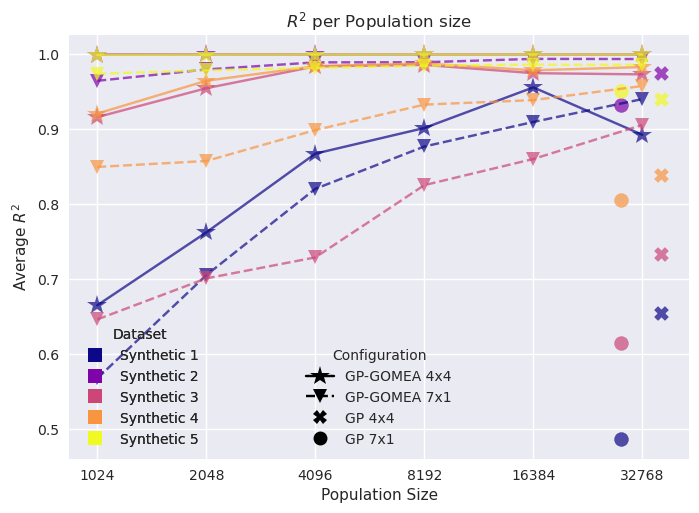

In [18]:
plt.figure()

from cycler import cycler
plt.rcParams['text.usetex'] = False
plasma = cm.get_cmap('plasma')

c = [plasma(i / (5 - 1)) for i in range(5)]
sum = 0
for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][0]))
    plt.plot(locations, plt_list, label="4x4 " + dataset.replace("_"," ").capitalize(), linestyle="-", marker="*", color=c[idx], alpha=0.7, markersize=15)
    
    plt_list = []
    for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
        
        plt_list.append(np.mean(dict_per_dataset[dataset][run][0]))
    plt.plot(locations, plt_list, label="7x1 " + dataset.replace("_"," ").capitalize(), linestyle="--", marker="v", color=c[idx], alpha=0.7, markersize=10)
    
    print(dataset, np.mean(dict_per_dataset[dataset]["GP_4_4_32768"][0]))
    plt.scatter(32768 + 4096, np.mean(dict_per_dataset[dataset]["GP_4_4_32768"][0]), marker="X", label="GP 4x4", alpha=0.7, color=c[idx], s=100)  
    plt.scatter(32768 - 4096, np.mean(dict_per_dataset[dataset]["GP_7_1_32768"][0]), marker="o", label="GP 7x1", alpha=0.7, color=c[idx], s=100 )    

plt.xscale('log', base=2)
plt.ylabel(r'Average $R^2$')
plt.xlabel("Population Size")
plt.title(r"$R^2$ per Population size")
plt.xticks(locations, labels=locations)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="-", marker="*", markerfacecolor='k', color='k', label="GP-GOMEA 4x4", markersize=15, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="--", marker="v", markerfacecolor='k', color='k', label="GP-GOMEA 7x1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor='k', label="GP 4x4", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor='k', label="GP 7x1", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='lower center', title="Configuration")
plt.gca().add_artist(marker_legend)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[0], label="Synthetic 1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[1], label="Synthetic 2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[2], label="Synthetic 3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[3], label="Synthetic 4", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[4], label="Synthetic 5", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower left', title="Dataset")
plt.gca().add_artist(colour_legend)


plt.savefig("./results/plots/final/r2perpopulation.pdf", bbox_inches='tight', dpi=600)
plt.show()

# Reload data for config experiments

In [19]:
data_folder = "final"


experiments = [
    ["SO_7_1", "SO_6_1", "SO_5_1", "SO_4_1", "SO_3_1", 
     "SO_5_2", "SO_4_2", "SO_3_2", 
     "SO_5_3", "SO_4_3", "SO_3_3",
     "SO_5_4", "SO_4_4", "SO_3_4",
     "SO_5_5", "SO_4_5", "SO_3_5",
     "SO_4_4_nodrift", "SO_7_1_nodrift", "SO_4_4_nthg"
    ]
]

big_list = []
for sublist in experiments:
    big_list.extend(sublist)
    
dict_per_dataset_config = {}
    
#"synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"
for dataset in ["air", "bike", "concrete","dowchemical","tower", 
                "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]:
    d = defaultdict(lambda: defaultdict(list))
    c = defaultdict(int)
    time = defaultdict(float)

    folder = data_folder
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):

        if(dataset in filename):
            nr = filename.split("/")[-1].split("_")[0]
            d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

            if d_key not in big_list:
                continue
            
            df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
            
            # Train R2
            d[d_key][0].append(1. - float(df.iloc[-1][1])/float(df.iloc[-1][7]))
            # Val R2
            d[d_key][1].append(1. - float(df.iloc[-1][2])/float(df.iloc[-1][8]))
            # Found
            d[d_key][2].append(1. if float(df.iloc[-1][1])<1e-6 else 0.)
            # Number of nodes
            d[d_key][3].append(float(df.iloc[-1][3]))
            # Non-improvements
            d[d_key][4].append(float(df.iloc[-1][15].split(",")[-1]))
            # Gen best is found
            d[d_key][5].append(["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.6f}".format(float(df.iloc[-1][1]))))
            # Time best is found
            d[d_key][6].append(float(df.iloc[-1][16].split(",")[["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.6f}".format(float(df.iloc[-1][1])))]))
            # Best size
            d[d_key][7].append(float(df.iloc[-1][4]))
            # Gens
            d[d_key][8].append(len(["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")]))
            # Time
            d[d_key][9].append(float(df.iloc[-1][16].split(",")[-1]))
            d[d_key][10].append(float(df.iloc[-1][4]))
            # closest to one hour 
            d[d_key][11].append(1. - float(df.iloc[-1][9].split(",")[max([i for i, v in enumerate([float(z) for z in df.iloc[-1][16].split(",")]) if v <= 3600], default=-1)])/float(df.iloc[-1][7]))
            # closest to 6 hours
            d[d_key][12].append(1. - float(df.iloc[-1][9].split(",")[max([i for i, v in enumerate([float(z) for z in df.iloc[-1][16].split(",")]) if v <= 3600*6], default=-1)])/float(df.iloc[-1][7]))
 
            
    
    dict_per_dataset_config[dataset] = d
    
    print("#"*5, dataset, "#"*5)
    for k in d.keys():
        print(k, "Train R2", "{:.3f}".format(np.mean(d[k][0])), "Val R2", "{:.3f}".format(np.mean(d[k][1])),
              "Size", "{:.3f}".format(np.mean(d[k][3])), 
              "Found", "{:.3f}".format(np.sum(d[k][2])), 
              "MSE per comp", "{:.3f}".format(np.mean(d[k][0])*100/np.mean(d[k][3])), "Non-improvements", np.mean(d[k][4]), "Gens", np.mean(d[k][5]), "Time to min", np.median(d[k][6]))
        

##### air #####
SO_3_1 Train R2 0.623 Val R2 0.613 Size 12.800 Found 0.000 MSE per comp 4.867 Non-improvements 100.0 Gens 24.366666666666667 Time to min 102.5934985
SO_3_2 Train R2 0.732 Val R2 0.726 Size 23.300 Found 0.000 MSE per comp 3.143 Non-improvements 73.26666666666667 Gens 178.66666666666666 Time to min 798.5355225000001
SO_3_3 Train R2 0.803 Val R2 0.799 Size 38.567 Found 0.000 MSE per comp 2.083 Non-improvements 13.166666666666666 Gens 241.4 Time to min 3461.5484619999997
SO_3_4 Train R2 0.821 Val R2 0.816 Size 55.100 Found 0.000 MSE per comp 1.489 Non-improvements 1.4 Gens 233.5 Time to min 3604.435547
SO_3_5 Train R2 0.822 Val R2 0.817 Size 72.167 Found 0.000 MSE per comp 1.139 Non-improvements 0.4 Gens 193.4 Time to min 3605.2614745
SO_4_1 Train R2 0.699 Val R2 0.692 Size 16.200 Found 0.000 MSE per comp 4.315 Non-improvements 100.0 Gens 18.933333333333334 Time to min 153.8255005
SO_4_2 Train R2 0.814 Val R2 0.809 Size 43.633 Found 0.000 MSE per comp 1.865 Non-improvements

##### dowchemical #####
SO_3_1 Train R2 0.726 Val R2 0.727 Size 13.933 Found 0.000 MSE per comp 5.214 Non-improvements 100.0 Gens 12.166666666666666 Time to min 44.029499
SO_3_2 Train R2 0.783 Val R2 0.783 Size 24.233 Found 0.000 MSE per comp 3.230 Non-improvements 96.66666666666667 Gens 127.5 Time to min 479.29049699999996
SO_3_3 Train R2 0.809 Val R2 0.808 Size 35.867 Found 0.000 MSE per comp 2.255 Non-improvements 43.266666666666666 Gens 383.26666666666665 Time to min 2953.336548
SO_3_4 Train R2 0.829 Val R2 0.829 Size 45.233 Found 0.000 MSE per comp 1.832 Non-improvements 7.7 Gens 339.1333333333333 Time to min 3354.908447
SO_3_5 Train R2 0.837 Val R2 0.837 Size 63.500 Found 0.000 MSE per comp 1.318 Non-improvements 2.2333333333333334 Gens 289.23333333333335 Time to min 3530.3775635
SO_4_1 Train R2 0.783 Val R2 0.783 Size 26.200 Found 0.000 MSE per comp 2.989 Non-improvements 100.0 Gens 21.4 Time to min 219.67449950000002
SO_4_2 Train R2 0.838 Val R2 0.838 Size 53.933 Found 0.000 MS

##### synthetic_2 #####
SO_3_1 Train R2 0.830 Val R2 0.827 Size 12.000 Found 0.000 MSE per comp 6.919 Non-improvements 100.0 Gens 3.933333333333333 Time to min 10.2995
SO_3_2 Train R2 0.962 Val R2 0.962 Size 28.933 Found 0.000 MSE per comp 3.326 Non-improvements 100.0 Gens 44.96666666666667 Time to min 143.97799650000002
SO_3_3 Train R2 0.998 Val R2 0.998 Size 43.033 Found 25.000 MSE per comp 2.319 Non-improvements 12.633333333333333 Gens 77.56666666666666 Time to min 789.4475095
SO_3_4 Train R2 1.000 Val R2 1.000 Size 46.367 Found 29.000 MSE per comp 2.156 Non-improvements 0.06666666666666667 Gens 51.233333333333334 Time to min 770.396515
SO_3_5 Train R2 1.000 Val R2 1.000 Size 46.067 Found 30.000 MSE per comp 2.171 Non-improvements 0.0 Gens 37.56666666666667 Time to min 682.7174990000001
SO_4_1 Train R2 0.962 Val R2 0.962 Size 22.633 Found 0.000 MSE per comp 4.252 Non-improvements 100.0 Gens 19.933333333333334 Time to min 111.348499
SO_4_2 Train R2 0.998 Val R2 0.998 Size 44.867 Foun

##### synthetic_5 #####
SO_3_1 Train R2 0.720 Val R2 0.717 Size 12.000 Found 0.000 MSE per comp 5.998 Non-improvements 100.0 Gens 1.8 Time to min 7.308
SO_3_2 Train R2 0.956 Val R2 0.955 Size 30.167 Found 0.000 MSE per comp 3.169 Non-improvements 89.43333333333334 Gens 133.86666666666667 Time to min 1341.4695435
SO_3_3 Train R2 0.986 Val R2 0.986 Size 49.700 Found 1.000 MSE per comp 1.985 Non-improvements 6.966666666666667 Gens 146.86666666666667 Time to min 2736.3764650000003
SO_3_4 Train R2 0.990 Val R2 0.990 Size 49.433 Found 2.000 MSE per comp 2.003 Non-improvements 3.8 Gens 121.3 Time to min 3252.4904785
SO_3_5 Train R2 0.991 Val R2 0.990 Size 54.233 Found 0.000 MSE per comp 1.827 Non-improvements 4.566666666666666 Gens 95.26666666666667 Time to min 2965.6005859999996
SO_4_1 Train R2 0.939 Val R2 0.939 Size 17.867 Found 0.000 MSE per comp 5.258 Non-improvements 100.0 Gens 8.9 Time to min 57.950001
SO_4_2 Train R2 0.995 Val R2 0.995 Size 55.367 Found 3.000 MSE per comp 1.797 Non-im

/tmp/ipykernel_2642076/3256267347.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


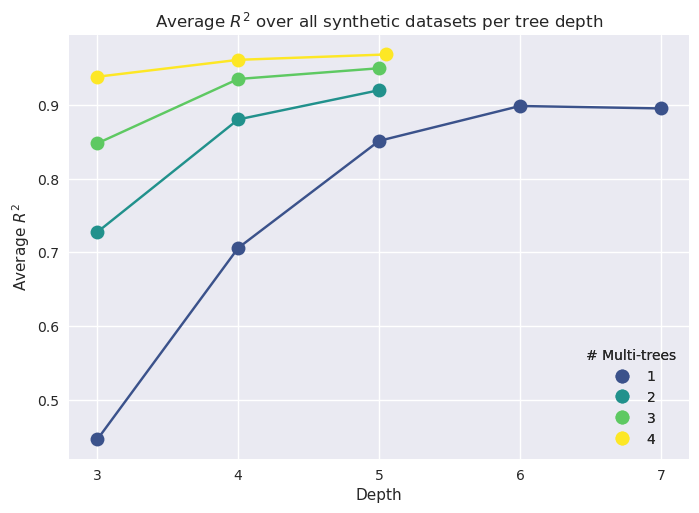

/tmp/ipykernel_2642076/3256267347.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


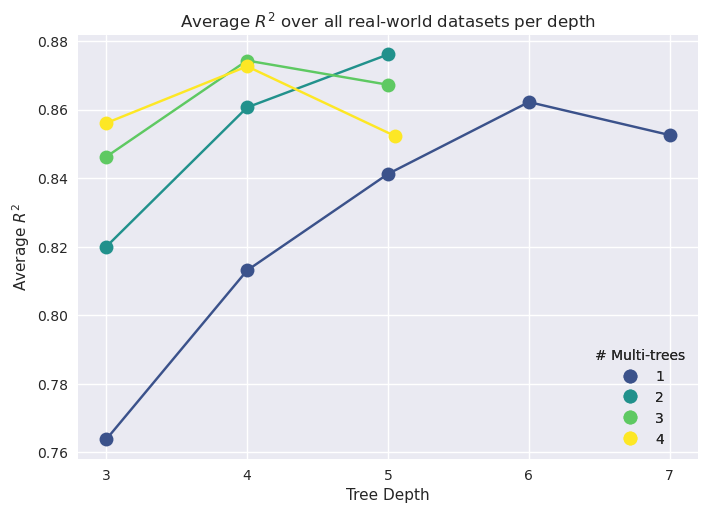

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

plt.rcParams['text.usetex'] = False

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
            value.append(np.mean(dict_per_dataset_config[dataset][stri][0]))
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset_config[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"

            jitter = 0
            if depth==5 and nr_multi_trees>2:
                jitter = (0.05*(nr_multi_trees-3.))
            plot_list.append([depth + jitter, np.mean(value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='o', markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average $R^2$')
plt.xlabel("Depth")
plt.title(r'Average $R^2$ over all synthetic datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)
plt.savefig("./results/plots/final/r2synth.pdf", bbox_inches='tight', dpi=600)
plt.show()

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        for idx, dataset in enumerate(["tower", "concrete", "air", "dowchemical", "bike"]):
            value.append(np.mean(dict_per_dataset_config[dataset][stri][0]))
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset_config[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"

            jitter = 0
            if depth==5 and nr_multi_trees>2:
                jitter = (0.05*(nr_multi_trees-3.))
            plot_list.append([depth + jitter, np.mean(value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='o', markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average $R^2$')
plt.xlabel("Tree Depth")
plt.title(r'Average $R^2$ over all real-world datasets per depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)
plt.savefig("./results/plots/final/r2real.pdf", bbox_inches='tight', dpi=600)
plt.show()


/tmp/ipykernel_2642076/4089836961.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


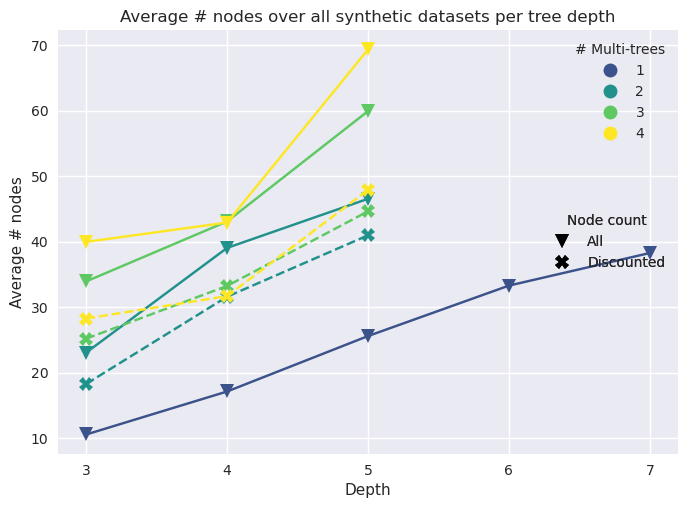

/tmp/ipykernel_2642076/4089836961.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


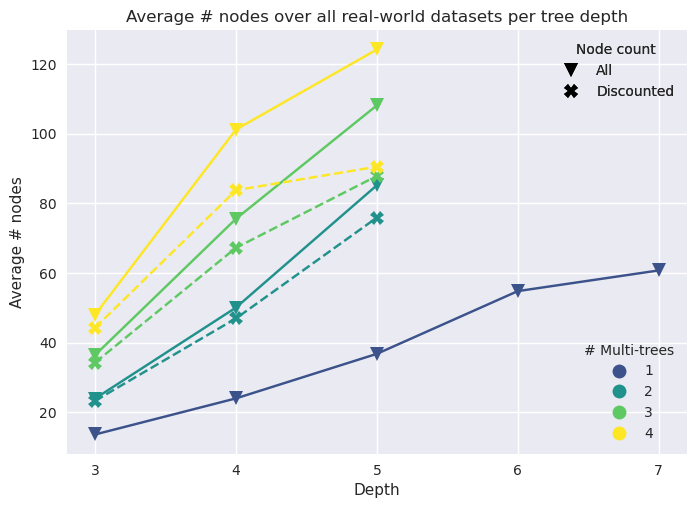

/tmp/ipykernel_2642076/4089836961.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

plt.rcParams['text.usetex'] = False

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    plot_list_discounted = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        discounted_value = []
        for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
            value.append(np.mean(dict_per_dataset_config[dataset][stri][3]))
            discounted_value.append(np.mean(dict_per_dataset_config[dataset][stri][7]))
            
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset_config[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"


            plot_list.append([depth, np.mean(value)])
            plot_list_discounted.append([depth, np.mean(discounted_value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='v', markersize=10, c=colors[nr_multi_trees])
    if nr_multi_trees>1:
        plot_list_discounted = np.array(plot_list_discounted)
        plt.plot(plot_list_discounted[:,0], plot_list_discounted[:,1], marker='X', linestyle="--", markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average # nodes')
plt.xlabel("Depth")
plt.title(r'Average # nodes over all synthetic datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='upper right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="v", markerfacecolor="k", label="All", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor="k", label="Discounted", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='center right', title="Node count")
plt.gca().add_artist(marker_legend)
plt.savefig("./results/plots/final/nodesynth.pdf", bbox_inches='tight', dpi=600)
plt.show()

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting

plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    plot_list_discounted = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        discounted_value = []
        for idx, dataset in enumerate(["tower", "concrete", "air", "dowchemical", "bike"]):
            value.append(np.mean(dict_per_dataset_config[dataset][stri][3]))
            discounted_value.append(np.mean(dict_per_dataset_config[dataset][stri][7]))
            
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset_config[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"


            plot_list.append([depth, np.mean(value)])
            plot_list_discounted.append([depth, np.mean(discounted_value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='v', markersize=10, c=colors[nr_multi_trees])
    if nr_multi_trees>1:
        plot_list_discounted = np.array(plot_list_discounted)
        plt.plot(plot_list_discounted[:,0], plot_list_discounted[:,1], marker='X', linestyle="--", markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average # nodes')
plt.xlabel("Depth")
plt.title(r'Average # nodes over all real-world datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="v", markerfacecolor="k", label="All", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor="k", label="Discounted", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='upper right', title="Node count")
plt.gca().add_artist(marker_legend)
plt.savefig("./results/plots/final/nodereal.pdf", bbox_inches='tight', dpi=600)
plt.show()

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting



/tmp/ipykernel_2642076/1769729747.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


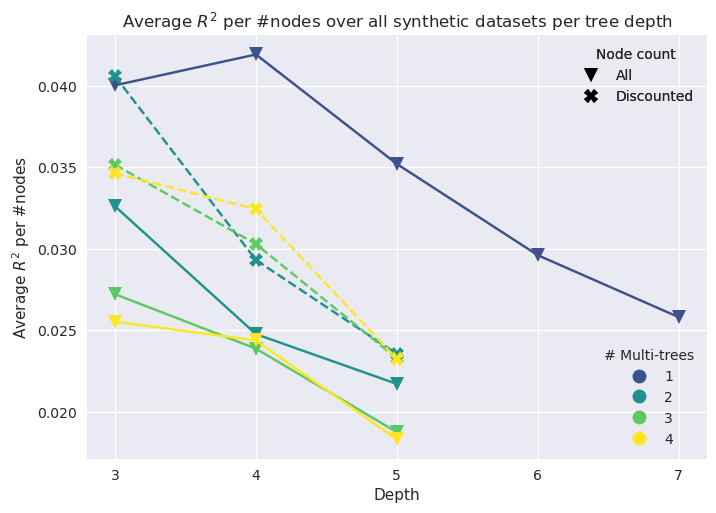

/tmp/ipykernel_2642076/1769729747.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


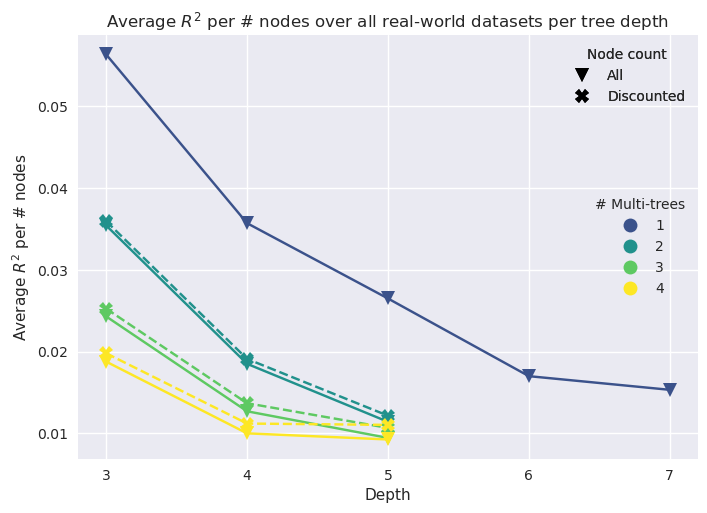

/tmp/ipykernel_2642076/1769729747.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

plt.rcParams['text.usetex'] = False

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    plot_list_discounted = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        discounted_value = []
        for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
            value.append(np.mean(np.divide(dict_per_dataset_config[dataset][stri][0],dict_per_dataset_config[dataset][stri][3])))
            discounted_value.append(np.mean(np.divide(dict_per_dataset_config[dataset][stri][0],dict_per_dataset_config[dataset][stri][7])))
            
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset_config[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"


            plot_list.append([depth, np.mean(value)])
            plot_list_discounted.append([depth, np.mean(discounted_value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='v', markersize=10, c=colors[nr_multi_trees])
    if nr_multi_trees>1:
        plot_list_discounted = np.array(plot_list_discounted)
        plt.plot(plot_list_discounted[:,0], plot_list_discounted[:,1], marker='X', linestyle="--", markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average $R^2$ per #nodes')
plt.xlabel("Depth")
plt.title(r'Average $R^2$ per #nodes over all synthetic datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="v", markerfacecolor="k", label="All", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor="k", label="Discounted", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='upper right', title="Node count")
plt.gca().add_artist(marker_legend)

plt.show()

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting

plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    plot_list_discounted = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        discounted_value = []
        for idx, dataset in enumerate(["tower", "concrete", "air", "dowchemical", "bike"]):
            value.append(np.mean(np.divide(dict_per_dataset_config[dataset][stri][0],dict_per_dataset_config[dataset][stri][3])))
            discounted_value.append(np.mean(np.divide(dict_per_dataset_config[dataset][stri][0],dict_per_dataset_config[dataset][stri][7])))
            
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset_config[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"


            plot_list.append([depth, np.mean(value)])
            plot_list_discounted.append([depth, np.mean(discounted_value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='v', markersize=10, c=colors[nr_multi_trees])
    if nr_multi_trees>1:
        plot_list_discounted = np.array(plot_list_discounted)
        plt.plot(plot_list_discounted[:,0], plot_list_discounted[:,1], marker='X', linestyle="--", markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average $R^2$ per # nodes')
plt.xlabel("Depth")
plt.title(r'Average $R^2$ per # nodes over all real-world datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='center right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="v", markerfacecolor="k", label="All", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor="k", label="Discounted", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='upper right', title="Node count")
plt.gca().add_artist(marker_legend)

plt.show()

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting



# Necessity of Drift

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


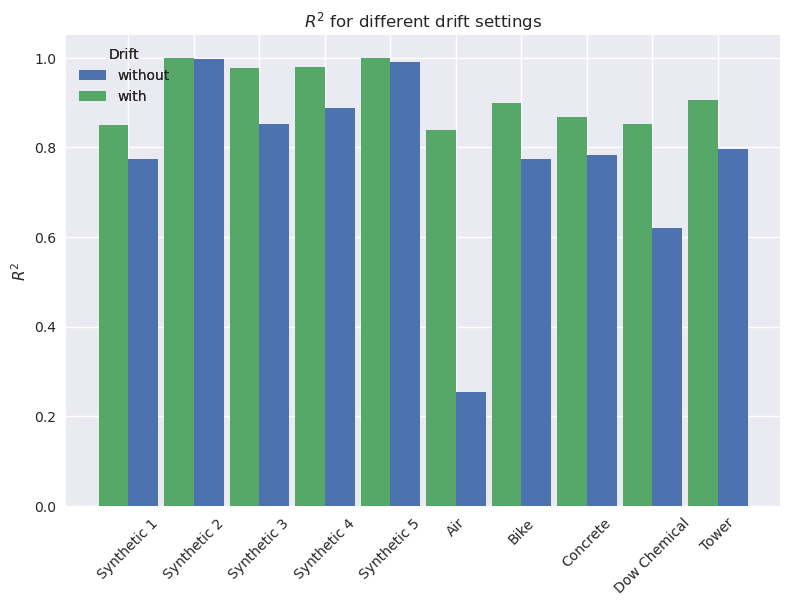

In [23]:
datasets = ("Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5", "Air", "Bike", "Concrete", "Dow Chemical", "Tower")

c = sns.color_palette()

nodrift_means = {
    'nodrift': (np.mean(dict_per_dataset_config["synthetic_1"]["SO_4_4_nodrift"][0]), 
              np.mean(dict_per_dataset_config["synthetic_2"]["SO_4_4_nodrift"][0]), 
              np.mean(dict_per_dataset_config["synthetic_3"]["SO_4_4_nodrift"][0]), 
              np.mean(dict_per_dataset_config["synthetic_4"]["SO_4_4_nodrift"][0]), 
              np.mean(dict_per_dataset_config["synthetic_5"]["SO_4_4_nodrift"][0]),
              np.mean(dict_per_dataset_config["air"]["SO_4_4_nodrift"][0]), 
              np.mean(dict_per_dataset_config["bike"]["SO_4_4_nodrift"][0]), 
              np.mean(dict_per_dataset_config["concrete"]["SO_4_4_nodrift"][0]), 
              np.mean(dict_per_dataset_config["dowchemical"]["SO_4_4_nodrift"][0]), 
              np.mean(dict_per_dataset_config["tower"]["SO_4_4_nodrift"][0])),
}

drift_means = {
    'drift': (np.mean(dict_per_dataset_config["synthetic_1"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["synthetic_2"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["synthetic_3"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["synthetic_4"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["synthetic_5"]["SO_4_4"][0]),
              
              np.mean(dict_per_dataset_config["air"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["bike"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["concrete"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["dowchemical"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["tower"]["SO_4_4"][0])),
}

x = np.arange(len(datasets))  # the label locations
width = 1/len(nodrift_means.keys())  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()


for (measurement_nodrift), (measurement_drift)  in zip(nodrift_means.values(), drift_means.values()):
    
    offset = width * multiplier
    
    for idx, (m_nodrift, m_drift) in enumerate(zip(measurement_nodrift, measurement_drift)):
        rects = ax.bar(idx*(width) + offset + idx*0.1, np.array(m_nodrift), width/2., color = c[multiplier])

        rects = ax.bar(idx*(width) + offset - width/2 + idx*0.1, np.array(m_drift), width/2., color = c[multiplier+1])
        
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$R^2$')
ax.set_title(r'$R^2$ for different drift settings')


ax.set_xticks([idx*(width) - 0.25*width + 0.1*idx for idx in np.arange(len(datasets))], datasets)
# Place legend outside the plot area
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Population size")
          
# colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx, val in enumerate(penguin_means.keys())]
# colour_legend = plt.legend(handles=colour_legend_elements, labels=list(penguin_means.keys()), title="Population size")
# plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Rectangle((0,0),1,1, facecolor=c[0]), plt.Rectangle((0,0),1,1, facecolor=c[1])]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["without", "with"], title="Drift", loc="upper left")
plt.gca().add_artist(marker_legend)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.xticks(rotation=45)

# Add some room at the top of the plot (adjust ylim)
max_value = max(max(measurement) for measurement in penguin_means.values())

plt.savefig("./results/plots/final/R2drift.pdf", bbox_inches='tight', dpi=600)
plt.show()

# Nothing Operator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


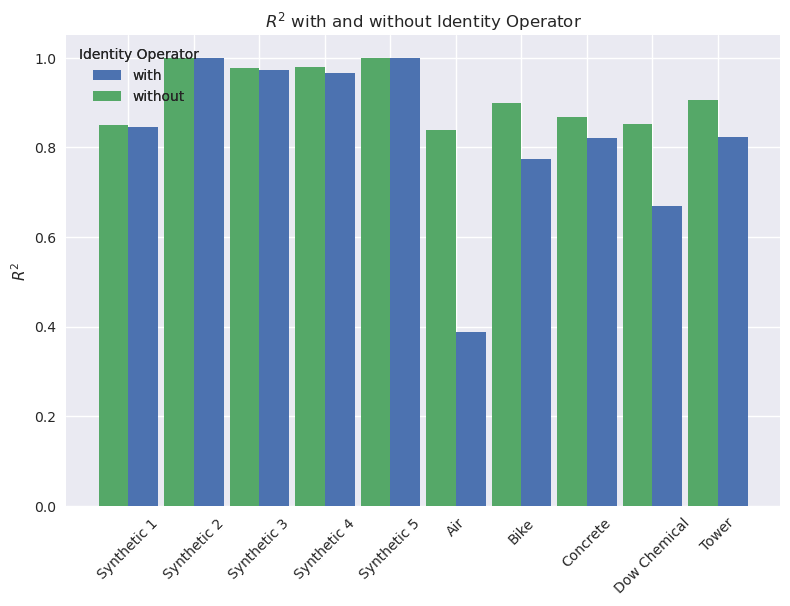

In [24]:
datasets = ("Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5", "Air", "Bike", "Concrete", "Dow Chemical", "Tower")

c = sns.color_palette()

nthg_means = {
    'nthg': (np.mean(dict_per_dataset_config["synthetic_1"]["SO_4_4_nthg"][0]), 
              np.mean(dict_per_dataset_config["synthetic_2"]["SO_4_4_nthg"][0]), 
              np.mean(dict_per_dataset_config["synthetic_3"]["SO_4_4_nthg"][0]), 
              np.mean(dict_per_dataset_config["synthetic_4"]["SO_4_4_nthg"][0]), 
              np.mean(dict_per_dataset_config["synthetic_5"]["SO_4_4_nthg"][0]),
              np.mean(dict_per_dataset_config["air"]["SO_4_4_nthg"][0]), 
              np.mean(dict_per_dataset_config["bike"]["SO_4_4_nthg"][0]), 
              np.mean(dict_per_dataset_config["concrete"]["SO_4_4_nthg"][0]), 
              np.mean(dict_per_dataset_config["dowchemical"]["SO_4_4_nthg"][0]), 
              np.mean(dict_per_dataset_config["tower"]["SO_4_4_nthg"][0])),
}

drift_means = {
    'drift': (np.mean(dict_per_dataset_config["synthetic_1"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["synthetic_2"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["synthetic_3"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["synthetic_4"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["synthetic_5"]["SO_4_4"][0]),
              
              np.mean(dict_per_dataset_config["air"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["bike"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["concrete"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["dowchemical"]["SO_4_4"][0]), 
              np.mean(dict_per_dataset_config["tower"]["SO_4_4"][0])),
}

x = np.arange(len(datasets))  # the label locations
width = 1/len(nthg_means.keys())  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()


for (measurement_nthg), (measurement_drift)  in zip(nthg_means.values(), drift_means.values()):
    
    offset = width * multiplier
    
    for idx, (m_nthg, m_drift) in enumerate(zip(measurement_nthg, measurement_drift)):
        rects = ax.bar(idx*(width) + offset + idx*0.1, np.array(m_nthg), width/2., color = c[multiplier])

        rects = ax.bar(idx*(width) + offset + idx*0.1 - width/2., np.array(m_drift), width/2., color = c[multiplier+1])
        
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$R^2$')
ax.set_title(r'$R^2$ with and without Identity Operator')


ax.set_xticks([idx*(width) - 0.25*width + idx*0.1 for idx in np.arange(len(datasets))], datasets)
# Place legend outside the plot area
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Population size")
          
# colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx, val in enumerate(penguin_means.keys())]
# colour_legend = plt.legend(handles=colour_legend_elements, labels=list(penguin_means.keys()), title="Population size")
# plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Rectangle((0,0),1,1, facecolor=c[0]), plt.Rectangle((0,0),1,1, facecolor=c[1])]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["with", "without"], title="Identity Operator", loc="upper left")
plt.gca().add_artist(marker_legend)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.xticks(rotation=45)

# Add some room at the top of the plot (adjust ylim)
max_value = max(max(measurement) for measurement in penguin_means.values())

plt.savefig("./results/plots/final/R2nthg.pdf", bbox_inches='tight', dpi=600)
plt.show()

Why dip at 32768?
Less gens
Not converged

In [25]:
!ls results/final/* | wc -l
5*30*14

8402


2100

# Is there an eval difference that causes the difference in time?

In [26]:
data_folder = "final"


experiments = [
    ["SO_7_1", "SO_6_1", "SO_5_1", "SO_4_1", "SO_3_1", 
     "SO_5_2", "SO_4_2", "SO_3_2", 
     "SO_5_3", "SO_4_3", "SO_3_3",
     "SO_5_4", "SO_4_4", "SO_3_4",
     "SO_5_5", "SO_4_5", "SO_3_5",
    ],
    
    ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"],
    ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"],
    ["GA_7_1_32768","GA_4_4_32768"],
    ["SO_4_4_16384_drift", "SO_4_4_16384_nthg", "SO_7_1_16384_drift"]
]

big_list = []
for sublist in experiments:
    big_list.extend(sublist)
    
dict_per_dataset_evals = {}
    
#"synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"
for dataset in ["air", "bike", "concrete","dowchemical","tower", 
                "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]:
    d = defaultdict(lambda: defaultdict(list))
    c = defaultdict(int)
    time = defaultdict(float)

    folder = data_folder
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):

        if(dataset in filename):
            nr = filename.split("/")[-1].split("_")[0]
            d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

            if d_key not in big_list:
                continue
            
            df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
            
            
            # Train R2
            d[d_key][0].append(1. - float(df.iloc[-1][1])/float(df.iloc[-1][7]))
            # Val R2
            d[d_key][1].append(1. - float(df.iloc[-1][2])/float(df.iloc[-1][8]))
            # Found
            d[d_key][2].append(1. if float(df.iloc[-1][1])<1e-6 else 0.)
            # Number of nodes
            d[d_key][3].append(float(df.iloc[-1][3]))
            # Non-improvements
            d[d_key][4].append(float(df.iloc[-1][15].split(",")[-1]))
            # Gen best is found
            d[d_key][5].append(["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.6f}".format(float(df.iloc[-1][1]))))
            # Time best is found
            d[d_key][6].append(float(df.iloc[-1][16].split(",")[["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.6f}".format(float(df.iloc[-1][1])))]))
            # Best size
            d[d_key][7].append(float(df.iloc[-1][4]))
            # Gens
            d[d_key][8].append(len(["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")]))
            # Time
            d[d_key][9].append(float(df.iloc[-1][16].split(",")[-1]))
            d[d_key][10].append(float(df.iloc[-1][4]))
            # closest to one hour 
            d[d_key][11].append(1. - float(df.iloc[-1][9].split(",")[max([i for i, v in enumerate([float(z) for z in df.iloc[-1][16].split(",")]) if v <= 3600], default=-1)])/float(df.iloc[-1][7]))
            # closest to 6 hours
            d[d_key][12].append(1. - float(df.iloc[-1][9].split(",")[max([i for i, v in enumerate([float(z) for z in df.iloc[-1][16].split(",")]) if v <= 3600*6], default=-1)])/float(df.iloc[-1][7]))
            # evals
            d[d_key][13].append([float(x) for x in df.iloc[-1][17].split(",")])
            # best sizes
            d[d_key][14].append([float(x) for x in df.iloc[-1][11].split(",")])
            
    
    dict_per_dataset_evals[dataset] = d
    
    print("#"*5, dataset, "#"*5)
    for k in d.keys():
        print(k, "Train R2", "{:.3f}".format(np.mean(d[k][0])), "Val R2", "{:.3f}".format(np.mean(d[k][1])),
              "Size", "{:.3f}".format(np.mean(d[k][3])), 
              "Found", "{:.3f}".format(np.sum(d[k][2])), 
              "MSE per comp", "{:.3f}".format(np.mean(d[k][0])*100/np.mean(d[k][3])), "Non-improvements", np.mean(d[k][4]), "Gens", np.mean(d[k][5]), "Time to min", np.median(d[k][6]))
        

##### air #####
SO_3_1 Train R2 0.623 Val R2 0.613 Size 12.800 Found 0.000 MSE per comp 4.867 Non-improvements 100.0 Gens 24.366666666666667 Time to min 102.5934985
SO_3_2 Train R2 0.732 Val R2 0.726 Size 23.300 Found 0.000 MSE per comp 3.143 Non-improvements 73.26666666666667 Gens 178.66666666666666 Time to min 798.5355225000001
SO_3_3 Train R2 0.803 Val R2 0.799 Size 38.567 Found 0.000 MSE per comp 2.083 Non-improvements 13.166666666666666 Gens 241.4 Time to min 3461.5484619999997
SO_3_4 Train R2 0.821 Val R2 0.816 Size 55.100 Found 0.000 MSE per comp 1.489 Non-improvements 1.4 Gens 233.5 Time to min 3604.435547
SO_3_5 Train R2 0.822 Val R2 0.817 Size 72.167 Found 0.000 MSE per comp 1.139 Non-improvements 0.4 Gens 193.4 Time to min 3605.2614745
SO_4_1 Train R2 0.699 Val R2 0.692 Size 16.200 Found 0.000 MSE per comp 4.315 Non-improvements 100.0 Gens 18.933333333333334 Time to min 153.8255005
SO_4_2 Train R2 0.814 Val R2 0.809 Size 43.633 Found 0.000 MSE per comp 1.865 Non-improvements

##### tower #####
SO_3_1 Train R2 0.865 Val R2 0.867 Size 14.867 Found 0.000 MSE per comp 5.820 Non-improvements 100.0 Gens 30.3 Time to min 143.762001
SO_3_2 Train R2 0.884 Val R2 0.886 Size 25.333 Found 0.000 MSE per comp 3.489 Non-improvements 70.33333333333333 Gens 175.4 Time to min 1461.052002
SO_3_3 Train R2 0.892 Val R2 0.893 Size 37.233 Found 0.000 MSE per comp 2.395 Non-improvements 11.166666666666666 Gens 329.6 Time to min 3552.746948
SO_3_4 Train R2 0.894 Val R2 0.896 Size 46.367 Found 0.000 MSE per comp 1.929 Non-improvements 4.2 Gens 315.96666666666664 Time to min 3589.8690184999996
SO_3_5 Train R2 0.899 Val R2 0.901 Size 62.467 Found 0.000 MSE per comp 1.440 Non-improvements 0.26666666666666666 Gens 255.53333333333333 Time to min 3593.5319825
SO_4_1 Train R2 0.883 Val R2 0.885 Size 27.133 Found 0.000 MSE per comp 3.255 Non-improvements 67.43333333333334 Gens 65.46666666666667 Time to min 1527.6690065
SO_4_2 Train R2 0.902 Val R2 0.904 Size 47.633 Found 0.000 MSE per comp 

##### synthetic_3 #####
GA_4_4_32768 Train R2 0.501 Val R2 0.493 Size 24.967 Found 0.000 MSE per comp 2.005 Non-improvements 15.1 Gens 155.8 Time to min 19684.472656500002
GA_7_1_32768 Train R2 0.647 Val R2 0.633 Size 27.267 Found 0.000 MSE per comp 2.371 Non-improvements 10.566666666666666 Gens 165.06666666666666 Time to min 20762.988280999998
SO_3_1 Train R2 0.238 Val R2 0.219 Size 9.767 Found 0.000 MSE per comp 2.434 Non-improvements 100.0 Gens 6.8 Time to min 12.5705
SO_3_2 Train R2 0.470 Val R2 0.458 Size 18.600 Found 0.000 MSE per comp 2.527 Non-improvements 100.0 Gens 64.7 Time to min 113.2334975
SO_3_3 Train R2 0.677 Val R2 0.673 Size 25.500 Found 0.000 MSE per comp 2.657 Non-improvements 100.0 Gens 118.33333333333333 Time to min 368.55200149999996
SO_3_4 Train R2 0.900 Val R2 0.899 Size 36.033 Found 0.000 MSE per comp 2.498 Non-improvements 55.43333333333333 Gens 250.73333333333332 Time to min 2224.9270020000004
SO_3_5 Train R2 0.974 Val R2 0.973 Size 46.700 Found 7.000 MSE pe

##### synthetic_5 #####
GA_4_4_32768 Train R2 0.649 Val R2 0.634 Size 23.800 Found 0.000 MSE per comp 2.726 Non-improvements 35.5 Gens 133.6 Time to min 16222.815918
GA_7_1_32768 Train R2 0.764 Val R2 0.748 Size 24.633 Found 0.000 MSE per comp 3.103 Non-improvements 31.633333333333333 Gens 137.13333333333333 Time to min 18767.1035155
SO_3_1 Train R2 0.720 Val R2 0.717 Size 12.000 Found 0.000 MSE per comp 5.998 Non-improvements 100.0 Gens 1.8 Time to min 7.308
SO_3_2 Train R2 0.956 Val R2 0.955 Size 30.167 Found 0.000 MSE per comp 3.169 Non-improvements 89.43333333333334 Gens 133.86666666666667 Time to min 1341.4695435
SO_3_3 Train R2 0.986 Val R2 0.986 Size 49.700 Found 1.000 MSE per comp 1.985 Non-improvements 6.966666666666667 Gens 146.86666666666667 Time to min 2736.3764650000003
SO_3_4 Train R2 0.990 Val R2 0.990 Size 49.433 Found 2.000 MSE per comp 2.003 Non-improvements 3.8 Gens 121.3 Time to min 3252.4904785
SO_3_5 Train R2 0.991 Val R2 0.990 Size 54.233 Found 0.000 MSE per comp

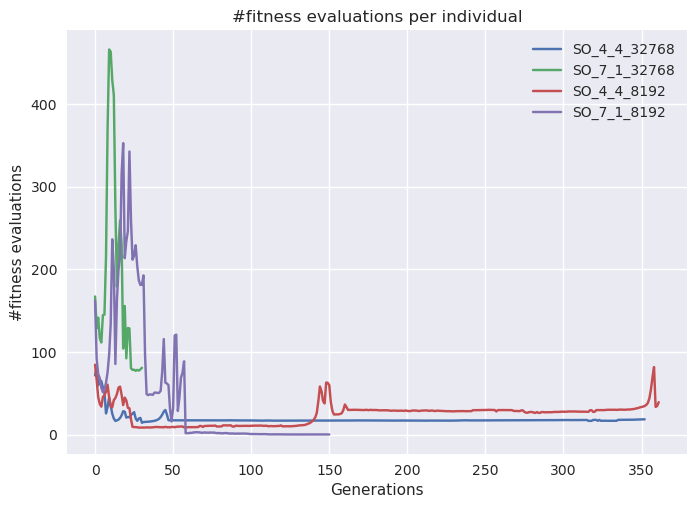

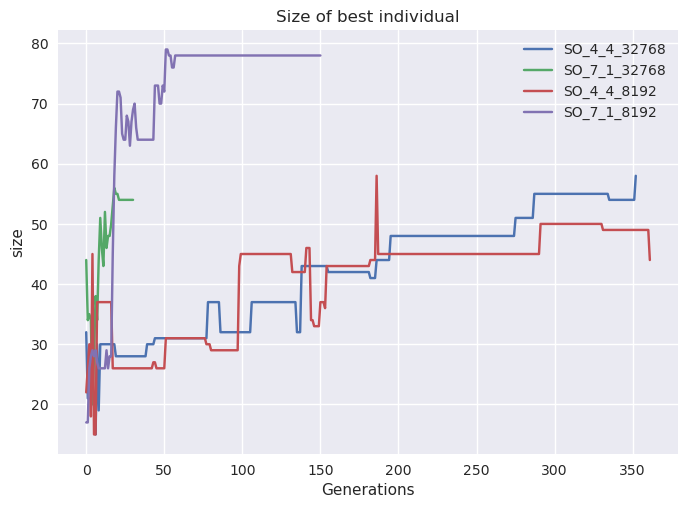

In [27]:
plt.figure()
plt.title("#fitness evaluations per individual")
for config in ["SO_4_4_32768", "SO_7_1_32768", "SO_4_4_8192", "SO_7_1_8192"]:
    popsize = float(config.split("_")[-1])
    prepended  = [0.] + dict_per_dataset_evals["synthetic_1"][config][13][0]
    plt.plot(np.diff(prepended)/popsize, label=config)
    
plt.ylabel("#fitness evaluations")
plt.xlabel("Generations")
plt.legend()
plt.show()

plt.figure()
plt.title("Size of best individual")
for config in ["SO_4_4_32768", "SO_7_1_32768", "SO_4_4_8192", "SO_7_1_8192"]:
    plt.plot(dict_per_dataset_evals["synthetic_1"][config][14][0], label=config)
    
plt.ylabel("size")
plt.xlabel("Generations")
plt.legend()
plt.show()

988


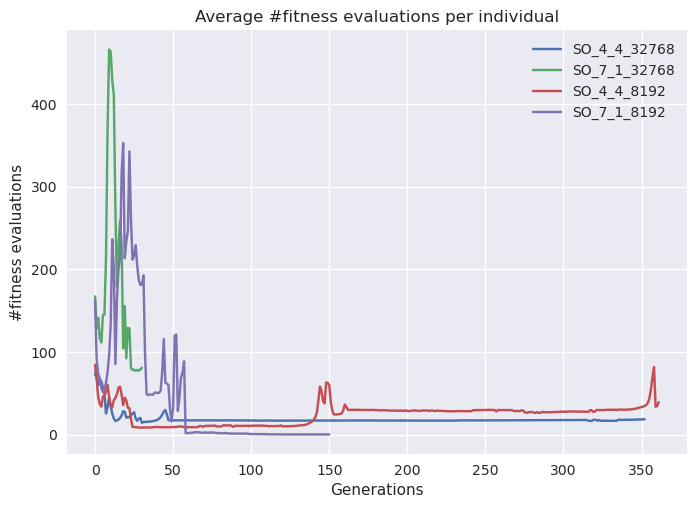

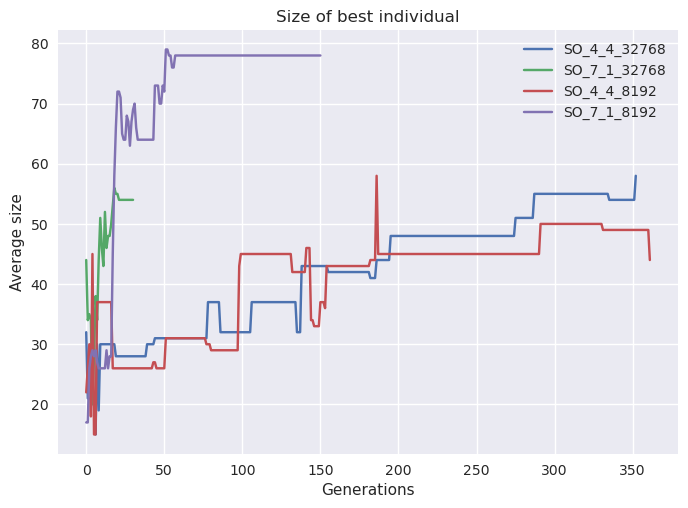

In [28]:
plt.figure()
plt.title("Average #fitness evaluations per individual")

largest_len = 0
for config in ["SO_4_4_32768", "SO_7_1_32768", "SO_4_4_8192", "SO_7_1_8192"]:
    comp = np.max([len(dict_per_dataset_evals["synthetic_1"][config][13][i]) for i in range(len(dict_per_dataset_evals["synthetic_1"][config][13]))])
    if largest_len < comp:
        largest_len = comp
    
print(largest_len)
for config in ["SO_4_4_32768", "SO_7_1_32768", "SO_4_4_8192", "SO_7_1_8192"]:
    popsize = float(config.split("_")[-1])
    prepended  = [0.] + dict_per_dataset_evals["synthetic_1"][config][13][0]
    plt.plot(np.diff(prepended)/popsize, label=config)
    
plt.ylabel("#fitness evaluations")
plt.xlabel("Generations")
plt.legend()
plt.show()

plt.figure()
plt.title("Size of best individual")
for config in ["SO_4_4_32768", "SO_7_1_32768", "SO_4_4_8192", "SO_7_1_8192"]:
    plt.plot(dict_per_dataset_evals["synthetic_1"][config][14][0], label=config)
    
plt.ylabel("Average size")
plt.xlabel("Generations")
plt.legend()
plt.show()

In [29]:
trues = []
falses = []
equal = []
for file in glob.glob("results/GP/*.csv"):
    print(file)
    try:
        file = file.split("/")[-1]
        df = pd.read_csv("./results/GP/{}".format(file), sep="\t", header=None, nrows=max_gen)
        x = df.iloc[-1][1]
        df = pd.read_csv("./results/final/{}".format(file), sep="\t", header=None, nrows=max_gen)
        print(x, df.iloc[-1][1])
        trues.append(x<df.iloc[-1][1])
        equal.append(x==df.iloc[-1][1])
        falses.append(x>df.iloc[-1][1])
    except:
        pass
print(np.sum(trues))
print(np.sum(equal))
np.sum(falses)

results/GP/8_GP_7_1_32768_synthetic_3.csv
0.115604 0.115604
results/GP/9_GP_7_1_32768_synthetic_1.csv
3.350868 3.350868
results/GP/6_GP_7_1_32768_synthetic_4.csv
0.002266 0.002266
results/GP/5_GP_7_1_32768_synthetic_5.csv
0.005356 0.005356
results/GP/1_GP_7_1_32768_synthetic_3.csv
0.183085 0.183085
results/GP/4_GP_4_4_32768_synthetic_2.csv
0.0 0.0
results/GP/8_GP_7_1_32768_synthetic_2.csv
5.804969 5.804969
results/GP/9_GP_4_4_32768_synthetic_4.csv
0.000879 0.000879
results/GP/1_GP_4_4_32768_synthetic_4.csv
0.001728 0.001728
results/GP/6_GP_7_1_32768_synthetic_1.csv
0.334023 0.334023
results/GP/9_GP_4_4_32768_synthetic_3.csv
0.043705 0.043705
results/GP/8_GP_4_4_32768_synthetic_4.csv
4.4e-05 4.4e-05
results/GP/5_GP_4_4_32768_synthetic_2.csv
0.482984 0.482984
results/GP/3_GP_4_4_32768_synthetic_3.csv
0.029046 0.029046
results/GP/3_GP_7_1_32768_synthetic_1.csv
1.10785 1.10785
results/GP/9_GP_7_1_32768_synthetic_3.csv
0.047438 0.047438
results/GP/3_GP_7_1_32768_synthetic_3.csv
0.125564 0.1

0

In [30]:
for file in glob.glob("results/drift/*.csv"):
    file = file.split("/")[-1]
    df = pd.read_csv("./results/drift/{}".format(file), sep="\t", header=None, nrows=None)
    if(float(df.iloc[-1][16].split(",")[-1])>3600*6):
        print(file, (float(df.iloc[-1][16].split(",")[-1]) - 3600*6)/60)

27_GP_4_4_32768_synthetic_1.csv 3.6113932333333043
14_SO_7_1_16384_synthetic_5.csv 2.1370768166666796
23_GP_7_1_32768_synthetic_5.csv 1.1644205666666798
8_GP_7_1_32768_synthetic_3.csv 2.37890625
16_GP_4_4_32768_synthetic_5.csv 0.6814453166666378
9_GA_4_4_32768_synthetic_3.csv 1.7862304666666509
30_GA_4_4_32768_synthetic_1.csv 1.6307942666666955
10_SO_7_1_32768_synthetic_2.csv 2.1361979166666667
15_SO_7_1_16384_synthetic_2.csv 4.415429683333362
18_SO_7_1_16384_synthetic_1.csv 1.353808599999987
9_GP_7_1_32768_synthetic_1.csv 1.1449869833333044
27_GA_4_4_32768_synthetic_1.csv 1.8801432333333044
24_SO_7_1_32768_synthetic_5.csv 7.741959633333318
21_SO_4_4_32768_synthetic_1.csv 0.4622395833333333
29_GP_7_1_32768_synthetic_2.csv 3.1060221333333176
6_SO_4_4_32768_synthetic_3.csv 0.22421875
9_GA_7_1_32768_synthetic_3.csv 1.5744466166666826
26_GA_4_4_32768_synthetic_2.csv 0.1656901000000289
30_GP_7_1_32768_synthetic_4.csv 1.8971354166666667
23_SO_7_1_16384_synthetic_4.csv 1.4972005166666955
13_G

17_GA_4_4_32768_synthetic_4.csv 0.20234375
4_SO_7_1_32768_synthetic_4.csv 5.164485683333321
6_GA_7_1_32768_synthetic_2.csv 0.8658528666666825
17_GA_4_4_32768_synthetic_5.csv 0.48707681666667973
2_SO_7_1_32768_synthetic_4.csv 5.098665366666682
18_GP_4_4_32768_synthetic_4.csv 1.6784179666666508
24_GA_4_4_32768_synthetic_5.csv 0.48889973333334635
28_GP_4_4_32768_synthetic_3.csv 2.7861328166666377
22_GP_4_4_32768_synthetic_1.csv 2.877506516666654
22_GA_4_4_32768_synthetic_2.csv 1.2007487000000159
30_SO_4_4_32768_synthetic_3.csv 0.7247070333333492
25_GP_4_4_32768_synthetic_1.csv 2.68011068333332
12_SO_4_4_32768_synthetic_1.csv 0.2230143166666797
29_GP_4_4_32768_synthetic_2.csv 3.703027349999987
7_GP_4_4_32768_synthetic_5.csv 2.9775716166666824
22_GA_7_1_32768_synthetic_3.csv 1.4339192666666956
2_GP_7_1_32768_synthetic_1.csv 2.312304683333362
30_GA_4_4_32768_synthetic_3.csv 1.898828133333336
20_GA_4_4_32768_synthetic_5.csv 0.8697265666666377
13_SO_7_1_32768_synthetic_5.csv 8.49140625
19_GA_7

1_GA_4_4_32768_synthetic_2.csv 0.19394531666663775
12_GP_7_1_32768_synthetic_4.csv 3.2396484333333624
13_GA_4_4_32768_synthetic_5.csv 0.23277995000001586
20_GP_7_1_32768_synthetic_4.csv 4.164941400000013
3_GA_7_1_32768_synthetic_1.csv 0.9887369833333044
21_SO_7_1_16384_synthetic_3.csv 3.4841471333333174
9_GA_4_4_32768_synthetic_4.csv 0.8632487000000159
13_GA_7_1_32768_synthetic_1.csv 0.18372396666666949
1_GP_7_1_32768_synthetic_1.csv 3.4880533833333174
2_SO_7_1_16384_synthetic_1.csv 2.815559899999971
21_GP_4_4_32768_synthetic_3.csv 3.652539066666638
29_GA_7_1_32768_synthetic_4.csv 0.4781575499999841
30_GA_4_4_32768_synthetic_2.csv 1.3535156333333362
27_GA_7_1_32768_synthetic_3.csv 1.248502600000029
10_GA_7_1_32768_synthetic_1.csv 1.9447265666666378
12_GP_7_1_32768_synthetic_2.csv 2.9359700499999843
1_GP_4_4_32768_synthetic_2.csv 3.8207682333333044
11_GP_7_1_32768_synthetic_3.csv 2.017057300000003
29_GA_7_1_32768_synthetic_2.csv 1.2200520833333333
19_GP_7_1_32768_synthetic_3.csv 3.90442

3_SO_7_1_32768_synthetic_2.csv 3.091601566666638
21_SO_7_1_8192_synthetic_5.csv 0.6424153666666825
8_SO_7_1_16384_synthetic_1.csv 2.9990559833333466
10_GP_7_1_32768_synthetic_4.csv 2.31207681666668
14_GP_7_1_32768_synthetic_4.csv 4.145800783333349
14_GA_4_4_32768_synthetic_5.csv 0.6472005166666955
4_SO_7_1_8192_synthetic_5.csv 1.6015625
4_GP_7_1_32768_synthetic_5.csv 1.5818359333333623
16_GP_7_1_32768_synthetic_2.csv 0.07255859999998696
28_GP_7_1_32768_synthetic_4.csv 2.029622399999971
2_SO_7_1_8192_synthetic_5.csv 2.122493483333346
18_GA_7_1_32768_synthetic_4.csv 0.47773436666666386
16_GP_7_1_32768_synthetic_4.csv 3.420052083333333
20_GP_4_4_32768_synthetic_2.csv 0.5692057333333044
12_SO_7_1_16384_synthetic_4.csv 1.4886067666666956
25_SO_7_1_16384_synthetic_4.csv 0.8869466166666825
8_SO_7_1_16384_synthetic_3.csv 2.812760416666667
5_SO_7_1_4096_synthetic_1.csv 0.4625325499999841
29_GP_4_4_32768_synthetic_3.csv 3.854557300000003
26_SO_7_1_16384_synthetic_1.csv 0.011686200000015863
4_GA_

30_SO_7_1_16384_synthetic_4.csv 0.8607747333333464
6_GA_7_1_32768_synthetic_3.csv 1.2716796833333623
3_GA_7_1_32768_synthetic_2.csv 0.7620442666666956
15_SO_7_1_16384_synthetic_4.csv 0.8161132833333492
6_GP_4_4_32768_synthetic_4.csv 2.969335933333362
29_SO_7_1_8192_synthetic_5.csv 0.6817382833333492
24_GA_4_4_32768_synthetic_4.csv 0.6113932333333044
15_GP_4_4_32768_synthetic_1.csv 0.3129882833333492
2_GA_7_1_32768_synthetic_4.csv 2.027018233333304
5_SO_7_1_32768_synthetic_1.csv 10.705631516666653
5_GP_7_1_32768_synthetic_1.csv 1.4130859333333623
15_GA_4_4_32768_synthetic_4.csv 1.4737630166666955
20_GA_7_1_32768_synthetic_4.csv 0.4593424500000159
17_GA_7_1_32768_synthetic_2.csv 1.293033850000029
13_GA_7_1_32768_synthetic_4.csv 0.30527343333336227
22_GP_7_1_32768_synthetic_2.csv 4.96839193333332
7_SO_7_1_16384_synthetic_3.csv 2.5511393166666796
17_SO_7_1_16384_synthetic_2.csv 5.657096350000029
19_SO_7_1_32768_synthetic_1.csv 16.456738283333348
11_SO_7_1_16384_synthetic_4.csv 1.7125325499

4_GA_4_4_32768_synthetic_5.csv 1.0013020833333333
5_GP_7_1_32768_synthetic_2.csv 1.5567382833333492
21_SO_7_1_16384_synthetic_5.csv 0.3126301999999972
25_GA_7_1_32768_synthetic_4.csv 1.5639323000000027
25_GA_7_1_32768_synthetic_2.csv 1.4449544333333202
1_SO_7_1_32768_synthetic_1.csv 5.456347650000013
16_GA_7_1_32768_synthetic_5.csv 1.3535807333333045
14_SO_7_1_16384_synthetic_3.csv 3.9987955666666797
7_GP_7_1_32768_synthetic_4.csv 3.8101237000000157
11_GA_7_1_32768_synthetic_3.csv 0.9956705666666797
20_SO_7_1_32768_synthetic_3.csv 6.927604166666667
28_GP_7_1_32768_synthetic_5.csv 2.2416341166666824
25_GP_4_4_32768_synthetic_5.csv 3.845833333333333
24_GA_7_1_32768_synthetic_5.csv 1.7487955666666797
28_GA_4_4_32768_synthetic_1.csv 1.0517578166666377
2_GP_7_1_32768_synthetic_4.csv 3.5434244833333044
12_GP_7_1_32768_synthetic_1.csv 1.1624348999999712
22_SO_4_4_32768_synthetic_3.csv 1.0199544333333204
25_GA_4_4_32768_synthetic_1.csv 0.8960286499999711
23_SO_7_1_32768_synthetic_1.csv 5.48867